<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-17 13:40:54.520004: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 13:40:54.551688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-17 13:40:54.551728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-17 13:40:54.552754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-17 13:40:54.558084: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 13:40:54.558989: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-17 13:40:55.273415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-17 13:40:57.673333: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

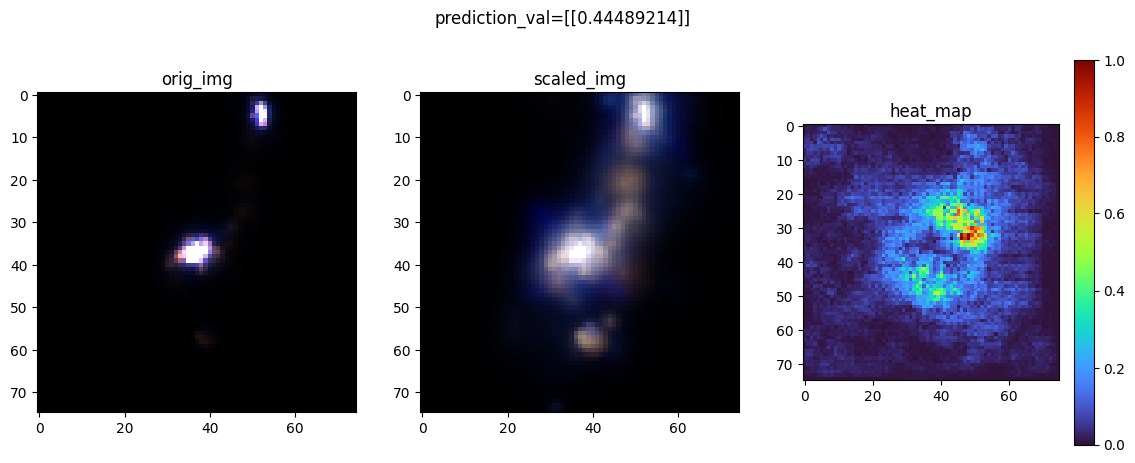

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

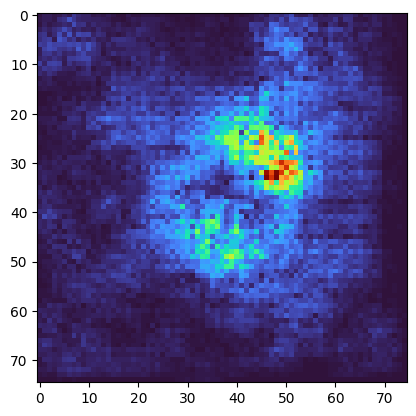

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-17 13:41:00.714146: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-17 13:41:01.549407: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-17 13:41:01.625435: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-17 13:41:01.669383: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-17 13:41:03.146583: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

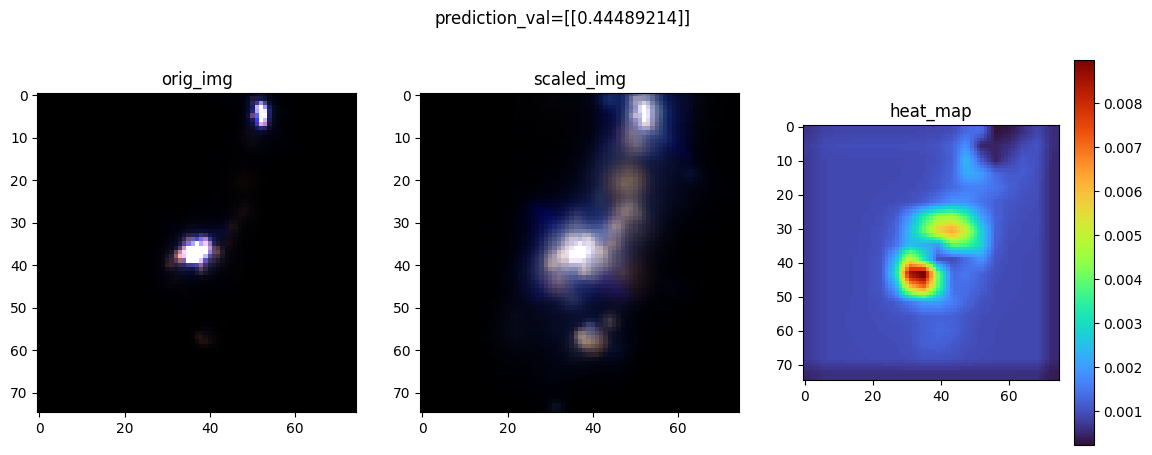

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

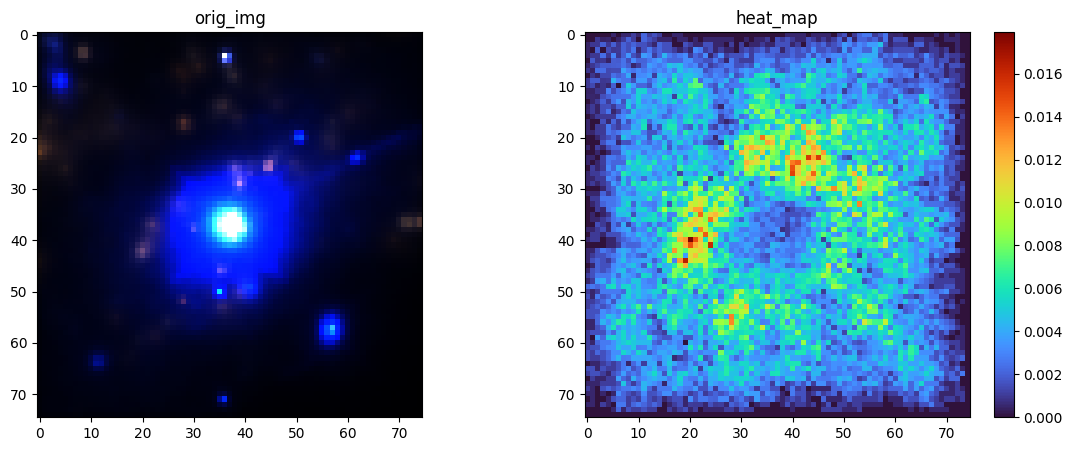

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:13 - loss: 0.7067 - accuracy: 0.6562

  2/338 [..............................] - ETA: 20s - loss: 0.7087 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 20s - loss: 0.7100 - accuracy: 0.4792

  4/338 [..............................] - ETA: 19s - loss: 0.7083 - accuracy: 0.5469

  5/338 [..............................] - ETA: 19s - loss: 0.7079 - accuracy: 0.5500

  6/338 [..............................] - ETA: 19s - loss: 0.7084 - accuracy: 0.5156

  7/338 [..............................] - ETA: 19s - loss: 0.7084 - accuracy: 0.5045

  8/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.5156

  9/338 [..............................] - ETA: 18s - loss: 0.7074 - accuracy: 0.5243

 10/338 [..............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5312

 11/338 [..............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5170

 12/338 [>.............................] - ETA: 18s - loss: 0.7066 - accuracy: 0.5234

 13/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5240

 14/338 [>.............................] - ETA: 18s - loss: 0.7060 - accuracy: 0.5268

 15/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5333

 16/338 [>.............................] - ETA: 18s - loss: 0.7052 - accuracy: 0.5391

 17/338 [>.............................] - ETA: 18s - loss: 0.7048 - accuracy: 0.5423

 18/338 [>.............................] - ETA: 18s - loss: 0.7047 - accuracy: 0.5399

 19/338 [>.............................] - ETA: 18s - loss: 0.7045 - accuracy: 0.5362

 20/338 [>.............................] - ETA: 18s - loss: 0.7044 - accuracy: 0.5328

 21/338 [>.............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.5327

 22/338 [>.............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.5412

 23/338 [=>............................] - ETA: 17s - loss: 0.7034 - accuracy: 0.5435

 24/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5443

 25/338 [=>............................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5437

 26/338 [=>............................] - ETA: 17s - loss: 0.7028 - accuracy: 0.5457

 27/338 [=>............................] - ETA: 17s - loss: 0.7024 - accuracy: 0.5486

 28/338 [=>............................] - ETA: 17s - loss: 0.7021 - accuracy: 0.5513

 29/338 [=>............................] - ETA: 17s - loss: 0.7019 - accuracy: 0.5517

 30/338 [=>............................] - ETA: 17s - loss: 0.7018 - accuracy: 0.5510

 31/338 [=>............................] - ETA: 17s - loss: 0.7017 - accuracy: 0.5494

 32/338 [=>............................] - ETA: 17s - loss: 0.7017 - accuracy: 0.5459

 33/338 [=>............................] - ETA: 17s - loss: 0.7014 - accuracy: 0.5492

 34/338 [==>...........................] - ETA: 17s - loss: 0.7012 - accuracy: 0.5487

 35/338 [==>...........................] - ETA: 17s - loss: 0.7011 - accuracy: 0.5482

 36/338 [==>...........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5451

 37/338 [==>...........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5422

 38/338 [==>...........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5403

 39/338 [==>...........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5409

 40/338 [==>...........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5398

 41/338 [==>...........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5379

 43/338 [==>...........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5371

 44/338 [==>...........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5334

 45/338 [==>...........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5368

 46/338 [===>..........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5387

 47/338 [===>..........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5392

 48/338 [===>..........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5378

 49/338 [===>..........................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5370

 50/338 [===>..........................] - ETA: 16s - loss: 0.6997 - accuracy: 0.5381

 51/338 [===>..........................] - ETA: 16s - loss: 0.6995 - accuracy: 0.5398

 52/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5397

 53/338 [===>..........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5389

 54/338 [===>..........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5382

 55/338 [===>..........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5364

 56/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5335

 57/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5334

 58/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5339

 59/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5344

 60/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5339

 61/338 [====>.........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5338

 62/338 [====>.........................] - ETA: 15s - loss: 0.6988 - accuracy: 0.5363

 63/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5367

 64/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5361

 65/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5341

 66/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5336

 67/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5336

 68/338 [=====>........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5345

 69/338 [=====>........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5331

 70/338 [=====>........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5335

 71/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5335

 72/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5339

 73/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5330

 74/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5329

 75/338 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5329

 76/338 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5329

 77/338 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5317

 78/338 [=====>........................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5325

 79/338 [======>.......................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5312

 80/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5324

 81/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5312

 82/338 [======>.......................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5324

 83/338 [======>.......................] - ETA: 14s - loss: 0.6976 - accuracy: 0.5346

 84/338 [======>.......................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5346

 85/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5349

 86/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5342

 87/338 [======>.......................] - ETA: 14s - loss: 0.6973 - accuracy: 0.5352

 88/338 [======>.......................] - ETA: 14s - loss: 0.6972 - accuracy: 0.5359

 89/338 [======>.......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5362

 90/338 [======>.......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5361

 91/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5340

 92/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5333

 93/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5319

 94/338 [=======>......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5293

 95/338 [=======>......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5289

 96/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5299

 97/338 [=======>......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5287

 98/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5290

 99/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5290

100/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5297

101/338 [=======>......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5309

102/338 [========>.....................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5312

103/338 [========>.....................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5309

104/338 [========>.....................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5316

105/338 [========>.....................] - ETA: 13s - loss: 0.6967 - accuracy: 0.5321

106/338 [========>.....................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5312

107/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5301

108/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5307

109/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5312

110/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5312

111/338 [========>.....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5315

112/338 [========>.....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5315

113/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5310

114/338 [=========>....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5326

115/338 [=========>....................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5334

116/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5337

117/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5326

118/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5334

119/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5318

120/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5320

121/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5320

122/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5325

123/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5333

124/338 [==========>...................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5335

125/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5320

126/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5310

127/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5315

128/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5303

129/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5296

130/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5291

131/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5289

132/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5296

133/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5296

134/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5303

135/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5301

136/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5299

137/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5292

138/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5290

139/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5288

140/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5283

141/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5281

142/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5282

143/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5284

144/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5286

145/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5274

146/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5278

147/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5270

148/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5262

149/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5260

150/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5258

151/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5255

152/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5251

153/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5243

154/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5254

155/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5242

156/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5236

157/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5239

158/338 [=============>................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5235

159/338 [=============>................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5246

160/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5244 

161/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5235

162/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5243

163/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5247

164/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5238

165/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5237

166/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5241

167/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5238

168/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5229

169/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5227

170/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5232

171/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5238

172/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5236

173/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5237

174/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5246

175/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5246

176/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5252

177/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5252

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5255

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5246

180/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5252

181/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5252

182/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5244

183/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5246

184/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5250

185/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5250

186/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5252

187/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5251

188/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5249

189/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5255

190/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5250

191/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5250

192/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5246

193/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5241

194/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5245

195/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5247

196/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5247

197/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5252

198/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5245

199/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5248

200/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5250

201/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5249

202/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5241

203/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5243

204/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5248

205/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5252

206/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5255

207/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5263

208/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5261

209/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5254

210/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5256

211/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5264

212/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5268

213/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5263

214/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5264

215/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5270

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5268

217/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5269

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5274

219/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5277

220/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5281

221/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5280

222/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5274

223/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5276

224/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5268

225/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5274

226/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5277

227/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5277

228/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5281

229/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5278

230/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5280

231/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5283

232/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5286

233/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5291

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5294

235/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5290

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5294

237/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5295

238/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5291

239/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5290

240/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5298

241/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5300

242/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5301

243/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5297

244/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5296

245/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5301

246/338 [====================>.........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5304

247/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5296

248/338 [=====================>........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5296

249/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5294

250/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5291

251/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5288

252/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5286

253/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5288

254/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5289

255/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5287

256/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5287

257/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5281

258/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5282

259/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5285

260/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5281

261/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5280

262/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5283

263/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5284

264/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5284

265/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5281

266/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5278

267/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5280

268/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

269/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5283

270/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

271/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5285

272/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5284

273/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5284

274/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5286

275/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5291

276/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5294

277/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5291

278/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5297

279/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5298

280/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5301

281/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5301

282/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5305

283/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5299

284/338 [========================>.....] - ETA: 3s - loss: 0.6935 - accuracy: 0.5295

285/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5296

286/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5295

287/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5297

288/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5299

289/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5303

290/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5300

291/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5294

292/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5294

293/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5295

294/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5291

295/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5293

296/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5297

297/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5296

298/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5294

299/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5293

300/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5293

301/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5292

302/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5296

303/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5295

304/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

305/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5292

306/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5292

307/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5288

308/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5286

309/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5283

310/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5284

311/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5283

312/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5286

313/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5283

314/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5281

315/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5281

316/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5280

317/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5282

318/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5278

319/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5279

320/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5278

321/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5279

322/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5282

323/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5286

324/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5285

325/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5290

326/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5294

327/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5291

328/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5288

329/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5286

330/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5284

331/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5283

332/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

333/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

334/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

336/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5274

338/338 [==============================] - 22s 61ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6920 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.7023 - accuracy: 0.4375

  2/338 [..............................] - ETA: 18s - loss: 0.6970 - accuracy: 0.5000

  3/338 [..............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.5312

  4/338 [..............................] - ETA: 18s - loss: 0.6919 - accuracy: 0.5156

  5/338 [..............................] - ETA: 18s - loss: 0.6932 - accuracy: 0.5063

  6/338 [..............................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5052

  7/338 [..............................] - ETA: 18s - loss: 0.6922 - accuracy: 0.5134

  8/338 [..............................] - ETA: 18s - loss: 0.6931 - accuracy: 0.4961

  9/338 [..............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5069

 10/338 [..............................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5031

 11/338 [..............................] - ETA: 18s - loss: 0.6936 - accuracy: 0.4886

 12/338 [>.............................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5000

 13/338 [>.............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5072

 14/338 [>.............................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5112

 15/338 [>.............................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5042

 16/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5117

 17/338 [>.............................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5037

 18/338 [>.............................] - ETA: 17s - loss: 0.6914 - accuracy: 0.5017

 19/338 [>.............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5033

 20/338 [>.............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5000

 21/338 [>.............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.4985

 22/338 [>.............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.4986

 23/338 [=>............................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5014

 24/338 [=>............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5039

 25/338 [=>............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5025

 26/338 [=>............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.4988

 27/338 [=>............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5035

 28/338 [=>............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5056

 29/338 [=>............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5022

 30/338 [=>............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5052

 31/338 [=>............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5060

 32/338 [=>............................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5000

 33/338 [=>............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5028

 34/338 [==>...........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5000

 35/338 [==>...........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5009

 36/338 [==>...........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.4991

 37/338 [==>...........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.4949

 38/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.4959

 39/338 [==>...........................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5000

 40/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5008

 41/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5000

 42/338 [==>...........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5045

 43/338 [==>...........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5044

 44/338 [==>...........................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5036

 45/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.4993

 46/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.4946

 47/338 [===>..........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.4967

 48/338 [===>..........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.4974

 49/338 [===>..........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.4955

 50/338 [===>..........................] - ETA: 16s - loss: 0.6901 - accuracy: 0.4981

 51/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5031

 52/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5060

 53/338 [===>..........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5094

 54/338 [===>..........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5116

 55/338 [===>..........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5159

 56/338 [===>..........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5190

 57/338 [====>.........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5170

 58/338 [====>.........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5199

 59/338 [====>.........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5222

 60/338 [====>.........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5219

 61/338 [====>.........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5236

 62/338 [====>.........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5242

 63/338 [====>.........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5238

 64/338 [====>.........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5264

 65/338 [====>.........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5312

 66/338 [====>.........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5322

 67/338 [====>.........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5336

 68/338 [=====>........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5340

 69/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5371

 70/338 [=====>........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5384

 71/338 [=====>........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5401

 72/338 [=====>........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5399

 73/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5394

 74/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5401

 75/338 [=====>........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5421

 76/338 [=====>........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5424

 77/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5422

 78/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5433

 79/338 [======>.......................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5439

 80/338 [======>.......................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5457

 81/338 [======>.......................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5486

 82/338 [======>.......................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5507

 83/338 [======>.......................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5520

 84/338 [======>.......................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5536

 85/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5544

 86/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5556

 87/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5568

 88/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5586

 89/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5572

 90/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5590

 91/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5604

 92/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5618

 93/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5625

 94/338 [=======>......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5628

 95/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5625

 96/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5612

 97/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5625

 98/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5635

 99/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5644

100/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5644

101/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5650

102/338 [========>.....................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5671

103/338 [========>.....................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5677

104/338 [========>.....................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5700

105/338 [========>.....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5714

106/338 [========>.....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5716

107/338 [========>.....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5718

108/338 [========>.....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5726

109/338 [========>.....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5740

110/338 [========>.....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5744

111/338 [========>.....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5749

112/338 [========>.....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5756

113/338 [=========>....................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5766

114/338 [=========>....................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5779

115/338 [=========>....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5788

116/338 [=========>....................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5803

117/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5807

118/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5808

119/338 [=========>....................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5801

120/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5805

121/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5803

122/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5815

123/338 [=========>....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5821

124/338 [==========>...................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5824

125/338 [==========>...................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5820

126/338 [==========>...................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5826

127/338 [==========>...................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5846

128/338 [==========>...................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5847

129/338 [==========>...................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5853

130/338 [==========>...................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5856

131/338 [==========>...................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5854

132/338 [==========>...................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5855

133/338 [==========>...................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5855

134/338 [==========>...................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5851

135/338 [==========>...................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5854

136/338 [===========>..................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5846

137/338 [===========>..................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5839

138/338 [===========>..................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5838

139/338 [===========>..................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5839

140/338 [===========>..................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5835

141/338 [===========>..................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5833

142/338 [===========>..................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5843

143/338 [===========>..................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5846

144/338 [===========>..................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5857

145/338 [===========>..................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5871

146/338 [===========>..................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5878

147/338 [============>.................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5880

148/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5880

149/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5883

150/338 [============>.................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5883

151/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5896

152/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5898

153/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5905

154/338 [============>.................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5911

155/338 [============>.................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5917

156/338 [============>.................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5913

157/338 [============>.................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5912

158/338 [=============>................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5918

159/338 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5922 

160/338 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5924

161/338 [=============>................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5928

162/338 [=============>................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5928

163/338 [=============>................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5934

164/338 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5924

165/338 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5928

166/338 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5926

167/338 [=============>................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5936

168/338 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5930

169/338 [==============>...............] - ETA: 9s - loss: 0.6855 - accuracy: 0.5930

170/338 [==============>...............] - ETA: 9s - loss: 0.6856 - accuracy: 0.5923

171/338 [==============>...............] - ETA: 9s - loss: 0.6857 - accuracy: 0.5914

172/338 [==============>...............] - ETA: 9s - loss: 0.6857 - accuracy: 0.5918

173/338 [==============>...............] - ETA: 9s - loss: 0.6857 - accuracy: 0.5918

174/338 [==============>...............] - ETA: 9s - loss: 0.6856 - accuracy: 0.5918

175/338 [==============>...............] - ETA: 9s - loss: 0.6857 - accuracy: 0.5916

176/338 [==============>...............] - ETA: 9s - loss: 0.6857 - accuracy: 0.5913

177/338 [==============>...............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5913

178/338 [==============>...............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5913

179/338 [==============>...............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5917

180/338 [==============>...............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5915

181/338 [===============>..............] - ETA: 8s - loss: 0.6855 - accuracy: 0.5917

182/338 [===============>..............] - ETA: 8s - loss: 0.6855 - accuracy: 0.5925

183/338 [===============>..............] - ETA: 8s - loss: 0.6855 - accuracy: 0.5926

184/338 [===============>..............] - ETA: 8s - loss: 0.6855 - accuracy: 0.5924

185/338 [===============>..............] - ETA: 8s - loss: 0.6855 - accuracy: 0.5919

186/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5916

187/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5917

188/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5918

189/338 [===============>..............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5911

190/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5914

191/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5916

192/338 [================>.............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5911

193/338 [================>.............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5912

194/338 [================>.............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5910

195/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5910

196/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5912

197/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5914

198/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5915

199/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5919

200/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5919

201/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5928

202/338 [================>.............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5931

203/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5930

204/338 [=================>............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5933

205/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5931

206/338 [=================>............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5936

207/338 [=================>............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5941

208/338 [=================>............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5945

209/338 [=================>............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5942

210/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5940

211/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5942

212/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5939

213/338 [=================>............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5943

214/338 [=================>............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5951

215/338 [==================>...........] - ETA: 6s - loss: 0.6850 - accuracy: 0.5959

216/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5956

217/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5958

218/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5955

219/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5957

220/338 [==================>...........] - ETA: 6s - loss: 0.6850 - accuracy: 0.5959

221/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5954

222/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5956

223/338 [==================>...........] - ETA: 6s - loss: 0.6850 - accuracy: 0.5960

224/338 [==================>...........] - ETA: 6s - loss: 0.6849 - accuracy: 0.5965

225/338 [==================>...........] - ETA: 6s - loss: 0.6849 - accuracy: 0.5965

226/338 [===================>..........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5973

227/338 [===================>..........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5971

228/338 [===================>..........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5972

229/338 [===================>..........] - ETA: 6s - loss: 0.6849 - accuracy: 0.5966

230/338 [===================>..........] - ETA: 5s - loss: 0.6849 - accuracy: 0.5963

231/338 [===================>..........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5966

232/338 [===================>..........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5967

233/338 [===================>..........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5967

234/338 [===================>..........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5970

235/338 [===================>..........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5969

236/338 [===================>..........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5973

237/338 [====================>.........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5967

238/338 [====================>.........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5972

239/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5969

240/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5973

241/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5975

242/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5979

243/338 [====================>.........] - ETA: 5s - loss: 0.6846 - accuracy: 0.5981

244/338 [====================>.........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5972

245/338 [====================>.........] - ETA: 5s - loss: 0.6848 - accuracy: 0.5974

246/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5973

247/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5973

248/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5977

249/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5980

250/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5976

251/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5976

252/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5975

253/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5973

254/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5973

255/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5974

256/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5974

257/338 [=====================>........] - ETA: 4s - loss: 0.6846 - accuracy: 0.5980

258/338 [=====================>........] - ETA: 4s - loss: 0.6846 - accuracy: 0.5979

259/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5972

260/338 [======================>.......] - ETA: 4s - loss: 0.6846 - accuracy: 0.5978

261/338 [======================>.......] - ETA: 4s - loss: 0.6845 - accuracy: 0.5981

262/338 [======================>.......] - ETA: 4s - loss: 0.6845 - accuracy: 0.5980

263/338 [======================>.......] - ETA: 4s - loss: 0.6845 - accuracy: 0.5985

264/338 [======================>.......] - ETA: 4s - loss: 0.6845 - accuracy: 0.5988

265/338 [======================>.......] - ETA: 4s - loss: 0.6844 - accuracy: 0.5993

266/338 [======================>.......] - ETA: 3s - loss: 0.6843 - accuracy: 0.5999

267/338 [======================>.......] - ETA: 3s - loss: 0.6843 - accuracy: 0.6000

268/338 [======================>.......] - ETA: 3s - loss: 0.6843 - accuracy: 0.5999

269/338 [======================>.......] - ETA: 3s - loss: 0.6842 - accuracy: 0.6000

270/338 [======================>.......] - ETA: 3s - loss: 0.6842 - accuracy: 0.6003

271/338 [=======================>......] - ETA: 3s - loss: 0.6841 - accuracy: 0.6009

272/338 [=======================>......] - ETA: 3s - loss: 0.6841 - accuracy: 0.6006

273/338 [=======================>......] - ETA: 3s - loss: 0.6841 - accuracy: 0.6007

274/338 [=======================>......] - ETA: 3s - loss: 0.6840 - accuracy: 0.6010

275/338 [=======================>......] - ETA: 3s - loss: 0.6840 - accuracy: 0.6016

276/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.6017

277/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.6023

278/338 [=======================>......] - ETA: 3s - loss: 0.6838 - accuracy: 0.6029

279/338 [=======================>......] - ETA: 3s - loss: 0.6838 - accuracy: 0.6024

280/338 [=======================>......] - ETA: 3s - loss: 0.6837 - accuracy: 0.6028

281/338 [=======================>......] - ETA: 3s - loss: 0.6837 - accuracy: 0.6032

282/338 [========================>.....] - ETA: 3s - loss: 0.6837 - accuracy: 0.6033

283/338 [========================>.....] - ETA: 3s - loss: 0.6835 - accuracy: 0.6038

284/338 [========================>.....] - ETA: 2s - loss: 0.6834 - accuracy: 0.6042

285/338 [========================>.....] - ETA: 2s - loss: 0.6834 - accuracy: 0.6045

286/338 [========================>.....] - ETA: 2s - loss: 0.6834 - accuracy: 0.6042

287/338 [========================>.....] - ETA: 2s - loss: 0.6834 - accuracy: 0.6044

288/338 [========================>.....] - ETA: 2s - loss: 0.6834 - accuracy: 0.6045

289/338 [========================>.....] - ETA: 2s - loss: 0.6834 - accuracy: 0.6047

290/338 [========================>.....] - ETA: 2s - loss: 0.6833 - accuracy: 0.6050

291/338 [========================>.....] - ETA: 2s - loss: 0.6833 - accuracy: 0.6051

292/338 [========================>.....] - ETA: 2s - loss: 0.6832 - accuracy: 0.6056

293/338 [=========================>....] - ETA: 2s - loss: 0.6832 - accuracy: 0.6056

294/338 [=========================>....] - ETA: 2s - loss: 0.6832 - accuracy: 0.6059

295/338 [=========================>....] - ETA: 2s - loss: 0.6831 - accuracy: 0.6064

296/338 [=========================>....] - ETA: 2s - loss: 0.6831 - accuracy: 0.6064

297/338 [=========================>....] - ETA: 2s - loss: 0.6831 - accuracy: 0.6064

298/338 [=========================>....] - ETA: 2s - loss: 0.6831 - accuracy: 0.6062

299/338 [=========================>....] - ETA: 2s - loss: 0.6830 - accuracy: 0.6067

300/338 [=========================>....] - ETA: 2s - loss: 0.6830 - accuracy: 0.6066

301/338 [=========================>....] - ETA: 2s - loss: 0.6830 - accuracy: 0.6065

302/338 [=========================>....] - ETA: 1s - loss: 0.6830 - accuracy: 0.6068

303/338 [=========================>....] - ETA: 1s - loss: 0.6829 - accuracy: 0.6074

304/338 [=========================>....] - ETA: 1s - loss: 0.6828 - accuracy: 0.6075

305/338 [==========================>...] - ETA: 1s - loss: 0.6828 - accuracy: 0.6077

306/338 [==========================>...] - ETA: 1s - loss: 0.6828 - accuracy: 0.6078

307/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.6079

308/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.6082

309/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.6086

310/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.6083

311/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.6079

312/338 [==========================>...] - ETA: 1s - loss: 0.6826 - accuracy: 0.6085

313/338 [==========================>...] - ETA: 1s - loss: 0.6826 - accuracy: 0.6083

314/338 [==========================>...] - ETA: 1s - loss: 0.6825 - accuracy: 0.6088

315/338 [==========================>...] - ETA: 1s - loss: 0.6825 - accuracy: 0.6087

316/338 [===========================>..] - ETA: 1s - loss: 0.6824 - accuracy: 0.6091

317/338 [===========================>..] - ETA: 1s - loss: 0.6824 - accuracy: 0.6093

318/338 [===========================>..] - ETA: 1s - loss: 0.6824 - accuracy: 0.6096

319/338 [===========================>..] - ETA: 1s - loss: 0.6824 - accuracy: 0.6097

320/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.6096

321/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.6098

322/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.6097

323/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.6093

324/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.6096

325/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.6097

326/338 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.6098

327/338 [============================>.] - ETA: 0s - loss: 0.6824 - accuracy: 0.6097

328/338 [============================>.] - ETA: 0s - loss: 0.6824 - accuracy: 0.6098

329/338 [============================>.] - ETA: 0s - loss: 0.6824 - accuracy: 0.6095

330/338 [============================>.] - ETA: 0s - loss: 0.6824 - accuracy: 0.6097

331/338 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.6098

332/338 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.6098

333/338 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.6101

334/338 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.6097

335/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.6099

336/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.6104

337/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.6104

338/338 [==============================] - 20s 60ms/step - loss: 0.6821 - accuracy: 0.6107 - val_loss: 0.6777 - val_accuracy: 0.6108


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6797 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5625

  3/338 [..............................] - ETA: 18s - loss: 0.6820 - accuracy: 0.5625

  4/338 [..............................] - ETA: 18s - loss: 0.6833 - accuracy: 0.5625

  5/338 [..............................] - ETA: 18s - loss: 0.6820 - accuracy: 0.5688

  6/338 [..............................] - ETA: 18s - loss: 0.6808 - accuracy: 0.5781

  7/338 [..............................] - ETA: 18s - loss: 0.6788 - accuracy: 0.5982

  8/338 [..............................] - ETA: 18s - loss: 0.6779 - accuracy: 0.5977

  9/338 [..............................] - ETA: 18s - loss: 0.6767 - accuracy: 0.6042

 10/338 [..............................] - ETA: 18s - loss: 0.6762 - accuracy: 0.6156

 11/338 [..............................] - ETA: 18s - loss: 0.6754 - accuracy: 0.6193

 12/338 [>.............................] - ETA: 18s - loss: 0.6737 - accuracy: 0.6302

 13/338 [>.............................] - ETA: 18s - loss: 0.6731 - accuracy: 0.6322

 14/338 [>.............................] - ETA: 18s - loss: 0.6735 - accuracy: 0.6317

 15/338 [>.............................] - ETA: 17s - loss: 0.6724 - accuracy: 0.6375

 16/338 [>.............................] - ETA: 17s - loss: 0.6721 - accuracy: 0.6406

 17/338 [>.............................] - ETA: 17s - loss: 0.6729 - accuracy: 0.6360

 18/338 [>.............................] - ETA: 17s - loss: 0.6736 - accuracy: 0.6319

 19/338 [>.............................] - ETA: 17s - loss: 0.6749 - accuracy: 0.6250

 20/338 [>.............................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6266

 21/338 [>.............................] - ETA: 17s - loss: 0.6741 - accuracy: 0.6295

 22/338 [>.............................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6264

 23/338 [=>............................] - ETA: 17s - loss: 0.6755 - accuracy: 0.6250

 24/338 [=>............................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6250

 25/338 [=>............................] - ETA: 17s - loss: 0.6760 - accuracy: 0.6237

 26/338 [=>............................] - ETA: 17s - loss: 0.6758 - accuracy: 0.6250

 27/338 [=>............................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6262

 28/338 [=>............................] - ETA: 17s - loss: 0.6753 - accuracy: 0.6295

 29/338 [=>............................] - ETA: 17s - loss: 0.6754 - accuracy: 0.6293

 30/338 [=>............................] - ETA: 17s - loss: 0.6763 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 17s - loss: 0.6768 - accuracy: 0.6211

 33/338 [=>............................] - ETA: 17s - loss: 0.6766 - accuracy: 0.6241

 34/338 [==>...........................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6259

 35/338 [==>...........................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6277

 36/338 [==>...........................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6293

 37/338 [==>...........................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6343

 38/338 [==>...........................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6406

 39/338 [==>...........................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6418

 40/338 [==>...........................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6422

 41/338 [==>...........................] - ETA: 16s - loss: 0.6733 - accuracy: 0.6441

 42/338 [==>...........................] - ETA: 16s - loss: 0.6730 - accuracy: 0.6466

 43/338 [==>...........................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6439

 44/338 [==>...........................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6392

 45/338 [==>...........................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6396

 46/338 [===>..........................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6406

 47/338 [===>..........................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6410

 48/338 [===>..........................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6400

 49/338 [===>..........................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6390

 50/338 [===>..........................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6400

 51/338 [===>..........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6434

 52/338 [===>..........................] - ETA: 15s - loss: 0.6727 - accuracy: 0.6454

 53/338 [===>..........................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6439

 54/338 [===>..........................] - ETA: 15s - loss: 0.6735 - accuracy: 0.6412

 55/338 [===>..........................] - ETA: 15s - loss: 0.6734 - accuracy: 0.6415

 56/338 [===>..........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6406

 57/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6404

 58/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6395

 59/338 [====>.........................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6382

 60/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6391

 61/338 [====>.........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6393

 62/338 [====>.........................] - ETA: 15s - loss: 0.6734 - accuracy: 0.6411

 63/338 [====>.........................] - ETA: 15s - loss: 0.6733 - accuracy: 0.6409

 64/338 [====>.........................] - ETA: 15s - loss: 0.6733 - accuracy: 0.6401

 65/338 [====>.........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6409

 66/338 [====>.........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6402

 67/338 [====>.........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6404

 68/338 [=====>........................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6406

 69/338 [=====>........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6395

 70/338 [=====>........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6393

 71/338 [=====>........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6395

 72/338 [=====>........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6415

 73/338 [=====>........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6413

 74/338 [=====>........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6410

 75/338 [=====>........................] - ETA: 14s - loss: 0.6728 - accuracy: 0.6396

 76/338 [=====>........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6410

 77/338 [=====>........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6416

 78/338 [=====>........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6414

 79/338 [======>.......................] - ETA: 14s - loss: 0.6728 - accuracy: 0.6396

 80/338 [======>.......................] - ETA: 14s - loss: 0.6730 - accuracy: 0.6395

 81/338 [======>.......................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6412

 82/338 [======>.......................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6418

 83/338 [======>.......................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6419

 84/338 [======>.......................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6417

 85/338 [======>.......................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6408

 86/338 [======>.......................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6406

 87/338 [======>.......................] - ETA: 14s - loss: 0.6722 - accuracy: 0.6419

 88/338 [======>.......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6428

 89/338 [======>.......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6429

 90/338 [======>.......................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6417

 91/338 [=======>......................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6418

 92/338 [=======>......................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6420

 93/338 [=======>......................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6418

 94/338 [=======>......................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6413

 95/338 [=======>......................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6411

 96/338 [=======>......................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6406

 97/338 [=======>......................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6405

 98/338 [=======>......................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6390

 99/338 [=======>......................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6389

100/338 [=======>......................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6394

101/338 [=======>......................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6402

102/338 [========>.....................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6403

103/338 [========>.....................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6399

104/338 [========>.....................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6394

105/338 [========>.....................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6399

106/338 [========>.....................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6392

107/338 [========>.....................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6387

108/338 [========>.....................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6392

109/338 [========>.....................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6419

110/338 [========>.....................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6418

111/338 [========>.....................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6408

112/338 [========>.....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6403

113/338 [=========>....................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6408

114/338 [=========>....................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6406

115/338 [=========>....................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6408

116/338 [=========>....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6412

117/338 [=========>....................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6402

118/338 [=========>....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6393

119/338 [=========>....................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6381

120/338 [=========>....................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6372

121/338 [=========>....................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6377

122/338 [=========>....................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6376

123/338 [=========>....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6387

124/338 [==========>...................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6389

125/338 [==========>...................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6390

126/338 [==========>...................] - ETA: 11s - loss: 0.6714 - accuracy: 0.6406

127/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6410

128/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6409

129/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6407

130/338 [==========>...................] - ETA: 11s - loss: 0.6710 - accuracy: 0.6409

131/338 [==========>...................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6412

132/338 [==========>...................] - ETA: 11s - loss: 0.6707 - accuracy: 0.6416

133/338 [==========>...................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6417

134/338 [==========>...................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6418

135/338 [==========>...................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6410

136/338 [===========>..................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6411

137/338 [===========>..................] - ETA: 11s - loss: 0.6705 - accuracy: 0.6414

138/338 [===========>..................] - ETA: 11s - loss: 0.6703 - accuracy: 0.6424

139/338 [===========>..................] - ETA: 11s - loss: 0.6701 - accuracy: 0.6430

140/338 [===========>..................] - ETA: 11s - loss: 0.6701 - accuracy: 0.6429

141/338 [===========>..................] - ETA: 10s - loss: 0.6702 - accuracy: 0.6425

142/338 [===========>..................] - ETA: 10s - loss: 0.6699 - accuracy: 0.6435

143/338 [===========>..................] - ETA: 10s - loss: 0.6700 - accuracy: 0.6429

144/338 [===========>..................] - ETA: 10s - loss: 0.6699 - accuracy: 0.6432

145/338 [===========>..................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6435

146/338 [===========>..................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6445

147/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6450

148/338 [============>.................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6453

149/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6449

150/338 [============>.................] - ETA: 10s - loss: 0.6692 - accuracy: 0.6454

151/338 [============>.................] - ETA: 10s - loss: 0.6692 - accuracy: 0.6453

152/338 [============>.................] - ETA: 10s - loss: 0.6691 - accuracy: 0.6458

153/338 [============>.................] - ETA: 10s - loss: 0.6690 - accuracy: 0.6458

154/338 [============>.................] - ETA: 10s - loss: 0.6689 - accuracy: 0.6465

155/338 [============>.................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6470

156/338 [============>.................] - ETA: 10s - loss: 0.6685 - accuracy: 0.6474

157/338 [============>.................] - ETA: 10s - loss: 0.6686 - accuracy: 0.6475

158/338 [=============>................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6481

159/338 [=============>................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6484 

160/338 [=============>................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6492

161/338 [=============>................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6495

162/338 [=============>................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6495

163/338 [=============>................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6495

164/338 [=============>................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6492

165/338 [=============>................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6485

166/338 [=============>................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6483

167/338 [=============>................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6490

168/338 [=============>................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6490

169/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6500

170/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6502

171/338 [==============>...............] - ETA: 9s - loss: 0.6675 - accuracy: 0.6502

172/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6499

173/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6497

174/338 [==============>...............] - ETA: 9s - loss: 0.6676 - accuracy: 0.6496

175/338 [==============>...............] - ETA: 9s - loss: 0.6675 - accuracy: 0.6498

176/338 [==============>...............] - ETA: 9s - loss: 0.6675 - accuracy: 0.6495

177/338 [==============>...............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6501

178/338 [==============>...............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6501

179/338 [==============>...............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6508

180/338 [==============>...............] - ETA: 8s - loss: 0.6673 - accuracy: 0.6505

181/338 [===============>..............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6511

182/338 [===============>..............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6516

183/338 [===============>..............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6520

184/338 [===============>..............] - ETA: 8s - loss: 0.6667 - accuracy: 0.6522

185/338 [===============>..............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6515

186/338 [===============>..............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6512

187/338 [===============>..............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6511

188/338 [===============>..............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6511

189/338 [===============>..............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6505

190/338 [===============>..............] - ETA: 8s - loss: 0.6671 - accuracy: 0.6508

191/338 [===============>..............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6513

192/338 [================>.............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6517

193/338 [================>.............] - ETA: 8s - loss: 0.6667 - accuracy: 0.6519

194/338 [================>.............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6522

195/338 [================>.............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6521

196/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6519

197/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6516

198/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6518

199/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6517

200/338 [================>.............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6517

201/338 [================>.............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6519

202/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6511

203/338 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6515

204/338 [=================>............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6513

205/338 [=================>............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6512

206/338 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6509

207/338 [=================>............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6501

208/338 [=================>............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6501

209/338 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6507

210/338 [=================>............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6504

211/338 [=================>............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6502

212/338 [=================>............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6496

213/338 [=================>............] - ETA: 6s - loss: 0.6670 - accuracy: 0.6496

214/338 [=================>............] - ETA: 6s - loss: 0.6672 - accuracy: 0.6491

215/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6487

216/338 [==================>...........] - ETA: 6s - loss: 0.6672 - accuracy: 0.6487

217/338 [==================>...........] - ETA: 6s - loss: 0.6670 - accuracy: 0.6493

218/338 [==================>...........] - ETA: 6s - loss: 0.6672 - accuracy: 0.6488

219/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6484

220/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6482

221/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6482

222/338 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6477

223/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6478

224/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6479

225/338 [==================>...........] - ETA: 6s - loss: 0.6675 - accuracy: 0.6472

226/338 [===================>..........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6463

227/338 [===================>..........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6462

228/338 [===================>..........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6462

229/338 [===================>..........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6460

230/338 [===================>..........] - ETA: 6s - loss: 0.6678 - accuracy: 0.6458

231/338 [===================>..........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6461

232/338 [===================>..........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6466

233/338 [===================>..........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6470

234/338 [===================>..........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6473

235/338 [===================>..........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6473

236/338 [===================>..........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6474

237/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6473

238/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6473

239/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6474

240/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6475

241/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6473

242/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6471

243/338 [====================>.........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6467

244/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6472

245/338 [====================>.........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6464

246/338 [====================>.........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6461

247/338 [====================>.........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6461

248/338 [=====================>........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6464

249/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6470

250/338 [=====================>........] - ETA: 4s - loss: 0.6671 - accuracy: 0.6474

251/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6468

252/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6467

253/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6466

254/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6460

255/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6461

256/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6462

257/338 [=====================>........] - ETA: 4s - loss: 0.6671 - accuracy: 0.6466

258/338 [=====================>........] - ETA: 4s - loss: 0.6670 - accuracy: 0.6469

259/338 [=====================>........] - ETA: 4s - loss: 0.6669 - accuracy: 0.6471

260/338 [======================>.......] - ETA: 4s - loss: 0.6668 - accuracy: 0.6474

261/338 [======================>.......] - ETA: 4s - loss: 0.6668 - accuracy: 0.6473

262/338 [======================>.......] - ETA: 4s - loss: 0.6668 - accuracy: 0.6471

263/338 [======================>.......] - ETA: 4s - loss: 0.6666 - accuracy: 0.6477

264/338 [======================>.......] - ETA: 4s - loss: 0.6666 - accuracy: 0.6475

265/338 [======================>.......] - ETA: 4s - loss: 0.6665 - accuracy: 0.6478

266/338 [======================>.......] - ETA: 4s - loss: 0.6664 - accuracy: 0.6479

267/338 [======================>.......] - ETA: 3s - loss: 0.6664 - accuracy: 0.6478

268/338 [======================>.......] - ETA: 3s - loss: 0.6661 - accuracy: 0.6484

269/338 [======================>.......] - ETA: 3s - loss: 0.6661 - accuracy: 0.6486

270/338 [======================>.......] - ETA: 3s - loss: 0.6661 - accuracy: 0.6486

271/338 [=======================>......] - ETA: 3s - loss: 0.6661 - accuracy: 0.6486

272/338 [=======================>......] - ETA: 3s - loss: 0.6660 - accuracy: 0.6489

273/338 [=======================>......] - ETA: 3s - loss: 0.6661 - accuracy: 0.6487

274/338 [=======================>......] - ETA: 3s - loss: 0.6660 - accuracy: 0.6488

275/338 [=======================>......] - ETA: 3s - loss: 0.6660 - accuracy: 0.6488

276/338 [=======================>......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6493

277/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6497

278/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6498

279/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6496

280/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6496

281/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6495

282/338 [========================>.....] - ETA: 3s - loss: 0.6656 - accuracy: 0.6495

283/338 [========================>.....] - ETA: 3s - loss: 0.6656 - accuracy: 0.6494

284/338 [========================>.....] - ETA: 3s - loss: 0.6655 - accuracy: 0.6494

285/338 [========================>.....] - ETA: 2s - loss: 0.6655 - accuracy: 0.6493

286/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6491

287/338 [========================>.....] - ETA: 2s - loss: 0.6657 - accuracy: 0.6487

288/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6488

289/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6487

290/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6486

291/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6483

292/338 [========================>.....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6484

293/338 [=========================>....] - ETA: 2s - loss: 0.6655 - accuracy: 0.6485

294/338 [=========================>....] - ETA: 2s - loss: 0.6657 - accuracy: 0.6481

295/338 [=========================>....] - ETA: 2s - loss: 0.6660 - accuracy: 0.6470

296/338 [=========================>....] - ETA: 2s - loss: 0.6662 - accuracy: 0.6463

297/338 [=========================>....] - ETA: 2s - loss: 0.6662 - accuracy: 0.6461

298/338 [=========================>....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6456

299/338 [=========================>....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6452

300/338 [=========================>....] - ETA: 2s - loss: 0.6663 - accuracy: 0.6454

301/338 [=========================>....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6449

302/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6441

303/338 [=========================>....] - ETA: 1s - loss: 0.6668 - accuracy: 0.6438

304/338 [=========================>....] - ETA: 1s - loss: 0.6669 - accuracy: 0.6434

305/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6432

306/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6430

307/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6425

308/338 [==========================>...] - ETA: 1s - loss: 0.6671 - accuracy: 0.6423

309/338 [==========================>...] - ETA: 1s - loss: 0.6671 - accuracy: 0.6424

310/338 [==========================>...] - ETA: 1s - loss: 0.6671 - accuracy: 0.6425

311/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6428

312/338 [==========================>...] - ETA: 1s - loss: 0.6670 - accuracy: 0.6426

313/338 [==========================>...] - ETA: 1s - loss: 0.6672 - accuracy: 0.6420

314/338 [==========================>...] - ETA: 1s - loss: 0.6673 - accuracy: 0.6414

315/338 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.6411

316/338 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.6409

317/338 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.6407

318/338 [===========================>..] - ETA: 1s - loss: 0.6673 - accuracy: 0.6409

319/338 [===========================>..] - ETA: 1s - loss: 0.6673 - accuracy: 0.6411

320/338 [===========================>..] - ETA: 1s - loss: 0.6672 - accuracy: 0.6411

321/338 [===========================>..] - ETA: 0s - loss: 0.6672 - accuracy: 0.6408

322/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6403

323/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6398

324/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6398

325/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6396

326/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6396

327/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6392

328/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6399

329/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6397

330/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6397

331/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6398

332/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6399

333/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6397

334/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6401

335/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6401

336/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6403

337/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6406

338/338 [==============================] - 20s 60ms/step - loss: 0.6670 - accuracy: 0.6405 - val_loss: 0.6545 - val_accuracy: 0.6659


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6479 - accuracy: 0.6875

  2/338 [..............................] - ETA: 18s - loss: 0.6886 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6797 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6681 - accuracy: 0.6484

  5/338 [..............................] - ETA: 18s - loss: 0.6639 - accuracy: 0.6625

  6/338 [..............................] - ETA: 18s - loss: 0.6642 - accuracy: 0.6615

  7/338 [..............................] - ETA: 18s - loss: 0.6677 - accuracy: 0.6429

  8/338 [..............................] - ETA: 18s - loss: 0.6630 - accuracy: 0.6445

  9/338 [..............................] - ETA: 18s - loss: 0.6604 - accuracy: 0.6493

 10/338 [..............................] - ETA: 18s - loss: 0.6632 - accuracy: 0.6344

 11/338 [..............................] - ETA: 18s - loss: 0.6600 - accuracy: 0.6420

 12/338 [>.............................] - ETA: 18s - loss: 0.6636 - accuracy: 0.6354

 13/338 [>.............................] - ETA: 17s - loss: 0.6634 - accuracy: 0.6370

 14/338 [>.............................] - ETA: 17s - loss: 0.6639 - accuracy: 0.6317

 15/338 [>.............................] - ETA: 17s - loss: 0.6606 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 17s - loss: 0.6574 - accuracy: 0.6523

 17/338 [>.............................] - ETA: 17s - loss: 0.6528 - accuracy: 0.6654

 18/338 [>.............................] - ETA: 17s - loss: 0.6524 - accuracy: 0.6632

 19/338 [>.............................] - ETA: 17s - loss: 0.6548 - accuracy: 0.6595

 20/338 [>.............................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6594

 21/338 [>.............................] - ETA: 17s - loss: 0.6555 - accuracy: 0.6592

 22/338 [>.............................] - ETA: 17s - loss: 0.6557 - accuracy: 0.6577

 23/338 [=>............................] - ETA: 17s - loss: 0.6552 - accuracy: 0.6590

 24/338 [=>............................] - ETA: 17s - loss: 0.6537 - accuracy: 0.6628

 25/338 [=>............................] - ETA: 17s - loss: 0.6541 - accuracy: 0.6612

 26/338 [=>............................] - ETA: 17s - loss: 0.6541 - accuracy: 0.6611

 27/338 [=>............................] - ETA: 17s - loss: 0.6539 - accuracy: 0.6620

 28/338 [=>............................] - ETA: 17s - loss: 0.6558 - accuracy: 0.6574

 29/338 [=>............................] - ETA: 17s - loss: 0.6555 - accuracy: 0.6562

 30/338 [=>............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6604

 31/338 [=>............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6613

 32/338 [=>............................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6582

 33/338 [=>............................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6572

 34/338 [==>...........................] - ETA: 16s - loss: 0.6539 - accuracy: 0.6581

 35/338 [==>...........................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6589

 36/338 [==>...........................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6580

 37/338 [==>...........................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6588

 38/338 [==>...........................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6562

 39/338 [==>...........................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6587

 40/338 [==>...........................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6602

 41/338 [==>...........................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6570

 42/338 [==>...........................] - ETA: 16s - loss: 0.6563 - accuracy: 0.6548

 43/338 [==>...........................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6548

 44/338 [==>...........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6562

 45/338 [==>...........................] - ETA: 16s - loss: 0.6550 - accuracy: 0.6576

 46/338 [===>..........................] - ETA: 16s - loss: 0.6541 - accuracy: 0.6583

 47/338 [===>..........................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6582

 48/338 [===>..........................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6582

 49/338 [===>..........................] - ETA: 15s - loss: 0.6536 - accuracy: 0.6594

 50/338 [===>..........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6600

 51/338 [===>..........................] - ETA: 15s - loss: 0.6520 - accuracy: 0.6636

 52/338 [===>..........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6599

 53/338 [===>..........................] - ETA: 15s - loss: 0.6530 - accuracy: 0.6604

 54/338 [===>..........................] - ETA: 15s - loss: 0.6533 - accuracy: 0.6597

 55/338 [===>..........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6602

 56/338 [===>..........................] - ETA: 15s - loss: 0.6534 - accuracy: 0.6585

 57/338 [====>.........................] - ETA: 15s - loss: 0.6530 - accuracy: 0.6595

 58/338 [====>.........................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6589

 59/338 [====>.........................] - ETA: 15s - loss: 0.6529 - accuracy: 0.6584

 60/338 [====>.........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6562

 61/338 [====>.........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6573

 62/338 [====>.........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6598

 63/338 [====>.........................] - ETA: 15s - loss: 0.6524 - accuracy: 0.6597

 64/338 [====>.........................] - ETA: 15s - loss: 0.6522 - accuracy: 0.6597

 65/338 [====>.........................] - ETA: 15s - loss: 0.6523 - accuracy: 0.6591

 66/338 [====>.........................] - ETA: 15s - loss: 0.6518 - accuracy: 0.6610

 67/338 [====>.........................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6618

 68/338 [=====>........................] - ETA: 14s - loss: 0.6513 - accuracy: 0.6627

 69/338 [=====>........................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6617

 70/338 [=====>........................] - ETA: 14s - loss: 0.6520 - accuracy: 0.6607

 71/338 [=====>........................] - ETA: 14s - loss: 0.6511 - accuracy: 0.6629

 72/338 [=====>........................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6623

 73/338 [=====>........................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6618

 74/338 [=====>........................] - ETA: 14s - loss: 0.6507 - accuracy: 0.6643

 75/338 [=====>........................] - ETA: 14s - loss: 0.6508 - accuracy: 0.6637

 76/338 [=====>........................] - ETA: 14s - loss: 0.6500 - accuracy: 0.6653

 77/338 [=====>........................] - ETA: 14s - loss: 0.6495 - accuracy: 0.6660

 78/338 [=====>........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6635

 79/338 [======>.......................] - ETA: 14s - loss: 0.6505 - accuracy: 0.6626

 80/338 [======>.......................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6605

 81/338 [======>.......................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6601

 82/338 [======>.......................] - ETA: 14s - loss: 0.6513 - accuracy: 0.6597

 83/338 [======>.......................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6604

 84/338 [======>.......................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6589

 85/338 [======>.......................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6574

 86/338 [======>.......................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6573

 87/338 [======>.......................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6573

 88/338 [======>.......................] - ETA: 13s - loss: 0.6524 - accuracy: 0.6555

 89/338 [======>.......................] - ETA: 13s - loss: 0.6526 - accuracy: 0.6552

 90/338 [======>.......................] - ETA: 13s - loss: 0.6522 - accuracy: 0.6559

 91/338 [=======>......................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6573

 92/338 [=======>......................] - ETA: 13s - loss: 0.6515 - accuracy: 0.6579

 93/338 [=======>......................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6579

 94/338 [=======>......................] - ETA: 13s - loss: 0.6515 - accuracy: 0.6582

 95/338 [=======>......................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6582

 96/338 [=======>......................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6566

 97/338 [=======>......................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6569

 98/338 [=======>......................] - ETA: 13s - loss: 0.6524 - accuracy: 0.6553

 99/338 [=======>......................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6556

100/338 [=======>......................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6556

101/338 [=======>......................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6553

102/338 [========>.....................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6556

103/338 [========>.....................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6550

104/338 [========>.....................] - ETA: 12s - loss: 0.6523 - accuracy: 0.6538

105/338 [========>.....................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6530

106/338 [========>.....................] - ETA: 12s - loss: 0.6521 - accuracy: 0.6542

107/338 [========>.....................] - ETA: 12s - loss: 0.6524 - accuracy: 0.6527

108/338 [========>.....................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6519

109/338 [========>.....................] - ETA: 12s - loss: 0.6529 - accuracy: 0.6522

110/338 [========>.....................] - ETA: 12s - loss: 0.6529 - accuracy: 0.6520

111/338 [========>.....................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6523

112/338 [========>.....................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6515

113/338 [=========>....................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6513

114/338 [=========>....................] - ETA: 12s - loss: 0.6526 - accuracy: 0.6524

115/338 [=========>....................] - ETA: 12s - loss: 0.6527 - accuracy: 0.6524

116/338 [=========>....................] - ETA: 12s - loss: 0.6527 - accuracy: 0.6522

117/338 [=========>....................] - ETA: 12s - loss: 0.6529 - accuracy: 0.6517

118/338 [=========>....................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6512

119/338 [=========>....................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6505

120/338 [=========>....................] - ETA: 12s - loss: 0.6530 - accuracy: 0.6513

121/338 [=========>....................] - ETA: 12s - loss: 0.6526 - accuracy: 0.6524

122/338 [=========>....................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6519

123/338 [=========>....................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6527

124/338 [==========>...................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6520

125/338 [==========>...................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6510

126/338 [==========>...................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6508

127/338 [==========>...................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6513

128/338 [==========>...................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6511

129/338 [==========>...................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6509

130/338 [==========>...................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6517

131/338 [==========>...................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6522

132/338 [==========>...................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6527

133/338 [==========>...................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6520

134/338 [==========>...................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6518

135/338 [==========>...................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6521

136/338 [===========>..................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6526

137/338 [===========>..................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6517

138/338 [===========>..................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6526

139/338 [===========>..................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6527

140/338 [===========>..................] - ETA: 10s - loss: 0.6519 - accuracy: 0.6536

141/338 [===========>..................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6534

142/338 [===========>..................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6536

143/338 [===========>..................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6530

144/338 [===========>..................] - ETA: 10s - loss: 0.6524 - accuracy: 0.6526

145/338 [===========>..................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6532

146/338 [===========>..................] - ETA: 10s - loss: 0.6524 - accuracy: 0.6524

147/338 [============>.................] - ETA: 10s - loss: 0.6525 - accuracy: 0.6524

148/338 [============>.................] - ETA: 10s - loss: 0.6522 - accuracy: 0.6529

149/338 [============>.................] - ETA: 10s - loss: 0.6522 - accuracy: 0.6527

150/338 [============>.................] - ETA: 10s - loss: 0.6525 - accuracy: 0.6523

151/338 [============>.................] - ETA: 10s - loss: 0.6527 - accuracy: 0.6521

152/338 [============>.................] - ETA: 10s - loss: 0.6525 - accuracy: 0.6525

153/338 [============>.................] - ETA: 10s - loss: 0.6525 - accuracy: 0.6526

154/338 [============>.................] - ETA: 10s - loss: 0.6526 - accuracy: 0.6526

155/338 [============>.................] - ETA: 10s - loss: 0.6522 - accuracy: 0.6536

156/338 [============>.................] - ETA: 10s - loss: 0.6520 - accuracy: 0.6538

157/338 [============>.................] - ETA: 10s - loss: 0.6519 - accuracy: 0.6539

158/338 [=============>................] - ETA: 9s - loss: 0.6518 - accuracy: 0.6543 

159/338 [=============>................] - ETA: 9s - loss: 0.6519 - accuracy: 0.6539

160/338 [=============>................] - ETA: 9s - loss: 0.6517 - accuracy: 0.6541

161/338 [=============>................] - ETA: 9s - loss: 0.6514 - accuracy: 0.6545

162/338 [=============>................] - ETA: 9s - loss: 0.6517 - accuracy: 0.6541

163/338 [=============>................] - ETA: 9s - loss: 0.6514 - accuracy: 0.6545

164/338 [=============>................] - ETA: 9s - loss: 0.6514 - accuracy: 0.6545

165/338 [=============>................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6544

166/338 [=============>................] - ETA: 9s - loss: 0.6514 - accuracy: 0.6544

167/338 [=============>................] - ETA: 9s - loss: 0.6515 - accuracy: 0.6546

168/338 [=============>................] - ETA: 9s - loss: 0.6512 - accuracy: 0.6549

169/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6544

170/338 [==============>...............] - ETA: 9s - loss: 0.6515 - accuracy: 0.6544

171/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6546

172/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6552

173/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6555

174/338 [==============>...............] - ETA: 9s - loss: 0.6510 - accuracy: 0.6562

175/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6555

176/338 [==============>...............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6547

177/338 [==============>...............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6545

178/338 [==============>...............] - ETA: 8s - loss: 0.6520 - accuracy: 0.6541

179/338 [==============>...............] - ETA: 8s - loss: 0.6519 - accuracy: 0.6543

180/338 [==============>...............] - ETA: 8s - loss: 0.6516 - accuracy: 0.6549

181/338 [===============>..............] - ETA: 8s - loss: 0.6517 - accuracy: 0.6544

182/338 [===============>..............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6540

183/338 [===============>..............] - ETA: 8s - loss: 0.6519 - accuracy: 0.6539

184/338 [===============>..............] - ETA: 8s - loss: 0.6520 - accuracy: 0.6537

185/338 [===============>..............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6544

186/338 [===============>..............] - ETA: 8s - loss: 0.6516 - accuracy: 0.6547

187/338 [===============>..............] - ETA: 8s - loss: 0.6516 - accuracy: 0.6544

188/338 [===============>..............] - ETA: 8s - loss: 0.6515 - accuracy: 0.6544

189/338 [===============>..............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6536

190/338 [===============>..............] - ETA: 8s - loss: 0.6519 - accuracy: 0.6536

191/338 [===============>..............] - ETA: 8s - loss: 0.6515 - accuracy: 0.6543

192/338 [================>.............] - ETA: 8s - loss: 0.6516 - accuracy: 0.6545

193/338 [================>.............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6541

194/338 [================>.............] - ETA: 7s - loss: 0.6519 - accuracy: 0.6542

195/338 [================>.............] - ETA: 7s - loss: 0.6519 - accuracy: 0.6542

196/338 [================>.............] - ETA: 7s - loss: 0.6516 - accuracy: 0.6550

197/338 [================>.............] - ETA: 7s - loss: 0.6517 - accuracy: 0.6548

198/338 [================>.............] - ETA: 7s - loss: 0.6519 - accuracy: 0.6545

199/338 [================>.............] - ETA: 7s - loss: 0.6519 - accuracy: 0.6545

200/338 [================>.............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6539

201/338 [================>.............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6530

202/338 [================>.............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6528

203/338 [=================>............] - ETA: 7s - loss: 0.6527 - accuracy: 0.6527

204/338 [=================>............] - ETA: 7s - loss: 0.6526 - accuracy: 0.6529

205/338 [=================>............] - ETA: 7s - loss: 0.6522 - accuracy: 0.6537

206/338 [=================>............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6535

207/338 [=================>............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6534

208/338 [=================>............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6534

209/338 [=================>............] - ETA: 7s - loss: 0.6522 - accuracy: 0.6537

210/338 [=================>............] - ETA: 7s - loss: 0.6519 - accuracy: 0.6545

211/338 [=================>............] - ETA: 7s - loss: 0.6521 - accuracy: 0.6540

212/338 [=================>............] - ETA: 6s - loss: 0.6522 - accuracy: 0.6536

213/338 [=================>............] - ETA: 6s - loss: 0.6523 - accuracy: 0.6533

214/338 [=================>............] - ETA: 6s - loss: 0.6525 - accuracy: 0.6529

215/338 [==================>...........] - ETA: 6s - loss: 0.6525 - accuracy: 0.6528

216/338 [==================>...........] - ETA: 6s - loss: 0.6526 - accuracy: 0.6526

217/338 [==================>...........] - ETA: 6s - loss: 0.6524 - accuracy: 0.6529

218/338 [==================>...........] - ETA: 6s - loss: 0.6523 - accuracy: 0.6534

219/338 [==================>...........] - ETA: 6s - loss: 0.6523 - accuracy: 0.6534

220/338 [==================>...........] - ETA: 6s - loss: 0.6524 - accuracy: 0.6531

221/338 [==================>...........] - ETA: 6s - loss: 0.6523 - accuracy: 0.6533

222/338 [==================>...........] - ETA: 6s - loss: 0.6523 - accuracy: 0.6534

223/338 [==================>...........] - ETA: 6s - loss: 0.6523 - accuracy: 0.6533

224/338 [==================>...........] - ETA: 6s - loss: 0.6523 - accuracy: 0.6532

225/338 [==================>...........] - ETA: 6s - loss: 0.6522 - accuracy: 0.6533

226/338 [===================>..........] - ETA: 6s - loss: 0.6520 - accuracy: 0.6539

227/338 [===================>..........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6545

228/338 [===================>..........] - ETA: 6s - loss: 0.6515 - accuracy: 0.6546

229/338 [===================>..........] - ETA: 6s - loss: 0.6515 - accuracy: 0.6547

230/338 [===================>..........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6554

231/338 [===================>..........] - ETA: 5s - loss: 0.6511 - accuracy: 0.6553

232/338 [===================>..........] - ETA: 5s - loss: 0.6509 - accuracy: 0.6558

233/338 [===================>..........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6554

234/338 [===================>..........] - ETA: 5s - loss: 0.6514 - accuracy: 0.6546

235/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6544

236/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6543

237/338 [====================>.........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6544

238/338 [====================>.........] - ETA: 5s - loss: 0.6513 - accuracy: 0.6548

239/338 [====================>.........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6549

240/338 [====================>.........] - ETA: 5s - loss: 0.6513 - accuracy: 0.6548

241/338 [====================>.........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6555

242/338 [====================>.........] - ETA: 5s - loss: 0.6508 - accuracy: 0.6559

243/338 [====================>.........] - ETA: 5s - loss: 0.6507 - accuracy: 0.6561

244/338 [====================>.........] - ETA: 5s - loss: 0.6507 - accuracy: 0.6560

245/338 [====================>.........] - ETA: 5s - loss: 0.6508 - accuracy: 0.6557

246/338 [====================>.........] - ETA: 5s - loss: 0.6509 - accuracy: 0.6559

247/338 [====================>.........] - ETA: 5s - loss: 0.6510 - accuracy: 0.6556

248/338 [=====================>........] - ETA: 4s - loss: 0.6511 - accuracy: 0.6555

249/338 [=====================>........] - ETA: 4s - loss: 0.6510 - accuracy: 0.6556

250/338 [=====================>........] - ETA: 4s - loss: 0.6509 - accuracy: 0.6557

251/338 [=====================>........] - ETA: 4s - loss: 0.6506 - accuracy: 0.6564

252/338 [=====================>........] - ETA: 4s - loss: 0.6506 - accuracy: 0.6565

253/338 [=====================>........] - ETA: 4s - loss: 0.6507 - accuracy: 0.6562

254/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6567

255/338 [=====================>........] - ETA: 4s - loss: 0.6506 - accuracy: 0.6565

256/338 [=====================>........] - ETA: 4s - loss: 0.6505 - accuracy: 0.6565

257/338 [=====================>........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6566

258/338 [=====================>........] - ETA: 4s - loss: 0.6507 - accuracy: 0.6562

259/338 [=====================>........] - ETA: 4s - loss: 0.6506 - accuracy: 0.6564

260/338 [======================>.......] - ETA: 4s - loss: 0.6506 - accuracy: 0.6560

261/338 [======================>.......] - ETA: 4s - loss: 0.6507 - accuracy: 0.6559

262/338 [======================>.......] - ETA: 4s - loss: 0.6506 - accuracy: 0.6559

263/338 [======================>.......] - ETA: 4s - loss: 0.6505 - accuracy: 0.6562

264/338 [======================>.......] - ETA: 4s - loss: 0.6505 - accuracy: 0.6565

265/338 [======================>.......] - ETA: 4s - loss: 0.6503 - accuracy: 0.6567

266/338 [======================>.......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6565

267/338 [======================>.......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6565

268/338 [======================>.......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6562

269/338 [======================>.......] - ETA: 3s - loss: 0.6506 - accuracy: 0.6560

270/338 [======================>.......] - ETA: 3s - loss: 0.6508 - accuracy: 0.6552

271/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6560

272/338 [=======================>......] - ETA: 3s - loss: 0.6506 - accuracy: 0.6557

273/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6558

274/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6559

275/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6559

276/338 [=======================>......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6562

277/338 [=======================>......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6562

278/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6561

279/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6559

280/338 [=======================>......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6557

281/338 [=======================>......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6557

282/338 [========================>.....] - ETA: 3s - loss: 0.6504 - accuracy: 0.6559

283/338 [========================>.....] - ETA: 3s - loss: 0.6501 - accuracy: 0.6566

284/338 [========================>.....] - ETA: 2s - loss: 0.6501 - accuracy: 0.6566

285/338 [========================>.....] - ETA: 2s - loss: 0.6500 - accuracy: 0.6569

286/338 [========================>.....] - ETA: 2s - loss: 0.6500 - accuracy: 0.6567

287/338 [========================>.....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6573

288/338 [========================>.....] - ETA: 2s - loss: 0.6495 - accuracy: 0.6579

289/338 [========================>.....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6582

290/338 [========================>.....] - ETA: 2s - loss: 0.6493 - accuracy: 0.6584

291/338 [========================>.....] - ETA: 2s - loss: 0.6492 - accuracy: 0.6585

292/338 [========================>.....] - ETA: 2s - loss: 0.6492 - accuracy: 0.6585

293/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6591

294/338 [=========================>....] - ETA: 2s - loss: 0.6491 - accuracy: 0.6587

295/338 [=========================>....] - ETA: 2s - loss: 0.6490 - accuracy: 0.6589

296/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6590

297/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6589

298/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6590

299/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6592

300/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6591

301/338 [=========================>....] - ETA: 2s - loss: 0.6491 - accuracy: 0.6586

302/338 [=========================>....] - ETA: 1s - loss: 0.6494 - accuracy: 0.6581

303/338 [=========================>....] - ETA: 1s - loss: 0.6493 - accuracy: 0.6583

304/338 [=========================>....] - ETA: 1s - loss: 0.6493 - accuracy: 0.6583

305/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6579

306/338 [==========================>...] - ETA: 1s - loss: 0.6492 - accuracy: 0.6584

307/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6586

308/338 [==========================>...] - ETA: 1s - loss: 0.6492 - accuracy: 0.6583

309/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6581

310/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6580

311/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6579

312/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6582

313/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6583

314/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6583

315/338 [==========================>...] - ETA: 1s - loss: 0.6490 - accuracy: 0.6585

316/338 [===========================>..] - ETA: 1s - loss: 0.6490 - accuracy: 0.6585

317/338 [===========================>..] - ETA: 1s - loss: 0.6491 - accuracy: 0.6583

318/338 [===========================>..] - ETA: 1s - loss: 0.6491 - accuracy: 0.6582

319/338 [===========================>..] - ETA: 1s - loss: 0.6490 - accuracy: 0.6585

320/338 [===========================>..] - ETA: 0s - loss: 0.6489 - accuracy: 0.6587

321/338 [===========================>..] - ETA: 0s - loss: 0.6490 - accuracy: 0.6586

322/338 [===========================>..] - ETA: 0s - loss: 0.6491 - accuracy: 0.6585

323/338 [===========================>..] - ETA: 0s - loss: 0.6491 - accuracy: 0.6585

324/338 [===========================>..] - ETA: 0s - loss: 0.6491 - accuracy: 0.6587

325/338 [===========================>..] - ETA: 0s - loss: 0.6491 - accuracy: 0.6586

326/338 [===========================>..] - ETA: 0s - loss: 0.6490 - accuracy: 0.6588

327/338 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.6586

328/338 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.6586

329/338 [============================>.] - ETA: 0s - loss: 0.6491 - accuracy: 0.6584

330/338 [============================>.] - ETA: 0s - loss: 0.6493 - accuracy: 0.6580

331/338 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.6579

332/338 [============================>.] - ETA: 0s - loss: 0.6495 - accuracy: 0.6578

333/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6576

334/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6576

335/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6575

336/338 [============================>.] - ETA: 0s - loss: 0.6495 - accuracy: 0.6578

337/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6575

338/338 [==============================] - 20s 60ms/step - loss: 0.6498 - accuracy: 0.6573 - val_loss: 0.6361 - val_accuracy: 0.6834


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6962 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6739 - accuracy: 0.5938

  3/338 [..............................] - ETA: 18s - loss: 0.6788 - accuracy: 0.5938

  4/338 [..............................] - ETA: 18s - loss: 0.6614 - accuracy: 0.6328

  5/338 [..............................] - ETA: 18s - loss: 0.6690 - accuracy: 0.6125

  6/338 [..............................] - ETA: 18s - loss: 0.6606 - accuracy: 0.6302

  7/338 [..............................] - ETA: 18s - loss: 0.6533 - accuracy: 0.6473

  8/338 [..............................] - ETA: 18s - loss: 0.6543 - accuracy: 0.6445

  9/338 [..............................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6389

 10/338 [..............................] - ETA: 18s - loss: 0.6512 - accuracy: 0.6469

 11/338 [..............................] - ETA: 18s - loss: 0.6591 - accuracy: 0.6335

 12/338 [>.............................] - ETA: 18s - loss: 0.6547 - accuracy: 0.6406

 13/338 [>.............................] - ETA: 18s - loss: 0.6514 - accuracy: 0.6490

 14/338 [>.............................] - ETA: 18s - loss: 0.6537 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 18s - loss: 0.6550 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 17s - loss: 0.6515 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 17s - loss: 0.6541 - accuracy: 0.6471

 18/338 [>.............................] - ETA: 17s - loss: 0.6587 - accuracy: 0.6372

 19/338 [>.............................] - ETA: 17s - loss: 0.6562 - accuracy: 0.6398

 20/338 [>.............................] - ETA: 17s - loss: 0.6539 - accuracy: 0.6453

 21/338 [>.............................] - ETA: 17s - loss: 0.6535 - accuracy: 0.6458

 22/338 [>.............................] - ETA: 17s - loss: 0.6525 - accuracy: 0.6463

 23/338 [=>............................] - ETA: 17s - loss: 0.6560 - accuracy: 0.6399

 24/338 [=>............................] - ETA: 17s - loss: 0.6552 - accuracy: 0.6432

 25/338 [=>............................] - ETA: 17s - loss: 0.6529 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 17s - loss: 0.6509 - accuracy: 0.6514

 27/338 [=>............................] - ETA: 17s - loss: 0.6490 - accuracy: 0.6562

 28/338 [=>............................] - ETA: 17s - loss: 0.6493 - accuracy: 0.6551

 29/338 [=>............................] - ETA: 17s - loss: 0.6480 - accuracy: 0.6573

 30/338 [=>............................] - ETA: 17s - loss: 0.6467 - accuracy: 0.6604

 31/338 [=>............................] - ETA: 16s - loss: 0.6466 - accuracy: 0.6613

 32/338 [=>............................] - ETA: 16s - loss: 0.6471 - accuracy: 0.6592

 33/338 [=>............................] - ETA: 16s - loss: 0.6460 - accuracy: 0.6619

 34/338 [==>...........................] - ETA: 16s - loss: 0.6473 - accuracy: 0.6590

 35/338 [==>...........................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6545

 36/338 [==>...........................] - ETA: 16s - loss: 0.6501 - accuracy: 0.6528

 37/338 [==>...........................] - ETA: 16s - loss: 0.6498 - accuracy: 0.6529

 38/338 [==>...........................] - ETA: 16s - loss: 0.6489 - accuracy: 0.6538

 39/338 [==>...........................] - ETA: 16s - loss: 0.6472 - accuracy: 0.6562

 40/338 [==>...........................] - ETA: 16s - loss: 0.6472 - accuracy: 0.6562

 41/338 [==>...........................] - ETA: 16s - loss: 0.6483 - accuracy: 0.6532

 42/338 [==>...........................] - ETA: 16s - loss: 0.6483 - accuracy: 0.6562

 43/338 [==>...........................] - ETA: 16s - loss: 0.6482 - accuracy: 0.6584

 44/338 [==>...........................] - ETA: 16s - loss: 0.6484 - accuracy: 0.6584

 45/338 [==>...........................] - ETA: 16s - loss: 0.6484 - accuracy: 0.6583

 46/338 [===>..........................] - ETA: 16s - loss: 0.6480 - accuracy: 0.6576

 47/338 [===>..........................] - ETA: 16s - loss: 0.6478 - accuracy: 0.6562

 48/338 [===>..........................] - ETA: 16s - loss: 0.6480 - accuracy: 0.6556

 49/338 [===>..........................] - ETA: 15s - loss: 0.6470 - accuracy: 0.6569

 50/338 [===>..........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6550

 51/338 [===>..........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6544

 52/338 [===>..........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6544

 53/338 [===>..........................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6545

 54/338 [===>..........................] - ETA: 15s - loss: 0.6490 - accuracy: 0.6534

 55/338 [===>..........................] - ETA: 15s - loss: 0.6487 - accuracy: 0.6540

 56/338 [===>..........................] - ETA: 15s - loss: 0.6478 - accuracy: 0.6557

 57/338 [====>.........................] - ETA: 15s - loss: 0.6470 - accuracy: 0.6579

 58/338 [====>.........................] - ETA: 15s - loss: 0.6462 - accuracy: 0.6589

 59/338 [====>.........................] - ETA: 15s - loss: 0.6460 - accuracy: 0.6600

 60/338 [====>.........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6594

 61/338 [====>.........................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6619

 62/338 [====>.........................] - ETA: 15s - loss: 0.6441 - accuracy: 0.6628

 63/338 [====>.........................] - ETA: 15s - loss: 0.6445 - accuracy: 0.6622

 64/338 [====>.........................] - ETA: 15s - loss: 0.6432 - accuracy: 0.6650

 65/338 [====>.........................] - ETA: 15s - loss: 0.6442 - accuracy: 0.6625

 66/338 [====>.........................] - ETA: 15s - loss: 0.6437 - accuracy: 0.6634

 67/338 [====>.........................] - ETA: 14s - loss: 0.6429 - accuracy: 0.6646

 68/338 [=====>........................] - ETA: 14s - loss: 0.6424 - accuracy: 0.6654

 69/338 [=====>........................] - ETA: 14s - loss: 0.6415 - accuracy: 0.6662

 70/338 [=====>........................] - ETA: 14s - loss: 0.6419 - accuracy: 0.6652

 71/338 [=====>........................] - ETA: 14s - loss: 0.6414 - accuracy: 0.6664

 72/338 [=====>........................] - ETA: 14s - loss: 0.6407 - accuracy: 0.6680

 73/338 [=====>........................] - ETA: 14s - loss: 0.6398 - accuracy: 0.6699

 74/338 [=====>........................] - ETA: 14s - loss: 0.6393 - accuracy: 0.6710

 75/338 [=====>........................] - ETA: 14s - loss: 0.6386 - accuracy: 0.6721

 76/338 [=====>........................] - ETA: 14s - loss: 0.6381 - accuracy: 0.6735

 77/338 [=====>........................] - ETA: 14s - loss: 0.6376 - accuracy: 0.6745

 78/338 [=====>........................] - ETA: 14s - loss: 0.6377 - accuracy: 0.6743

 79/338 [======>.......................] - ETA: 14s - loss: 0.6383 - accuracy: 0.6733

 80/338 [======>.......................] - ETA: 14s - loss: 0.6377 - accuracy: 0.6742

 81/338 [======>.......................] - ETA: 14s - loss: 0.6383 - accuracy: 0.6732

 82/338 [======>.......................] - ETA: 14s - loss: 0.6376 - accuracy: 0.6742

 83/338 [======>.......................] - ETA: 14s - loss: 0.6377 - accuracy: 0.6743

 84/338 [======>.......................] - ETA: 14s - loss: 0.6379 - accuracy: 0.6741

 85/338 [======>.......................] - ETA: 13s - loss: 0.6379 - accuracy: 0.6739

 86/338 [======>.......................] - ETA: 13s - loss: 0.6370 - accuracy: 0.6755

 87/338 [======>.......................] - ETA: 13s - loss: 0.6371 - accuracy: 0.6753

 88/338 [======>.......................] - ETA: 13s - loss: 0.6367 - accuracy: 0.6761

 89/338 [======>.......................] - ETA: 13s - loss: 0.6369 - accuracy: 0.6759

 90/338 [======>.......................] - ETA: 13s - loss: 0.6363 - accuracy: 0.6764

 91/338 [=======>......................] - ETA: 13s - loss: 0.6364 - accuracy: 0.6765

 92/338 [=======>......................] - ETA: 13s - loss: 0.6361 - accuracy: 0.6773

 93/338 [=======>......................] - ETA: 13s - loss: 0.6368 - accuracy: 0.6761

 94/338 [=======>......................] - ETA: 13s - loss: 0.6369 - accuracy: 0.6762

 95/338 [=======>......................] - ETA: 13s - loss: 0.6370 - accuracy: 0.6760

 96/338 [=======>......................] - ETA: 13s - loss: 0.6376 - accuracy: 0.6751

 97/338 [=======>......................] - ETA: 13s - loss: 0.6372 - accuracy: 0.6759

 98/338 [=======>......................] - ETA: 13s - loss: 0.6382 - accuracy: 0.6741

 99/338 [=======>......................] - ETA: 13s - loss: 0.6381 - accuracy: 0.6739

100/338 [=======>......................] - ETA: 13s - loss: 0.6380 - accuracy: 0.6741

101/338 [=======>......................] - ETA: 13s - loss: 0.6383 - accuracy: 0.6736

102/338 [========>.....................] - ETA: 13s - loss: 0.6386 - accuracy: 0.6731

103/338 [========>.....................] - ETA: 12s - loss: 0.6381 - accuracy: 0.6742

104/338 [========>.....................] - ETA: 12s - loss: 0.6385 - accuracy: 0.6737

105/338 [========>.....................] - ETA: 12s - loss: 0.6382 - accuracy: 0.6744

106/338 [========>.....................] - ETA: 12s - loss: 0.6379 - accuracy: 0.6748

107/338 [========>.....................] - ETA: 12s - loss: 0.6379 - accuracy: 0.6749

108/338 [========>.....................] - ETA: 12s - loss: 0.6381 - accuracy: 0.6745

109/338 [========>.....................] - ETA: 12s - loss: 0.6384 - accuracy: 0.6740

110/338 [========>.....................] - ETA: 12s - loss: 0.6389 - accuracy: 0.6730

111/338 [========>.....................] - ETA: 12s - loss: 0.6393 - accuracy: 0.6726

112/338 [========>.....................] - ETA: 12s - loss: 0.6394 - accuracy: 0.6727

113/338 [=========>....................] - ETA: 12s - loss: 0.6391 - accuracy: 0.6734

114/338 [=========>....................] - ETA: 12s - loss: 0.6394 - accuracy: 0.6727

115/338 [=========>....................] - ETA: 12s - loss: 0.6401 - accuracy: 0.6715

116/338 [=========>....................] - ETA: 12s - loss: 0.6407 - accuracy: 0.6705

117/338 [=========>....................] - ETA: 12s - loss: 0.6405 - accuracy: 0.6709

118/338 [=========>....................] - ETA: 12s - loss: 0.6403 - accuracy: 0.6711

119/338 [=========>....................] - ETA: 12s - loss: 0.6398 - accuracy: 0.6723

120/338 [=========>....................] - ETA: 12s - loss: 0.6398 - accuracy: 0.6719

121/338 [=========>....................] - ETA: 11s - loss: 0.6397 - accuracy: 0.6720

122/338 [=========>....................] - ETA: 11s - loss: 0.6398 - accuracy: 0.6716

123/338 [=========>....................] - ETA: 11s - loss: 0.6394 - accuracy: 0.6723

124/338 [==========>...................] - ETA: 11s - loss: 0.6402 - accuracy: 0.6709

125/338 [==========>...................] - ETA: 11s - loss: 0.6411 - accuracy: 0.6693

126/338 [==========>...................] - ETA: 11s - loss: 0.6410 - accuracy: 0.6696

127/338 [==========>...................] - ETA: 11s - loss: 0.6415 - accuracy: 0.6688

128/338 [==========>...................] - ETA: 11s - loss: 0.6422 - accuracy: 0.6677

129/338 [==========>...................] - ETA: 11s - loss: 0.6421 - accuracy: 0.6676

130/338 [==========>...................] - ETA: 11s - loss: 0.6425 - accuracy: 0.6668

131/338 [==========>...................] - ETA: 11s - loss: 0.6423 - accuracy: 0.6672

132/338 [==========>...................] - ETA: 11s - loss: 0.6423 - accuracy: 0.6674

133/338 [==========>...................] - ETA: 11s - loss: 0.6430 - accuracy: 0.6661

134/338 [==========>...................] - ETA: 11s - loss: 0.6434 - accuracy: 0.6653

135/338 [==========>...................] - ETA: 11s - loss: 0.6433 - accuracy: 0.6655

136/338 [===========>..................] - ETA: 11s - loss: 0.6434 - accuracy: 0.6654

137/338 [===========>..................] - ETA: 11s - loss: 0.6439 - accuracy: 0.6645

138/338 [===========>..................] - ETA: 11s - loss: 0.6439 - accuracy: 0.6642

139/338 [===========>..................] - ETA: 11s - loss: 0.6443 - accuracy: 0.6637

140/338 [===========>..................] - ETA: 10s - loss: 0.6443 - accuracy: 0.6638

141/338 [===========>..................] - ETA: 10s - loss: 0.6443 - accuracy: 0.6636

142/338 [===========>..................] - ETA: 10s - loss: 0.6443 - accuracy: 0.6635

143/338 [===========>..................] - ETA: 10s - loss: 0.6447 - accuracy: 0.6630

144/338 [===========>..................] - ETA: 10s - loss: 0.6444 - accuracy: 0.6632

145/338 [===========>..................] - ETA: 10s - loss: 0.6448 - accuracy: 0.6623

146/338 [===========>..................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6607

147/338 [============>.................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6607

148/338 [============>.................] - ETA: 10s - loss: 0.6449 - accuracy: 0.6620

149/338 [============>.................] - ETA: 10s - loss: 0.6442 - accuracy: 0.6632

150/338 [============>.................] - ETA: 10s - loss: 0.6449 - accuracy: 0.6619

151/338 [============>.................] - ETA: 10s - loss: 0.6451 - accuracy: 0.6616

152/338 [============>.................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6610

153/338 [============>.................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6607

154/338 [============>.................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6607

155/338 [============>.................] - ETA: 10s - loss: 0.6462 - accuracy: 0.6599

156/338 [============>.................] - ETA: 10s - loss: 0.6463 - accuracy: 0.6597

157/338 [============>.................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6588

158/338 [=============>................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6592 

159/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6596

160/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6605

161/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6603

162/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6603

163/338 [=============>................] - ETA: 9s - loss: 0.6455 - accuracy: 0.6603

164/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6599

165/338 [=============>................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6595

166/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6589

167/338 [=============>................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6587

168/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6594

169/338 [==============>...............] - ETA: 9s - loss: 0.6454 - accuracy: 0.6601

170/338 [==============>...............] - ETA: 9s - loss: 0.6457 - accuracy: 0.6597

171/338 [==============>...............] - ETA: 9s - loss: 0.6452 - accuracy: 0.6605

172/338 [==============>...............] - ETA: 9s - loss: 0.6454 - accuracy: 0.6602

173/338 [==============>...............] - ETA: 9s - loss: 0.6454 - accuracy: 0.6602

174/338 [==============>...............] - ETA: 9s - loss: 0.6457 - accuracy: 0.6600

175/338 [==============>...............] - ETA: 9s - loss: 0.6461 - accuracy: 0.6593

176/338 [==============>...............] - ETA: 8s - loss: 0.6459 - accuracy: 0.6598

177/338 [==============>...............] - ETA: 8s - loss: 0.6457 - accuracy: 0.6601

178/338 [==============>...............] - ETA: 8s - loss: 0.6455 - accuracy: 0.6606

179/338 [==============>...............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6608

180/338 [==============>...............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6615

181/338 [===============>..............] - ETA: 8s - loss: 0.6447 - accuracy: 0.6621

182/338 [===============>..............] - ETA: 8s - loss: 0.6444 - accuracy: 0.6623

183/338 [===============>..............] - ETA: 8s - loss: 0.6442 - accuracy: 0.6627

184/338 [===============>..............] - ETA: 8s - loss: 0.6438 - accuracy: 0.6637

185/338 [===============>..............] - ETA: 8s - loss: 0.6436 - accuracy: 0.6640

186/338 [===============>..............] - ETA: 8s - loss: 0.6435 - accuracy: 0.6645

187/338 [===============>..............] - ETA: 8s - loss: 0.6435 - accuracy: 0.6641

188/338 [===============>..............] - ETA: 8s - loss: 0.6435 - accuracy: 0.6641

189/338 [===============>..............] - ETA: 8s - loss: 0.6435 - accuracy: 0.6640

190/338 [===============>..............] - ETA: 8s - loss: 0.6436 - accuracy: 0.6640

191/338 [===============>..............] - ETA: 8s - loss: 0.6439 - accuracy: 0.6634

192/338 [================>.............] - ETA: 8s - loss: 0.6439 - accuracy: 0.6632

193/338 [================>.............] - ETA: 8s - loss: 0.6441 - accuracy: 0.6629

194/338 [================>.............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6625

195/338 [================>.............] - ETA: 7s - loss: 0.6440 - accuracy: 0.6630

196/338 [================>.............] - ETA: 7s - loss: 0.6442 - accuracy: 0.6626

197/338 [================>.............] - ETA: 7s - loss: 0.6446 - accuracy: 0.6618

198/338 [================>.............] - ETA: 7s - loss: 0.6444 - accuracy: 0.6621

199/338 [================>.............] - ETA: 7s - loss: 0.6441 - accuracy: 0.6625

200/338 [================>.............] - ETA: 7s - loss: 0.6441 - accuracy: 0.6622

201/338 [================>.............] - ETA: 7s - loss: 0.6444 - accuracy: 0.6615

202/338 [================>.............] - ETA: 7s - loss: 0.6442 - accuracy: 0.6617

203/338 [=================>............] - ETA: 7s - loss: 0.6440 - accuracy: 0.6619

204/338 [=================>............] - ETA: 7s - loss: 0.6438 - accuracy: 0.6627

205/338 [=================>............] - ETA: 7s - loss: 0.6438 - accuracy: 0.6628

206/338 [=================>............] - ETA: 7s - loss: 0.6434 - accuracy: 0.6635

207/338 [=================>............] - ETA: 7s - loss: 0.6429 - accuracy: 0.6646

208/338 [=================>............] - ETA: 7s - loss: 0.6427 - accuracy: 0.6648

209/338 [=================>............] - ETA: 7s - loss: 0.6425 - accuracy: 0.6654

210/338 [=================>............] - ETA: 7s - loss: 0.6424 - accuracy: 0.6653

211/338 [=================>............] - ETA: 7s - loss: 0.6427 - accuracy: 0.6648

212/338 [=================>............] - ETA: 6s - loss: 0.6431 - accuracy: 0.6644

213/338 [=================>............] - ETA: 6s - loss: 0.6433 - accuracy: 0.6639

214/338 [=================>............] - ETA: 6s - loss: 0.6433 - accuracy: 0.6637

215/338 [==================>...........] - ETA: 6s - loss: 0.6430 - accuracy: 0.6640

216/338 [==================>...........] - ETA: 6s - loss: 0.6428 - accuracy: 0.6641

217/338 [==================>...........] - ETA: 6s - loss: 0.6430 - accuracy: 0.6639

218/338 [==================>...........] - ETA: 6s - loss: 0.6433 - accuracy: 0.6636

219/338 [==================>...........] - ETA: 6s - loss: 0.6433 - accuracy: 0.6635

220/338 [==================>...........] - ETA: 6s - loss: 0.6432 - accuracy: 0.6636

221/338 [==================>...........] - ETA: 6s - loss: 0.6433 - accuracy: 0.6636

222/338 [==================>...........] - ETA: 6s - loss: 0.6433 - accuracy: 0.6634

223/338 [==================>...........] - ETA: 6s - loss: 0.6435 - accuracy: 0.6633

224/338 [==================>...........] - ETA: 6s - loss: 0.6436 - accuracy: 0.6631

225/338 [==================>...........] - ETA: 6s - loss: 0.6438 - accuracy: 0.6626

226/338 [===================>..........] - ETA: 6s - loss: 0.6439 - accuracy: 0.6622

227/338 [===================>..........] - ETA: 6s - loss: 0.6442 - accuracy: 0.6618

228/338 [===================>..........] - ETA: 6s - loss: 0.6440 - accuracy: 0.6620

229/338 [===================>..........] - ETA: 6s - loss: 0.6439 - accuracy: 0.6618

230/338 [===================>..........] - ETA: 5s - loss: 0.6440 - accuracy: 0.6617

231/338 [===================>..........] - ETA: 5s - loss: 0.6441 - accuracy: 0.6618

232/338 [===================>..........] - ETA: 5s - loss: 0.6443 - accuracy: 0.6616

233/338 [===================>..........] - ETA: 5s - loss: 0.6443 - accuracy: 0.6619

234/338 [===================>..........] - ETA: 5s - loss: 0.6439 - accuracy: 0.6627

235/338 [===================>..........] - ETA: 5s - loss: 0.6441 - accuracy: 0.6625

236/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6615

237/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6613

238/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6612

239/338 [====================>.........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6613

240/338 [====================>.........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6613

241/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6608

242/338 [====================>.........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6609

243/338 [====================>.........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6602

244/338 [====================>.........] - ETA: 5s - loss: 0.6448 - accuracy: 0.6606

245/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6611

246/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6611

247/338 [====================>.........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6612

248/338 [=====================>........] - ETA: 4s - loss: 0.6446 - accuracy: 0.6612

249/338 [=====================>........] - ETA: 4s - loss: 0.6449 - accuracy: 0.6608

250/338 [=====================>........] - ETA: 4s - loss: 0.6447 - accuracy: 0.6611

251/338 [=====================>........] - ETA: 4s - loss: 0.6444 - accuracy: 0.6617

252/338 [=====================>........] - ETA: 4s - loss: 0.6443 - accuracy: 0.6618

253/338 [=====================>........] - ETA: 4s - loss: 0.6442 - accuracy: 0.6619

254/338 [=====================>........] - ETA: 4s - loss: 0.6441 - accuracy: 0.6622

255/338 [=====================>........] - ETA: 4s - loss: 0.6437 - accuracy: 0.6627

256/338 [=====================>........] - ETA: 4s - loss: 0.6436 - accuracy: 0.6630

257/338 [=====================>........] - ETA: 4s - loss: 0.6439 - accuracy: 0.6623

258/338 [=====================>........] - ETA: 4s - loss: 0.6439 - accuracy: 0.6625

259/338 [=====================>........] - ETA: 4s - loss: 0.6437 - accuracy: 0.6628

260/338 [======================>.......] - ETA: 4s - loss: 0.6440 - accuracy: 0.6621

261/338 [======================>.......] - ETA: 4s - loss: 0.6438 - accuracy: 0.6625

262/338 [======================>.......] - ETA: 4s - loss: 0.6437 - accuracy: 0.6625

263/338 [======================>.......] - ETA: 4s - loss: 0.6439 - accuracy: 0.6622

264/338 [======================>.......] - ETA: 4s - loss: 0.6437 - accuracy: 0.6626

265/338 [======================>.......] - ETA: 4s - loss: 0.6438 - accuracy: 0.6625

266/338 [======================>.......] - ETA: 3s - loss: 0.6437 - accuracy: 0.6626

267/338 [======================>.......] - ETA: 3s - loss: 0.6436 - accuracy: 0.6629

268/338 [======================>.......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6631

269/338 [======================>.......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6631

270/338 [======================>.......] - ETA: 3s - loss: 0.6435 - accuracy: 0.6628

271/338 [=======================>......] - ETA: 3s - loss: 0.6435 - accuracy: 0.6629

272/338 [=======================>......] - ETA: 3s - loss: 0.6435 - accuracy: 0.6628

273/338 [=======================>......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6629

274/338 [=======================>......] - ETA: 3s - loss: 0.6432 - accuracy: 0.6630

275/338 [=======================>......] - ETA: 3s - loss: 0.6431 - accuracy: 0.6634

276/338 [=======================>......] - ETA: 3s - loss: 0.6432 - accuracy: 0.6633

277/338 [=======================>......] - ETA: 3s - loss: 0.6433 - accuracy: 0.6629

278/338 [=======================>......] - ETA: 3s - loss: 0.6433 - accuracy: 0.6630

279/338 [=======================>......] - ETA: 3s - loss: 0.6431 - accuracy: 0.6630

280/338 [=======================>......] - ETA: 3s - loss: 0.6430 - accuracy: 0.6631

281/338 [=======================>......] - ETA: 3s - loss: 0.6428 - accuracy: 0.6634

282/338 [========================>.....] - ETA: 3s - loss: 0.6429 - accuracy: 0.6631

283/338 [========================>.....] - ETA: 3s - loss: 0.6431 - accuracy: 0.6627

284/338 [========================>.....] - ETA: 2s - loss: 0.6430 - accuracy: 0.6626

285/338 [========================>.....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6622

286/338 [========================>.....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6620

287/338 [========================>.....] - ETA: 2s - loss: 0.6433 - accuracy: 0.6618

288/338 [========================>.....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6620

289/338 [========================>.....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6621

290/338 [========================>.....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6621

291/338 [========================>.....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6618

292/338 [========================>.....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6624

293/338 [=========================>....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6626

294/338 [=========================>....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6624

295/338 [=========================>....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6621

296/338 [=========================>....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6622

297/338 [=========================>....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6619

298/338 [=========================>....] - ETA: 2s - loss: 0.6433 - accuracy: 0.6618

299/338 [=========================>....] - ETA: 2s - loss: 0.6433 - accuracy: 0.6617

300/338 [=========================>....] - ETA: 2s - loss: 0.6434 - accuracy: 0.6617

301/338 [=========================>....] - ETA: 2s - loss: 0.6433 - accuracy: 0.6618

302/338 [=========================>....] - ETA: 1s - loss: 0.6433 - accuracy: 0.6618

303/338 [=========================>....] - ETA: 1s - loss: 0.6432 - accuracy: 0.6621

304/338 [=========================>....] - ETA: 1s - loss: 0.6431 - accuracy: 0.6624

305/338 [==========================>...] - ETA: 1s - loss: 0.6430 - accuracy: 0.6627

306/338 [==========================>...] - ETA: 1s - loss: 0.6430 - accuracy: 0.6628

307/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6631

308/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6627

309/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6626

310/338 [==========================>...] - ETA: 1s - loss: 0.6425 - accuracy: 0.6632

311/338 [==========================>...] - ETA: 1s - loss: 0.6424 - accuracy: 0.6633

312/338 [==========================>...] - ETA: 1s - loss: 0.6426 - accuracy: 0.6631

313/338 [==========================>...] - ETA: 1s - loss: 0.6425 - accuracy: 0.6628

314/338 [==========================>...] - ETA: 1s - loss: 0.6424 - accuracy: 0.6629

315/338 [==========================>...] - ETA: 1s - loss: 0.6425 - accuracy: 0.6627

316/338 [===========================>..] - ETA: 1s - loss: 0.6423 - accuracy: 0.6630

317/338 [===========================>..] - ETA: 1s - loss: 0.6423 - accuracy: 0.6629

318/338 [===========================>..] - ETA: 1s - loss: 0.6424 - accuracy: 0.6625

319/338 [===========================>..] - ETA: 1s - loss: 0.6423 - accuracy: 0.6627

320/338 [===========================>..] - ETA: 0s - loss: 0.6421 - accuracy: 0.6631

321/338 [===========================>..] - ETA: 0s - loss: 0.6422 - accuracy: 0.6630

322/338 [===========================>..] - ETA: 0s - loss: 0.6425 - accuracy: 0.6627

323/338 [===========================>..] - ETA: 0s - loss: 0.6424 - accuracy: 0.6626

324/338 [===========================>..] - ETA: 0s - loss: 0.6422 - accuracy: 0.6632

325/338 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.6636

326/338 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.6634

327/338 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.6632

328/338 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.6636

329/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6634

330/338 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.6635

331/338 [============================>.] - ETA: 0s - loss: 0.6420 - accuracy: 0.6629

332/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6631

333/338 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.6630

334/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6634

335/338 [============================>.] - ETA: 0s - loss: 0.6417 - accuracy: 0.6637

336/338 [============================>.] - ETA: 0s - loss: 0.6417 - accuracy: 0.6634

337/338 [============================>.] - ETA: 0s - loss: 0.6415 - accuracy: 0.6635

338/338 [==============================] - 20s 60ms/step - loss: 0.6415 - accuracy: 0.6636 - val_loss: 0.6413 - val_accuracy: 0.6662


 1/97 [..............................] - ETA: 2s - loss: 0.6414 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6545 - accuracy: 0.6375

 9/97 [=>............................] - ETA: 1s - loss: 0.6615 - accuracy: 0.6285

13/97 [===>..........................] - ETA: 1s - loss: 0.6501 - accuracy: 0.6490

17/97 [====>.........................] - ETA: 1s - loss: 0.6493 - accuracy: 0.6544

21/97 [=====>........................] - ETA: 1s - loss: 0.6471 - accuracy: 0.6562

25/97 [======>.......................] - ETA: 1s - loss: 0.6452 - accuracy: 0.6587

29/97 [=======>......................] - ETA: 1s - loss: 0.6448 - accuracy: 0.6573

33/97 [=========>....................] - ETA: 1s - loss: 0.6439 - accuracy: 0.6610

37/97 [==========>...................] - ETA: 0s - loss: 0.6420 - accuracy: 0.6630

41/97 [===========>..................] - ETA: 0s - loss: 0.6432 - accuracy: 0.6623

45/97 [============>.................] - ETA: 0s - loss: 0.6467 - accuracy: 0.6562

49/97 [==============>...............] - ETA: 0s - loss: 0.6460 - accuracy: 0.6588

53/97 [===============>..............] - ETA: 0s - loss: 0.6446 - accuracy: 0.6610

57/97 [================>.............] - ETA: 0s - loss: 0.6448 - accuracy: 0.6601

61/97 [=================>............] - ETA: 0s - loss: 0.6452 - accuracy: 0.6573

65/97 [===================>..........] - ETA: 0s - loss: 0.6460 - accuracy: 0.6577

69/97 [====================>.........] - ETA: 0s - loss: 0.6456 - accuracy: 0.6581

73/97 [=====================>........] - ETA: 0s - loss: 0.6448 - accuracy: 0.6584

77/97 [======================>.......] - ETA: 0s - loss: 0.6448 - accuracy: 0.6591

81/97 [========================>.....] - ETA: 0s - loss: 0.6436 - accuracy: 0.6617

85/97 [=========================>....] - ETA: 0s - loss: 0.6432 - accuracy: 0.6621

89/97 [==========================>...] - ETA: 0s - loss: 0.6430 - accuracy: 0.6615

93/97 [===========================>..] - ETA: 0s - loss: 0.6425 - accuracy: 0.6640

97/97 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.6662

97/97 [==============================] - 2s 16ms/step - loss: 0.6413 - accuracy: 0.6662


Epoch 1/5


  1/338 [..............................] - ETA: 5:26 - loss: 0.7108 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7096 - accuracy: 0.4792 

  5/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.4875

  7/338 [..............................] - ETA: 11s - loss: 0.7085 - accuracy: 0.4643

  9/338 [..............................] - ETA: 11s - loss: 0.7078 - accuracy: 0.4931

 11/338 [..............................] - ETA: 11s - loss: 0.7073 - accuracy: 0.4915

 13/338 [>.............................] - ETA: 11s - loss: 0.7068 - accuracy: 0.4904

 15/338 [>.............................] - ETA: 11s - loss: 0.7062 - accuracy: 0.5042

 17/338 [>.............................] - ETA: 10s - loss: 0.7055 - accuracy: 0.5202

 19/338 [>.............................] - ETA: 10s - loss: 0.7050 - accuracy: 0.5247

 21/338 [>.............................] - ETA: 10s - loss: 0.7047 - accuracy: 0.5223

 23/338 [=>............................] - ETA: 10s - loss: 0.7043 - accuracy: 0.5231

 25/338 [=>............................] - ETA: 10s - loss: 0.7040 - accuracy: 0.5188

 27/338 [=>............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5255

 29/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.5291

 31/338 [=>............................] - ETA: 10s - loss: 0.7026 - accuracy: 0.5302

 33/338 [=>............................] - ETA: 10s - loss: 0.7023 - accuracy: 0.5303

 35/338 [==>...........................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5277

 37/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5279

 39/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5280

 41/338 [==>...........................] - ETA: 10s - loss: 0.7015 - accuracy: 0.5236

 43/338 [==>...........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.5269 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7010 - accuracy: 0.5243

 47/338 [===>..........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.5273

 49/338 [===>..........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5312

 51/338 [===>..........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5331

 53/338 [===>..........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5360

 55/338 [===>..........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5352

 57/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5345

 59/338 [====>.........................] - ETA: 9s - loss: 0.6992 - accuracy: 0.5334

 61/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5333

 63/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5317

 65/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5298

 67/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5280

 69/338 [=====>........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5276

 71/338 [=====>........................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5255

 73/338 [=====>........................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5261

 75/338 [=====>........................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5271

 77/338 [=====>........................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5260

 79/338 [======>.......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5273

 81/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5247

 83/338 [======>.......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5264

 85/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5294

 87/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5284

 89/338 [======>.......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5284

 91/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5299

 93/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5292

 95/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5280

 97/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5277

 99/338 [=======>......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5284

101/338 [=======>......................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5309

103/338 [========>.....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5306

105/338 [========>.....................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5318

107/338 [========>.....................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5324

109/338 [========>.....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5344

111/338 [========>.....................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5349

113/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5357

115/338 [=========>....................] - ETA: 7s - loss: 0.6959 - accuracy: 0.5361

117/338 [=========>....................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5369

119/338 [=========>....................] - ETA: 7s - loss: 0.6957 - accuracy: 0.5370

121/338 [=========>....................] - ETA: 7s - loss: 0.6956 - accuracy: 0.5367

123/338 [=========>....................] - ETA: 7s - loss: 0.6956 - accuracy: 0.5361

125/338 [==========>...................] - ETA: 7s - loss: 0.6956 - accuracy: 0.5353

127/338 [==========>...................] - ETA: 7s - loss: 0.6956 - accuracy: 0.5349

129/338 [==========>...................] - ETA: 7s - loss: 0.6955 - accuracy: 0.5354

131/338 [==========>...................] - ETA: 6s - loss: 0.6953 - accuracy: 0.5363

133/338 [==========>...................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5357

135/338 [==========>...................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5345

137/338 [===========>..................] - ETA: 6s - loss: 0.6953 - accuracy: 0.5349

139/338 [===========>..................] - ETA: 6s - loss: 0.6953 - accuracy: 0.5351

141/338 [===========>..................] - ETA: 6s - loss: 0.6950 - accuracy: 0.5368

143/338 [===========>..................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5374

145/338 [===========>..................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5364

147/338 [============>.................] - ETA: 6s - loss: 0.6950 - accuracy: 0.5353

149/338 [============>.................] - ETA: 6s - loss: 0.6951 - accuracy: 0.5342

151/338 [============>.................] - ETA: 6s - loss: 0.6951 - accuracy: 0.5337

153/338 [============>.................] - ETA: 6s - loss: 0.6950 - accuracy: 0.5341

155/338 [============>.................] - ETA: 6s - loss: 0.6948 - accuracy: 0.5353

157/338 [============>.................] - ETA: 6s - loss: 0.6947 - accuracy: 0.5356

159/338 [=============>................] - ETA: 6s - loss: 0.6947 - accuracy: 0.5356

161/338 [=============>................] - ETA: 5s - loss: 0.6946 - accuracy: 0.5361

163/338 [=============>................] - ETA: 5s - loss: 0.6947 - accuracy: 0.5351

165/338 [=============>................] - ETA: 5s - loss: 0.6946 - accuracy: 0.5350

167/338 [=============>................] - ETA: 5s - loss: 0.6946 - accuracy: 0.5350

169/338 [==============>...............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5355

171/338 [==============>...............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5353

173/338 [==============>...............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5365

175/338 [==============>...............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5354

177/338 [==============>...............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5360

179/338 [==============>...............] - ETA: 5s - loss: 0.6943 - accuracy: 0.5351

181/338 [===============>..............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5356

183/338 [===============>..............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5357

185/338 [===============>..............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5355

187/338 [===============>..............] - ETA: 5s - loss: 0.6941 - accuracy: 0.5358

189/338 [===============>..............] - ETA: 5s - loss: 0.6940 - accuracy: 0.5364

191/338 [===============>..............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5352

193/338 [================>.............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5350

195/338 [================>.............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5341

197/338 [================>.............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5339

199/338 [================>.............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5336

201/338 [================>.............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5339

203/338 [=================>............] - ETA: 4s - loss: 0.6940 - accuracy: 0.5348

205/338 [=================>............] - ETA: 4s - loss: 0.6940 - accuracy: 0.5335

207/338 [=================>............] - ETA: 4s - loss: 0.6940 - accuracy: 0.5332

209/338 [=================>............] - ETA: 4s - loss: 0.6940 - accuracy: 0.5324

211/338 [=================>............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5320

213/338 [=================>............] - ETA: 4s - loss: 0.6941 - accuracy: 0.5318

215/338 [==================>...........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5317

217/338 [==================>...........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5310

219/338 [==================>...........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5312

221/338 [==================>...........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5308

223/338 [==================>...........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5307

225/338 [==================>...........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5314

227/338 [===================>..........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5306

229/338 [===================>..........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5304

231/338 [===================>..........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5299

233/338 [===================>..........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5300

235/338 [===================>..........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5298

237/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5293

239/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5286

241/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5285

243/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5284

245/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5276

247/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5283

249/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5292

251/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5293

253/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5295

255/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5289

257/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5283

259/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

261/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5285

263/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5278

265/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5272

267/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5274

269/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5274

271/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5271

273/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5267

275/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5270

277/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5276

279/338 [=======================>......] - ETA: 1s - loss: 0.6935 - accuracy: 0.5273

281/338 [=======================>......] - ETA: 1s - loss: 0.6934 - accuracy: 0.5280

283/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5283

285/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5281

287/338 [========================>.....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5285

289/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5277

291/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5273

293/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5270

295/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5268

297/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5268

299/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5268

301/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5270

303/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5270

305/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5273

307/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5276

309/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5276

311/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5278

313/338 [==========================>...] - ETA: 0s - loss: 0.6931 - accuracy: 0.5280

315/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5274

317/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5273

319/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5273

321/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5268

325/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5261

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5254

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5251

331/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5254

333/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5257

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5261

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5260

338/338 [==============================] - 13s 36ms/step - loss: 0.6930 - accuracy: 0.5259 - val_loss: 0.6908 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.7000 - accuracy: 0.4062

  3/338 [..............................] - ETA: 11s - loss: 0.6951 - accuracy: 0.4792

  5/338 [..............................] - ETA: 11s - loss: 0.6945 - accuracy: 0.4938

  7/338 [..............................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5312

  9/338 [..............................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5278

 11/338 [..............................] - ETA: 11s - loss: 0.6908 - accuracy: 0.5227

 13/338 [>.............................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5168

 15/338 [>.............................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5083

 17/338 [>.............................] - ETA: 10s - loss: 0.6914 - accuracy: 0.5074

 19/338 [>.............................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5066

 21/338 [>.............................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5119

 23/338 [=>............................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5122

 25/338 [=>............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5188

 27/338 [=>............................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5243

 29/338 [=>............................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5162

 31/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5252

 33/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5246

 35/338 [==>...........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5214

 37/338 [==>...........................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5253

 39/338 [==>...........................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5240

 41/338 [==>...........................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5236

 43/338 [==>...........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5240 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5236

 47/338 [===>..........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5246

 49/338 [===>..........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5242

 51/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5251

 53/338 [===>..........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5218

 55/338 [===>..........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5193

 57/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5208

 59/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5191

 61/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5200

 63/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5213

 65/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5212

 67/338 [====>.........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5215

 69/338 [=====>........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5190

 71/338 [=====>........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5198

 73/338 [=====>........................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5197

 75/338 [=====>........................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5246

 77/338 [=====>........................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5276

 79/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5277

 81/338 [======>.......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5289

 83/338 [======>.......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5290

 85/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5290

 87/338 [======>.......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5287

 89/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5281

 91/338 [=======>......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5299

 93/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5299

 95/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5306

 97/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5296

 99/338 [=======>......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5306

101/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5300

103/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5291

105/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5286

107/338 [========>.....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5289

109/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5278

111/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5276

113/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5296

115/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5296

117/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5286

119/338 [=========>....................] - ETA: 7s - loss: 0.6885 - accuracy: 0.5297

121/338 [=========>....................] - ETA: 7s - loss: 0.6884 - accuracy: 0.5307

123/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5300

125/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5332

127/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5335

129/338 [==========>...................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5342

131/338 [==========>...................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5339

133/338 [==========>...................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5327

135/338 [==========>...................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5338

137/338 [===========>..................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5349

139/338 [===========>..................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5344

141/338 [===========>..................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5344

143/338 [===========>..................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5328

145/338 [===========>..................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5341

147/338 [============>.................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5344

149/338 [============>.................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5344

151/338 [============>.................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5348

153/338 [============>.................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5341

155/338 [============>.................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5345

157/338 [============>.................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5354

159/338 [=============>................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5360

161/338 [=============>................] - ETA: 5s - loss: 0.6880 - accuracy: 0.5359

163/338 [=============>................] - ETA: 5s - loss: 0.6882 - accuracy: 0.5349

165/338 [=============>................] - ETA: 5s - loss: 0.6882 - accuracy: 0.5347

167/338 [=============>................] - ETA: 5s - loss: 0.6883 - accuracy: 0.5333

169/338 [==============>...............] - ETA: 5s - loss: 0.6883 - accuracy: 0.5340

171/338 [==============>...............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5333

173/338 [==============>...............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5323

175/338 [==============>...............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5321

177/338 [==============>...............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5316

179/338 [==============>...............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5318

181/338 [===============>..............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5318

183/338 [===============>..............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5326

185/338 [===============>..............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5331

187/338 [===============>..............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5324

189/338 [===============>..............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5321

191/338 [===============>..............] - ETA: 4s - loss: 0.6885 - accuracy: 0.5324

193/338 [================>.............] - ETA: 4s - loss: 0.6885 - accuracy: 0.5319

195/338 [================>.............] - ETA: 4s - loss: 0.6886 - accuracy: 0.5329

197/338 [================>.............] - ETA: 4s - loss: 0.6885 - accuracy: 0.5332

199/338 [================>.............] - ETA: 4s - loss: 0.6886 - accuracy: 0.5320

201/338 [================>.............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5312

203/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5308

205/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5294

207/338 [=================>............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5287

209/338 [=================>............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5284

211/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5284

213/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5292

215/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5294

217/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5307

219/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5307

221/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5304

223/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5298

225/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5296

227/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5297

229/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5302

231/338 [===================>..........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5307

233/338 [===================>..........] - ETA: 3s - loss: 0.6885 - accuracy: 0.5312

235/338 [===================>..........] - ETA: 3s - loss: 0.6885 - accuracy: 0.5312

237/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5305

239/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5298

241/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5290

243/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5291

245/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5287

247/338 [====================>.........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5285

249/338 [=====================>........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5287

251/338 [=====================>........] - ETA: 2s - loss: 0.6888 - accuracy: 0.5299

253/338 [=====================>........] - ETA: 2s - loss: 0.6888 - accuracy: 0.5300

255/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5300

257/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5306

259/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5302

261/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5308

263/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5307

265/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5304

267/338 [======================>.......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5308

269/338 [======================>.......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5311

271/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5302

273/338 [=======================>......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5300

275/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5295

277/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5292

279/338 [=======================>......] - ETA: 1s - loss: 0.6887 - accuracy: 0.5289

281/338 [=======================>......] - ETA: 1s - loss: 0.6886 - accuracy: 0.5286

283/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5286

285/338 [========================>.....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5284

287/338 [========================>.....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5285

289/338 [========================>.....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5275

291/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5276

293/338 [=========================>....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5276

295/338 [=========================>....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5278

297/338 [=========================>....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5279

299/338 [=========================>....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5274

301/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5276

303/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5281

305/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5282

307/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5287

309/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5284

311/338 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.5292

313/338 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.5298

315/338 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.5298

317/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5304

319/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5312

321/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5320

323/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5327

325/338 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5338

327/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5341

329/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5345

331/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5347

333/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5356

335/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5360

337/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5361

338/338 [==============================] - 13s 37ms/step - loss: 0.6879 - accuracy: 0.5364 - val_loss: 0.6856 - val_accuracy: 0.5988


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6775 - accuracy: 0.5833

  5/338 [..............................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5500

  7/338 [..............................] - ETA: 11s - loss: 0.6801 - accuracy: 0.5804

  9/338 [..............................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5833

 11/338 [..............................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5824

 13/338 [>.............................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5817

 15/338 [>.............................] - ETA: 10s - loss: 0.6819 - accuracy: 0.5792

 17/338 [>.............................] - ETA: 10s - loss: 0.6818 - accuracy: 0.5846

 19/338 [>.............................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5855

 21/338 [>.............................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5908

 23/338 [=>............................] - ETA: 10s - loss: 0.6827 - accuracy: 0.5951

 25/338 [=>............................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6075

 27/338 [=>............................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6192

 29/338 [=>............................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6153

 31/338 [=>............................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6129

 33/338 [=>............................] - ETA: 10s - loss: 0.6787 - accuracy: 0.6155

 35/338 [==>...........................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6152

 37/338 [==>...........................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6115

 39/338 [==>...........................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6130

 41/338 [==>...........................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6059

 43/338 [==>...........................] - ETA: 9s - loss: 0.6803 - accuracy: 0.6003 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6810 - accuracy: 0.5951

 47/338 [===>..........................] - ETA: 9s - loss: 0.6811 - accuracy: 0.5951

 49/338 [===>..........................] - ETA: 9s - loss: 0.6812 - accuracy: 0.5938

 51/338 [===>..........................] - ETA: 9s - loss: 0.6810 - accuracy: 0.5931

 53/338 [===>..........................] - ETA: 9s - loss: 0.6804 - accuracy: 0.5949

 55/338 [===>..........................] - ETA: 9s - loss: 0.6805 - accuracy: 0.5932

 57/338 [====>.........................] - ETA: 9s - loss: 0.6808 - accuracy: 0.5938

 59/338 [====>.........................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5943

 61/338 [====>.........................] - ETA: 9s - loss: 0.6804 - accuracy: 0.5968

 63/338 [====>.........................] - ETA: 9s - loss: 0.6801 - accuracy: 0.5982

 65/338 [====>.........................] - ETA: 9s - loss: 0.6801 - accuracy: 0.5986

 67/338 [====>.........................] - ETA: 9s - loss: 0.6799 - accuracy: 0.5993

 69/338 [=====>........................] - ETA: 9s - loss: 0.6806 - accuracy: 0.5974

 71/338 [=====>........................] - ETA: 8s - loss: 0.6816 - accuracy: 0.5929

 73/338 [=====>........................] - ETA: 8s - loss: 0.6817 - accuracy: 0.5933

 75/338 [=====>........................] - ETA: 8s - loss: 0.6815 - accuracy: 0.5946

 77/338 [=====>........................] - ETA: 8s - loss: 0.6814 - accuracy: 0.5958

 79/338 [======>.......................] - ETA: 8s - loss: 0.6815 - accuracy: 0.5949

 81/338 [======>.......................] - ETA: 8s - loss: 0.6812 - accuracy: 0.5976

 83/338 [======>.......................] - ETA: 8s - loss: 0.6815 - accuracy: 0.5956

 85/338 [======>.......................] - ETA: 8s - loss: 0.6814 - accuracy: 0.5978

 87/338 [======>.......................] - ETA: 8s - loss: 0.6812 - accuracy: 0.6006

 89/338 [======>.......................] - ETA: 8s - loss: 0.6811 - accuracy: 0.6011

 91/338 [=======>......................] - ETA: 8s - loss: 0.6809 - accuracy: 0.6016

 93/338 [=======>......................] - ETA: 8s - loss: 0.6809 - accuracy: 0.6018

 95/338 [=======>......................] - ETA: 8s - loss: 0.6810 - accuracy: 0.6016

 97/338 [=======>......................] - ETA: 8s - loss: 0.6808 - accuracy: 0.6021

 99/338 [=======>......................] - ETA: 8s - loss: 0.6808 - accuracy: 0.6020

101/338 [=======>......................] - ETA: 7s - loss: 0.6808 - accuracy: 0.6024

103/338 [========>.....................] - ETA: 7s - loss: 0.6808 - accuracy: 0.6035

105/338 [========>.....................] - ETA: 7s - loss: 0.6808 - accuracy: 0.6030

107/338 [========>.....................] - ETA: 7s - loss: 0.6808 - accuracy: 0.6019

109/338 [========>.....................] - ETA: 7s - loss: 0.6806 - accuracy: 0.6046

111/338 [========>.....................] - ETA: 7s - loss: 0.6809 - accuracy: 0.6030

113/338 [=========>....................] - ETA: 7s - loss: 0.6808 - accuracy: 0.6029

115/338 [=========>....................] - ETA: 7s - loss: 0.6807 - accuracy: 0.6041

117/338 [=========>....................] - ETA: 7s - loss: 0.6807 - accuracy: 0.6039

119/338 [=========>....................] - ETA: 7s - loss: 0.6807 - accuracy: 0.6040

121/338 [=========>....................] - ETA: 7s - loss: 0.6809 - accuracy: 0.6033

123/338 [=========>....................] - ETA: 7s - loss: 0.6809 - accuracy: 0.6044

125/338 [==========>...................] - ETA: 7s - loss: 0.6810 - accuracy: 0.6043

127/338 [==========>...................] - ETA: 7s - loss: 0.6809 - accuracy: 0.6051

129/338 [==========>...................] - ETA: 7s - loss: 0.6807 - accuracy: 0.6071

131/338 [==========>...................] - ETA: 6s - loss: 0.6810 - accuracy: 0.6064

133/338 [==========>...................] - ETA: 6s - loss: 0.6812 - accuracy: 0.6057

135/338 [==========>...................] - ETA: 6s - loss: 0.6807 - accuracy: 0.6074

137/338 [===========>..................] - ETA: 6s - loss: 0.6808 - accuracy: 0.6068

139/338 [===========>..................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6090

141/338 [===========>..................] - ETA: 6s - loss: 0.6807 - accuracy: 0.6079

143/338 [===========>..................] - ETA: 6s - loss: 0.6810 - accuracy: 0.6071

145/338 [===========>..................] - ETA: 6s - loss: 0.6810 - accuracy: 0.6080

147/338 [============>.................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6095

149/338 [============>.................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6099

151/338 [============>.................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6097

153/338 [============>.................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6095

155/338 [============>.................] - ETA: 6s - loss: 0.6802 - accuracy: 0.6109

157/338 [============>.................] - ETA: 6s - loss: 0.6803 - accuracy: 0.6105

159/338 [=============>................] - ETA: 6s - loss: 0.6803 - accuracy: 0.6105

161/338 [=============>................] - ETA: 5s - loss: 0.6801 - accuracy: 0.6112

163/338 [=============>................] - ETA: 5s - loss: 0.6800 - accuracy: 0.6122

165/338 [=============>................] - ETA: 5s - loss: 0.6798 - accuracy: 0.6133

167/338 [=============>................] - ETA: 5s - loss: 0.6800 - accuracy: 0.6119

169/338 [==============>...............] - ETA: 5s - loss: 0.6802 - accuracy: 0.6106

171/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6117

173/338 [==============>...............] - ETA: 5s - loss: 0.6800 - accuracy: 0.6118

175/338 [==============>...............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6129

177/338 [==============>...............] - ETA: 5s - loss: 0.6797 - accuracy: 0.6137

179/338 [==============>...............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6135

181/338 [===============>..............] - ETA: 5s - loss: 0.6799 - accuracy: 0.6136

183/338 [===============>..............] - ETA: 5s - loss: 0.6796 - accuracy: 0.6144

185/338 [===============>..............] - ETA: 5s - loss: 0.6794 - accuracy: 0.6155

187/338 [===============>..............] - ETA: 5s - loss: 0.6792 - accuracy: 0.6163

189/338 [===============>..............] - ETA: 5s - loss: 0.6795 - accuracy: 0.6154

191/338 [===============>..............] - ETA: 4s - loss: 0.6794 - accuracy: 0.6153

193/338 [================>.............] - ETA: 4s - loss: 0.6793 - accuracy: 0.6163

195/338 [================>.............] - ETA: 4s - loss: 0.6792 - accuracy: 0.6167

197/338 [================>.............] - ETA: 4s - loss: 0.6791 - accuracy: 0.6180

199/338 [================>.............] - ETA: 4s - loss: 0.6790 - accuracy: 0.6179

201/338 [================>.............] - ETA: 4s - loss: 0.6791 - accuracy: 0.6174

203/338 [=================>............] - ETA: 4s - loss: 0.6791 - accuracy: 0.6176

205/338 [=================>............] - ETA: 4s - loss: 0.6788 - accuracy: 0.6186

207/338 [=================>............] - ETA: 4s - loss: 0.6788 - accuracy: 0.6187

209/338 [=================>............] - ETA: 4s - loss: 0.6789 - accuracy: 0.6177

211/338 [=================>............] - ETA: 4s - loss: 0.6788 - accuracy: 0.6174

213/338 [=================>............] - ETA: 4s - loss: 0.6787 - accuracy: 0.6183

215/338 [==================>...........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6180

217/338 [==================>...........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6187

219/338 [==================>...........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6184

221/338 [==================>...........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6188

223/338 [==================>...........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6188

225/338 [==================>...........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6186

227/338 [===================>..........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6192

229/338 [===================>..........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6191

231/338 [===================>..........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6188

233/338 [===================>..........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6190

235/338 [===================>..........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6195

237/338 [====================>.........] - ETA: 3s - loss: 0.6782 - accuracy: 0.6200

239/338 [====================>.........] - ETA: 3s - loss: 0.6783 - accuracy: 0.6195

241/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6192

243/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6188

245/338 [====================>.........] - ETA: 3s - loss: 0.6783 - accuracy: 0.6193

247/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6188

249/338 [=====================>........] - ETA: 2s - loss: 0.6782 - accuracy: 0.6197

251/338 [=====================>........] - ETA: 2s - loss: 0.6781 - accuracy: 0.6200

253/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6207

255/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6207

257/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6205

259/338 [=====================>........] - ETA: 2s - loss: 0.6779 - accuracy: 0.6210

261/338 [======================>.......] - ETA: 2s - loss: 0.6780 - accuracy: 0.6205

263/338 [======================>.......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6199

265/338 [======================>.......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6196

267/338 [======================>.......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6199

269/338 [======================>.......] - ETA: 2s - loss: 0.6781 - accuracy: 0.6202

271/338 [=======================>......] - ETA: 2s - loss: 0.6779 - accuracy: 0.6207

273/338 [=======================>......] - ETA: 2s - loss: 0.6778 - accuracy: 0.6210

275/338 [=======================>......] - ETA: 2s - loss: 0.6779 - accuracy: 0.6208

277/338 [=======================>......] - ETA: 2s - loss: 0.6778 - accuracy: 0.6212

279/338 [=======================>......] - ETA: 1s - loss: 0.6777 - accuracy: 0.6215

281/338 [=======================>......] - ETA: 1s - loss: 0.6777 - accuracy: 0.6213

283/338 [========================>.....] - ETA: 1s - loss: 0.6777 - accuracy: 0.6215

285/338 [========================>.....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6219

287/338 [========================>.....] - ETA: 1s - loss: 0.6777 - accuracy: 0.6213

289/338 [========================>.....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6213

291/338 [========================>.....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6212

293/338 [=========================>....] - ETA: 1s - loss: 0.6777 - accuracy: 0.6209

295/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6216

297/338 [=========================>....] - ETA: 1s - loss: 0.6774 - accuracy: 0.6221

299/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6216

301/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6217

303/338 [=========================>....] - ETA: 1s - loss: 0.6774 - accuracy: 0.6219

305/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6217

307/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6215

309/338 [==========================>...] - ETA: 0s - loss: 0.6774 - accuracy: 0.6216

311/338 [==========================>...] - ETA: 0s - loss: 0.6775 - accuracy: 0.6213

313/338 [==========================>...] - ETA: 0s - loss: 0.6773 - accuracy: 0.6218

315/338 [==========================>...] - ETA: 0s - loss: 0.6771 - accuracy: 0.6224

317/338 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.6225

319/338 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.6223

321/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6225

323/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6224

325/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6230

327/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6234

329/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6228

331/338 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6218

333/338 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6219

335/338 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6215

337/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6219

338/338 [==============================] - 12s 35ms/step - loss: 0.6769 - accuracy: 0.6221 - val_loss: 0.6735 - val_accuracy: 0.6189


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6562

  3/338 [..............................] - ETA: 11s - loss: 0.6793 - accuracy: 0.5938

  5/338 [..............................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6125

  7/338 [..............................] - ETA: 11s - loss: 0.6802 - accuracy: 0.5893

  9/338 [..............................] - ETA: 11s - loss: 0.6785 - accuracy: 0.5938

 11/338 [..............................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6108

 13/338 [>.............................] - ETA: 10s - loss: 0.6771 - accuracy: 0.6058

 15/338 [>.............................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6146

 17/338 [>.............................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6268

 19/338 [>.............................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6234

 21/338 [>.............................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6280

 23/338 [=>............................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6223

 25/338 [=>............................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6275

 27/338 [=>............................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6227

 29/338 [=>............................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6175

 31/338 [=>............................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6190

 33/338 [=>............................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6155

 35/338 [==>...........................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6152

 37/338 [==>...........................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6208

 39/338 [==>...........................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6186

 41/338 [==>...........................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6242 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6696 - accuracy: 0.6323

 45/338 [==>...........................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6326

 47/338 [===>..........................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6336

 49/338 [===>..........................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6346

 51/338 [===>..........................] - ETA: 9s - loss: 0.6688 - accuracy: 0.6342

 53/338 [===>..........................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6386

 55/338 [===>..........................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6358

 57/338 [====>.........................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6376

 59/338 [====>.........................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6409

 61/338 [====>.........................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6388

 63/338 [====>.........................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6414

 65/338 [====>.........................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6413

 67/338 [====>.........................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6390

 69/338 [=====>........................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6368

 71/338 [=====>........................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6373

 73/338 [=====>........................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6378

 75/338 [=====>........................] - ETA: 8s - loss: 0.6687 - accuracy: 0.6367

 77/338 [=====>........................] - ETA: 8s - loss: 0.6685 - accuracy: 0.6376

 79/338 [======>.......................] - ETA: 8s - loss: 0.6694 - accuracy: 0.6341

 81/338 [======>.......................] - ETA: 8s - loss: 0.6691 - accuracy: 0.6343

 83/338 [======>.......................] - ETA: 8s - loss: 0.6690 - accuracy: 0.6344

 85/338 [======>.......................] - ETA: 8s - loss: 0.6691 - accuracy: 0.6342

 87/338 [======>.......................] - ETA: 8s - loss: 0.6693 - accuracy: 0.6336

 89/338 [======>.......................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6313

 91/338 [=======>......................] - ETA: 8s - loss: 0.6702 - accuracy: 0.6295

 93/338 [=======>......................] - ETA: 8s - loss: 0.6702 - accuracy: 0.6294

 95/338 [=======>......................] - ETA: 8s - loss: 0.6715 - accuracy: 0.6247

 97/338 [=======>......................] - ETA: 8s - loss: 0.6712 - accuracy: 0.6256

 99/338 [=======>......................] - ETA: 8s - loss: 0.6710 - accuracy: 0.6263

101/338 [=======>......................] - ETA: 7s - loss: 0.6711 - accuracy: 0.6256

103/338 [========>.....................] - ETA: 7s - loss: 0.6714 - accuracy: 0.6241

105/338 [========>.....................] - ETA: 7s - loss: 0.6713 - accuracy: 0.6241

107/338 [========>.....................] - ETA: 7s - loss: 0.6710 - accuracy: 0.6256

109/338 [========>.....................] - ETA: 7s - loss: 0.6712 - accuracy: 0.6244

111/338 [========>.....................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6227

113/338 [=========>....................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6233

115/338 [=========>....................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6234

117/338 [=========>....................] - ETA: 7s - loss: 0.6716 - accuracy: 0.6239

119/338 [=========>....................] - ETA: 7s - loss: 0.6713 - accuracy: 0.6247

121/338 [=========>....................] - ETA: 7s - loss: 0.6715 - accuracy: 0.6245

123/338 [=========>....................] - ETA: 7s - loss: 0.6709 - accuracy: 0.6265

125/338 [==========>...................] - ETA: 7s - loss: 0.6704 - accuracy: 0.6285

127/338 [==========>...................] - ETA: 7s - loss: 0.6708 - accuracy: 0.6270

129/338 [==========>...................] - ETA: 7s - loss: 0.6710 - accuracy: 0.6262

131/338 [==========>...................] - ETA: 6s - loss: 0.6711 - accuracy: 0.6260

133/338 [==========>...................] - ETA: 6s - loss: 0.6709 - accuracy: 0.6266

135/338 [==========>...................] - ETA: 6s - loss: 0.6703 - accuracy: 0.6285

137/338 [===========>..................] - ETA: 6s - loss: 0.6706 - accuracy: 0.6280

139/338 [===========>..................] - ETA: 6s - loss: 0.6711 - accuracy: 0.6263

141/338 [===========>..................] - ETA: 6s - loss: 0.6710 - accuracy: 0.6268

143/338 [===========>..................] - ETA: 6s - loss: 0.6710 - accuracy: 0.6267

145/338 [===========>..................] - ETA: 6s - loss: 0.6709 - accuracy: 0.6267

147/338 [============>.................] - ETA: 6s - loss: 0.6707 - accuracy: 0.6273

149/338 [============>.................] - ETA: 6s - loss: 0.6712 - accuracy: 0.6258

151/338 [============>.................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6252

153/338 [============>.................] - ETA: 6s - loss: 0.6715 - accuracy: 0.6252

155/338 [============>.................] - ETA: 6s - loss: 0.6712 - accuracy: 0.6260

157/338 [============>.................] - ETA: 6s - loss: 0.6708 - accuracy: 0.6274

159/338 [=============>................] - ETA: 6s - loss: 0.6707 - accuracy: 0.6276

161/338 [=============>................] - ETA: 5s - loss: 0.6709 - accuracy: 0.6267

163/338 [=============>................] - ETA: 5s - loss: 0.6704 - accuracy: 0.6283

165/338 [=============>................] - ETA: 5s - loss: 0.6704 - accuracy: 0.6278

167/338 [=============>................] - ETA: 5s - loss: 0.6703 - accuracy: 0.6280

169/338 [==============>...............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6276

171/338 [==============>...............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6279

173/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6295

175/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6296

177/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6296

179/338 [==============>...............] - ETA: 5s - loss: 0.6702 - accuracy: 0.6285

181/338 [===============>..............] - ETA: 5s - loss: 0.6701 - accuracy: 0.6288

183/338 [===============>..............] - ETA: 5s - loss: 0.6697 - accuracy: 0.6298

185/338 [===============>..............] - ETA: 5s - loss: 0.6698 - accuracy: 0.6292

187/338 [===============>..............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6290

189/338 [===============>..............] - ETA: 5s - loss: 0.6696 - accuracy: 0.6300

191/338 [===============>..............] - ETA: 4s - loss: 0.6696 - accuracy: 0.6299

193/338 [================>.............] - ETA: 4s - loss: 0.6696 - accuracy: 0.6300

195/338 [================>.............] - ETA: 4s - loss: 0.6698 - accuracy: 0.6293

197/338 [================>.............] - ETA: 4s - loss: 0.6700 - accuracy: 0.6286

199/338 [================>.............] - ETA: 4s - loss: 0.6703 - accuracy: 0.6277

201/338 [================>.............] - ETA: 4s - loss: 0.6703 - accuracy: 0.6275

203/338 [=================>............] - ETA: 4s - loss: 0.6703 - accuracy: 0.6279

205/338 [=================>............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6271

207/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6273

209/338 [=================>............] - ETA: 4s - loss: 0.6701 - accuracy: 0.6278

211/338 [=================>............] - ETA: 4s - loss: 0.6699 - accuracy: 0.6286

213/338 [=================>............] - ETA: 4s - loss: 0.6698 - accuracy: 0.6290

215/338 [==================>...........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6286

217/338 [==================>...........] - ETA: 4s - loss: 0.6699 - accuracy: 0.6283

219/338 [==================>...........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6280

221/338 [==================>...........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6278

223/338 [==================>...........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6278

225/338 [==================>...........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6272

227/338 [===================>..........] - ETA: 3s - loss: 0.6705 - accuracy: 0.6267

229/338 [===================>..........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6269

231/338 [===================>..........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6273

233/338 [===================>..........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6267

235/338 [===================>..........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6262

237/338 [====================>.........] - ETA: 3s - loss: 0.6705 - accuracy: 0.6266

239/338 [====================>.........] - ETA: 3s - loss: 0.6708 - accuracy: 0.6254

241/338 [====================>.........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6249

243/338 [====================>.........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6247

245/338 [====================>.........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6244

247/338 [====================>.........] - ETA: 3s - loss: 0.6711 - accuracy: 0.6244

249/338 [=====================>........] - ETA: 2s - loss: 0.6710 - accuracy: 0.6246

251/338 [=====================>........] - ETA: 2s - loss: 0.6710 - accuracy: 0.6245

253/338 [=====================>........] - ETA: 2s - loss: 0.6709 - accuracy: 0.6249

255/338 [=====================>........] - ETA: 2s - loss: 0.6709 - accuracy: 0.6251

257/338 [=====================>........] - ETA: 2s - loss: 0.6706 - accuracy: 0.6262

259/338 [=====================>........] - ETA: 2s - loss: 0.6706 - accuracy: 0.6261

261/338 [======================>.......] - ETA: 2s - loss: 0.6707 - accuracy: 0.6258

263/338 [======================>.......] - ETA: 2s - loss: 0.6704 - accuracy: 0.6265

265/338 [======================>.......] - ETA: 2s - loss: 0.6708 - accuracy: 0.6254

267/338 [======================>.......] - ETA: 2s - loss: 0.6711 - accuracy: 0.6243

269/338 [======================>.......] - ETA: 2s - loss: 0.6708 - accuracy: 0.6251

271/338 [=======================>......] - ETA: 2s - loss: 0.6708 - accuracy: 0.6252

273/338 [=======================>......] - ETA: 2s - loss: 0.6711 - accuracy: 0.6244

275/338 [=======================>......] - ETA: 2s - loss: 0.6710 - accuracy: 0.6245

277/338 [=======================>......] - ETA: 2s - loss: 0.6710 - accuracy: 0.6245

279/338 [=======================>......] - ETA: 1s - loss: 0.6711 - accuracy: 0.6244

281/338 [=======================>......] - ETA: 1s - loss: 0.6710 - accuracy: 0.6244

283/338 [========================>.....] - ETA: 1s - loss: 0.6711 - accuracy: 0.6243

285/338 [========================>.....] - ETA: 1s - loss: 0.6708 - accuracy: 0.6252

287/338 [========================>.....] - ETA: 1s - loss: 0.6708 - accuracy: 0.6249

289/338 [========================>.....] - ETA: 1s - loss: 0.6704 - accuracy: 0.6258

291/338 [========================>.....] - ETA: 1s - loss: 0.6704 - accuracy: 0.6259

293/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6262

295/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6263

297/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6269

299/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6272

301/338 [=========================>....] - ETA: 1s - loss: 0.6697 - accuracy: 0.6277

303/338 [=========================>....] - ETA: 1s - loss: 0.6697 - accuracy: 0.6276

305/338 [==========================>...] - ETA: 1s - loss: 0.6696 - accuracy: 0.6279

307/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6281

309/338 [==========================>...] - ETA: 0s - loss: 0.6695 - accuracy: 0.6279

311/338 [==========================>...] - ETA: 0s - loss: 0.6693 - accuracy: 0.6282

313/338 [==========================>...] - ETA: 0s - loss: 0.6692 - accuracy: 0.6287

315/338 [==========================>...] - ETA: 0s - loss: 0.6689 - accuracy: 0.6292

317/338 [===========================>..] - ETA: 0s - loss: 0.6690 - accuracy: 0.6288

319/338 [===========================>..] - ETA: 0s - loss: 0.6690 - accuracy: 0.6289

321/338 [===========================>..] - ETA: 0s - loss: 0.6688 - accuracy: 0.6295

323/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6297

325/338 [===========================>..] - ETA: 0s - loss: 0.6688 - accuracy: 0.6295

327/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6297

329/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6302

331/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6304

333/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6304

335/338 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.6307

337/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6304

338/338 [==============================] - 12s 36ms/step - loss: 0.6683 - accuracy: 0.6306 - val_loss: 0.6715 - val_accuracy: 0.6150


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6403 - accuracy: 0.7188

  3/338 [..............................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6062

  7/338 [..............................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5714

  9/338 [..............................] - ETA: 11s - loss: 0.6801 - accuracy: 0.5972

 11/338 [..............................] - ETA: 10s - loss: 0.6763 - accuracy: 0.6080

 13/338 [>.............................] - ETA: 10s - loss: 0.6766 - accuracy: 0.6058

 15/338 [>.............................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6187

 17/338 [>.............................] - ETA: 10s - loss: 0.6690 - accuracy: 0.6250

 19/338 [>.............................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6332

 21/338 [>.............................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6369

 23/338 [=>............................] - ETA: 10s - loss: 0.6641 - accuracy: 0.6359

 25/338 [=>............................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6375

 27/338 [=>............................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6319

 29/338 [=>............................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6315

 31/338 [=>............................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6310

 33/338 [=>............................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6335

 35/338 [==>...........................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6384

 37/338 [==>...........................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6360

 39/338 [==>...........................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6362 

 41/338 [==>...........................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6341

 43/338 [==>...........................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6374

 45/338 [==>...........................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6389

 47/338 [===>..........................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6363

 49/338 [===>..........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6358

 51/338 [===>..........................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6342

 53/338 [===>..........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6356

 55/338 [===>..........................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6330

 57/338 [====>.........................] - ETA: 9s - loss: 0.6622 - accuracy: 0.6354

 59/338 [====>.........................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6388

 61/338 [====>.........................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6378

 63/338 [====>.........................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6359

 65/338 [====>.........................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6380

 67/338 [====>.........................] - ETA: 9s - loss: 0.6622 - accuracy: 0.6367

 69/338 [=====>........................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6381

 71/338 [=====>........................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6364

 73/338 [=====>........................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6357

 75/338 [=====>........................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6363

 77/338 [=====>........................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6347

 79/338 [======>.......................] - ETA: 8s - loss: 0.6620 - accuracy: 0.6357

 81/338 [======>.......................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6381

 83/338 [======>.......................] - ETA: 8s - loss: 0.6605 - accuracy: 0.6393

 85/338 [======>.......................] - ETA: 8s - loss: 0.6607 - accuracy: 0.6386

 87/338 [======>.......................] - ETA: 8s - loss: 0.6605 - accuracy: 0.6390

 89/338 [======>.......................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6397

 91/338 [=======>......................] - ETA: 8s - loss: 0.6598 - accuracy: 0.6401

 93/338 [=======>......................] - ETA: 8s - loss: 0.6605 - accuracy: 0.6381

 95/338 [=======>......................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6388

 97/338 [=======>......................] - ETA: 8s - loss: 0.6595 - accuracy: 0.6408

 99/338 [=======>......................] - ETA: 8s - loss: 0.6588 - accuracy: 0.6424

101/338 [=======>......................] - ETA: 7s - loss: 0.6584 - accuracy: 0.6436

103/338 [========>.....................] - ETA: 7s - loss: 0.6590 - accuracy: 0.6420

105/338 [========>.....................] - ETA: 7s - loss: 0.6582 - accuracy: 0.6440

107/338 [========>.....................] - ETA: 7s - loss: 0.6588 - accuracy: 0.6425

109/338 [========>.....................] - ETA: 7s - loss: 0.6585 - accuracy: 0.6436

111/338 [========>.....................] - ETA: 7s - loss: 0.6587 - accuracy: 0.6427

113/338 [=========>....................] - ETA: 7s - loss: 0.6598 - accuracy: 0.6397

115/338 [=========>....................] - ETA: 7s - loss: 0.6592 - accuracy: 0.6410

117/338 [=========>....................] - ETA: 7s - loss: 0.6597 - accuracy: 0.6397

119/338 [=========>....................] - ETA: 7s - loss: 0.6594 - accuracy: 0.6405

121/338 [=========>....................] - ETA: 7s - loss: 0.6596 - accuracy: 0.6400

123/338 [=========>....................] - ETA: 7s - loss: 0.6595 - accuracy: 0.6402

125/338 [==========>...................] - ETA: 7s - loss: 0.6593 - accuracy: 0.6410

127/338 [==========>...................] - ETA: 7s - loss: 0.6593 - accuracy: 0.6410

129/338 [==========>...................] - ETA: 7s - loss: 0.6593 - accuracy: 0.6410

131/338 [==========>...................] - ETA: 6s - loss: 0.6592 - accuracy: 0.6405

133/338 [==========>...................] - ETA: 6s - loss: 0.6594 - accuracy: 0.6403

135/338 [==========>...................] - ETA: 6s - loss: 0.6594 - accuracy: 0.6400

137/338 [===========>..................] - ETA: 6s - loss: 0.6595 - accuracy: 0.6401

139/338 [===========>..................] - ETA: 6s - loss: 0.6594 - accuracy: 0.6405

141/338 [===========>..................] - ETA: 6s - loss: 0.6589 - accuracy: 0.6416

143/338 [===========>..................] - ETA: 6s - loss: 0.6588 - accuracy: 0.6420

145/338 [===========>..................] - ETA: 6s - loss: 0.6584 - accuracy: 0.6429

147/338 [============>.................] - ETA: 6s - loss: 0.6587 - accuracy: 0.6422

149/338 [============>.................] - ETA: 6s - loss: 0.6586 - accuracy: 0.6420

151/338 [============>.................] - ETA: 6s - loss: 0.6584 - accuracy: 0.6422

153/338 [============>.................] - ETA: 6s - loss: 0.6582 - accuracy: 0.6426

155/338 [============>.................] - ETA: 6s - loss: 0.6585 - accuracy: 0.6419

157/338 [============>.................] - ETA: 6s - loss: 0.6583 - accuracy: 0.6423

159/338 [=============>................] - ETA: 6s - loss: 0.6582 - accuracy: 0.6429

161/338 [=============>................] - ETA: 5s - loss: 0.6580 - accuracy: 0.6434

163/338 [=============>................] - ETA: 5s - loss: 0.6579 - accuracy: 0.6434

165/338 [=============>................] - ETA: 5s - loss: 0.6578 - accuracy: 0.6438

167/338 [=============>................] - ETA: 5s - loss: 0.6577 - accuracy: 0.6441

169/338 [==============>...............] - ETA: 5s - loss: 0.6581 - accuracy: 0.6433

171/338 [==============>...............] - ETA: 5s - loss: 0.6574 - accuracy: 0.6447

173/338 [==============>...............] - ETA: 5s - loss: 0.6569 - accuracy: 0.6460

175/338 [==============>...............] - ETA: 5s - loss: 0.6565 - accuracy: 0.6470

177/338 [==============>...............] - ETA: 5s - loss: 0.6562 - accuracy: 0.6474

179/338 [==============>...............] - ETA: 5s - loss: 0.6558 - accuracy: 0.6482

181/338 [===============>..............] - ETA: 5s - loss: 0.6559 - accuracy: 0.6481

183/338 [===============>..............] - ETA: 5s - loss: 0.6558 - accuracy: 0.6482

185/338 [===============>..............] - ETA: 5s - loss: 0.6556 - accuracy: 0.6486

187/338 [===============>..............] - ETA: 5s - loss: 0.6556 - accuracy: 0.6487

189/338 [===============>..............] - ETA: 5s - loss: 0.6558 - accuracy: 0.6478

191/338 [===============>..............] - ETA: 4s - loss: 0.6556 - accuracy: 0.6481

193/338 [================>.............] - ETA: 4s - loss: 0.6554 - accuracy: 0.6485

195/338 [================>.............] - ETA: 4s - loss: 0.6554 - accuracy: 0.6487

197/338 [================>.............] - ETA: 4s - loss: 0.6560 - accuracy: 0.6475

199/338 [================>.............] - ETA: 4s - loss: 0.6564 - accuracy: 0.6464

201/338 [================>.............] - ETA: 4s - loss: 0.6569 - accuracy: 0.6452

203/338 [=================>............] - ETA: 4s - loss: 0.6571 - accuracy: 0.6449

205/338 [=================>............] - ETA: 4s - loss: 0.6572 - accuracy: 0.6445

207/338 [=================>............] - ETA: 4s - loss: 0.6571 - accuracy: 0.6446

209/338 [=================>............] - ETA: 4s - loss: 0.6570 - accuracy: 0.6450

211/338 [=================>............] - ETA: 4s - loss: 0.6571 - accuracy: 0.6447

213/338 [=================>............] - ETA: 4s - loss: 0.6573 - accuracy: 0.6444

215/338 [==================>...........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6446

217/338 [==================>...........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6454

219/338 [==================>...........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6450

221/338 [==================>...........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6452

223/338 [==================>...........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6453

225/338 [==================>...........] - ETA: 3s - loss: 0.6567 - accuracy: 0.6458

227/338 [===================>..........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6454

229/338 [===================>..........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6452

231/338 [===================>..........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6453

233/338 [===================>..........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6455

235/338 [===================>..........] - ETA: 3s - loss: 0.6571 - accuracy: 0.6452

237/338 [====================>.........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6449

239/338 [====================>.........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6458

241/338 [====================>.........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6454

243/338 [====================>.........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6453

245/338 [====================>.........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6453

247/338 [====================>.........] - ETA: 3s - loss: 0.6567 - accuracy: 0.6455

249/338 [=====================>........] - ETA: 2s - loss: 0.6564 - accuracy: 0.6462

251/338 [=====================>........] - ETA: 2s - loss: 0.6568 - accuracy: 0.6454

253/338 [=====================>........] - ETA: 2s - loss: 0.6567 - accuracy: 0.6455

255/338 [=====================>........] - ETA: 2s - loss: 0.6566 - accuracy: 0.6457

257/338 [=====================>........] - ETA: 2s - loss: 0.6564 - accuracy: 0.6462

259/338 [=====================>........] - ETA: 2s - loss: 0.6565 - accuracy: 0.6460

261/338 [======================>.......] - ETA: 2s - loss: 0.6569 - accuracy: 0.6451

263/338 [======================>.......] - ETA: 2s - loss: 0.6569 - accuracy: 0.6450

265/338 [======================>.......] - ETA: 2s - loss: 0.6568 - accuracy: 0.6453

267/338 [======================>.......] - ETA: 2s - loss: 0.6567 - accuracy: 0.6455

269/338 [======================>.......] - ETA: 2s - loss: 0.6564 - accuracy: 0.6460

271/338 [=======================>......] - ETA: 2s - loss: 0.6562 - accuracy: 0.6466

273/338 [=======================>......] - ETA: 2s - loss: 0.6564 - accuracy: 0.6461

275/338 [=======================>......] - ETA: 2s - loss: 0.6564 - accuracy: 0.6459

277/338 [=======================>......] - ETA: 2s - loss: 0.6563 - accuracy: 0.6462

279/338 [=======================>......] - ETA: 1s - loss: 0.6566 - accuracy: 0.6454

281/338 [=======================>......] - ETA: 1s - loss: 0.6568 - accuracy: 0.6450

283/338 [========================>.....] - ETA: 1s - loss: 0.6570 - accuracy: 0.6445

285/338 [========================>.....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6439

287/338 [========================>.....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6435

289/338 [========================>.....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6435

291/338 [========================>.....] - ETA: 1s - loss: 0.6575 - accuracy: 0.6439

293/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6442

295/338 [=========================>....] - ETA: 1s - loss: 0.6577 - accuracy: 0.6435

297/338 [=========================>....] - ETA: 1s - loss: 0.6579 - accuracy: 0.6432

299/338 [=========================>....] - ETA: 1s - loss: 0.6582 - accuracy: 0.6426

301/338 [=========================>....] - ETA: 1s - loss: 0.6583 - accuracy: 0.6423

303/338 [=========================>....] - ETA: 1s - loss: 0.6584 - accuracy: 0.6421

305/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6425

307/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6428

309/338 [==========================>...] - ETA: 0s - loss: 0.6580 - accuracy: 0.6428

311/338 [==========================>...] - ETA: 0s - loss: 0.6579 - accuracy: 0.6431

313/338 [==========================>...] - ETA: 0s - loss: 0.6580 - accuracy: 0.6429

315/338 [==========================>...] - ETA: 0s - loss: 0.6581 - accuracy: 0.6427

317/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6422

319/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6419

321/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6415

323/338 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6405

325/338 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6404

327/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6404

329/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6404

331/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6405

333/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6404

335/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6405

337/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6405

338/338 [==============================] - 12s 35ms/step - loss: 0.6591 - accuracy: 0.6405 - val_loss: 0.6618 - val_accuracy: 0.6302


 1/97 [..............................] - ETA: 1s - loss: 0.6243 - accuracy: 0.7188

 9/97 [=>............................] - ETA: 0s - loss: 0.6669 - accuracy: 0.6215

17/97 [====>.........................] - ETA: 0s - loss: 0.6587 - accuracy: 0.6379

25/97 [======>.......................] - ETA: 0s - loss: 0.6574 - accuracy: 0.6413

33/97 [=========>....................] - ETA: 0s - loss: 0.6609 - accuracy: 0.6335

41/97 [===========>..................] - ETA: 0s - loss: 0.6647 - accuracy: 0.6258

49/97 [==============>...............] - ETA: 0s - loss: 0.6617 - accuracy: 0.6320

57/97 [================>.............] - ETA: 0s - loss: 0.6625 - accuracy: 0.6299

65/97 [===================>..........] - ETA: 0s - loss: 0.6613 - accuracy: 0.6322

72/97 [=====================>........] - ETA: 0s - loss: 0.6608 - accuracy: 0.6324

80/97 [=======================>......] - ETA: 0s - loss: 0.6608 - accuracy: 0.6328

88/97 [==========================>...] - ETA: 0s - loss: 0.6620 - accuracy: 0.6300

96/97 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.6305

97/97 [==============================] - 1s 7ms/step - loss: 0.6618 - accuracy: 0.6302


Performance drop after ablating c0: 0.03600388765335083


Epoch 1/5


  1/338 [..............................] - ETA: 5:38 - loss: 0.7104 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7131 - accuracy: 0.4375 

  4/338 [..............................] - ETA: 16s - loss: 0.7128 - accuracy: 0.4297

  6/338 [..............................] - ETA: 16s - loss: 0.7113 - accuracy: 0.4531

  7/338 [..............................] - ETA: 16s - loss: 0.7109 - accuracy: 0.4509

  8/338 [..............................] - ETA: 16s - loss: 0.7106 - accuracy: 0.4492

  9/338 [..............................] - ETA: 16s - loss: 0.7098 - accuracy: 0.4618

 11/338 [..............................] - ETA: 16s - loss: 0.7093 - accuracy: 0.4602

 13/338 [>.............................] - ETA: 16s - loss: 0.7085 - accuracy: 0.4663

 15/338 [>.............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.4583

 17/338 [>.............................] - ETA: 15s - loss: 0.7077 - accuracy: 0.4559

 19/338 [>.............................] - ETA: 15s - loss: 0.7072 - accuracy: 0.4572

 20/338 [>.............................] - ETA: 15s - loss: 0.7071 - accuracy: 0.4500

 22/338 [>.............................] - ETA: 15s - loss: 0.7066 - accuracy: 0.4517

 24/338 [=>............................] - ETA: 15s - loss: 0.7060 - accuracy: 0.4570

 25/338 [=>............................] - ETA: 15s - loss: 0.7058 - accuracy: 0.4625

 27/338 [=>............................] - ETA: 15s - loss: 0.7053 - accuracy: 0.4734

 29/338 [=>............................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4698

 30/338 [=>............................] - ETA: 15s - loss: 0.7047 - accuracy: 0.4740

 32/338 [=>............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.4775

 33/338 [=>............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.4782

 34/338 [==>...........................] - ETA: 15s - loss: 0.7040 - accuracy: 0.4798

 35/338 [==>...........................] - ETA: 15s - loss: 0.7038 - accuracy: 0.4795

 36/338 [==>...........................] - ETA: 15s - loss: 0.7037 - accuracy: 0.4835

 38/338 [==>...........................] - ETA: 14s - loss: 0.7033 - accuracy: 0.4868

 39/338 [==>...........................] - ETA: 14s - loss: 0.7032 - accuracy: 0.4928

 41/338 [==>...........................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4931

 42/338 [==>...........................] - ETA: 14s - loss: 0.7028 - accuracy: 0.4978

 44/338 [==>...........................] - ETA: 14s - loss: 0.7025 - accuracy: 0.4943

 46/338 [===>..........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.4959

 48/338 [===>..........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4987

 50/338 [===>..........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.5050

 52/338 [===>..........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.5072

 54/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5098

 56/338 [===>..........................] - ETA: 13s - loss: 0.7012 - accuracy: 0.5117

 57/338 [====>.........................] - ETA: 13s - loss: 0.7011 - accuracy: 0.5121

 59/338 [====>.........................] - ETA: 13s - loss: 0.7010 - accuracy: 0.5132

 61/338 [====>.........................] - ETA: 13s - loss: 0.7008 - accuracy: 0.5133

 63/338 [====>.........................] - ETA: 13s - loss: 0.7007 - accuracy: 0.5144

 65/338 [====>.........................] - ETA: 13s - loss: 0.7005 - accuracy: 0.5149

 67/338 [====>.........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5145

 68/338 [=====>........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.5142

 70/338 [=====>........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.5170

 72/338 [=====>........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5178

 74/338 [=====>........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5139

 75/338 [=====>........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5142

 76/338 [=====>........................] - ETA: 12s - loss: 0.6999 - accuracy: 0.5123

 78/338 [=====>........................] - ETA: 12s - loss: 0.6998 - accuracy: 0.5120

 80/338 [======>.......................] - ETA: 12s - loss: 0.6997 - accuracy: 0.5109

 82/338 [======>.......................] - ETA: 12s - loss: 0.6996 - accuracy: 0.5099

 84/338 [======>.......................] - ETA: 12s - loss: 0.6996 - accuracy: 0.5067

 86/338 [======>.......................] - ETA: 12s - loss: 0.6995 - accuracy: 0.5073

 88/338 [======>.......................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5078

 89/338 [======>.......................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5074

 91/338 [=======>......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5106

 93/338 [=======>......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5111

 94/338 [=======>......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5096

 96/338 [=======>......................] - ETA: 11s - loss: 0.6989 - accuracy: 0.5091

 97/338 [=======>......................] - ETA: 11s - loss: 0.6989 - accuracy: 0.5103

 98/338 [=======>......................] - ETA: 11s - loss: 0.6988 - accuracy: 0.5118

100/338 [=======>......................] - ETA: 11s - loss: 0.6988 - accuracy: 0.5125

102/338 [========>.....................] - ETA: 11s - loss: 0.6987 - accuracy: 0.5138

103/338 [========>.....................] - ETA: 11s - loss: 0.6986 - accuracy: 0.5133

104/338 [========>.....................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5153

106/338 [========>.....................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5156

108/338 [========>.....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5148

110/338 [========>.....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5134

111/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5130

112/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5137

113/338 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5141

115/338 [=========>....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5158

117/338 [=========>....................] - ETA: 10s - loss: 0.6980 - accuracy: 0.5158

118/338 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5169

120/338 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5182

121/338 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5176

122/338 [=========>....................] - ETA: 10s - loss: 0.6978 - accuracy: 0.5177

123/338 [=========>....................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5180

124/338 [==========>...................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5186

126/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5196

127/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5194

128/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5208

130/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5212

131/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5208

133/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5226

134/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5219

136/338 [===========>..................] - ETA: 9s - loss: 0.6972 - accuracy: 0.5216 

138/338 [===========>..................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5224

140/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5225

142/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5220

143/338 [===========>..................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5208

144/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5208

146/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5208

148/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5224

150/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5221

152/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5222

154/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5225

155/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5234

157/338 [============>.................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5233

159/338 [=============>................] - ETA: 8s - loss: 0.6966 - accuracy: 0.5222

161/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5235

162/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5237

164/338 [=============>................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5240

166/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5245

168/338 [=============>................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5244

170/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5241

171/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5236

173/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5247

174/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5241

176/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5261

178/338 [==============>...............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5256

180/338 [==============>...............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5257

182/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5273

184/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5267

185/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5269

187/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5271

188/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5264

189/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5270

191/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5268

193/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5269

195/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5269

197/338 [================>.............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5271

199/338 [================>.............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5265

201/338 [================>.............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5260

203/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5262

204/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5257

205/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5259

207/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5264

208/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5263

209/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5266

211/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5265

212/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5265

214/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5267

216/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5272

218/338 [==================>...........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5267

220/338 [==================>...........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5274

222/338 [==================>...........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5270

224/338 [==================>...........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5268

226/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5267

228/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5259

230/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5246

232/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5253

234/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5248

236/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5249

237/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5252

239/338 [====================>.........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5262

241/338 [====================>.........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5262

243/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5269

244/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5269

245/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5264

247/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5264

249/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5259

251/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5266

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5268

254/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5265

255/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5260

257/338 [=====================>........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5261

258/338 [=====================>........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5258

260/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5256

261/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5247

262/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5249

264/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5253

266/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5254

268/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5253

270/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5251

271/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5251

272/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5248

274/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5250

276/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5249

277/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5250

279/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5250

280/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5248

282/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5252

284/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5245

285/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5247

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5244

288/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5246

290/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5247

292/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5247

294/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5237

296/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5236

298/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5234

300/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5233

302/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5234

304/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5240

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5237

307/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5235

308/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5239

310/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5240

312/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5245

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5251

315/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5253

317/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5260

318/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5261

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5262

320/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5263

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5263

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5263

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5266

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5263

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5263

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5264

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5263

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5264

338/338 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5263

338/338 [==============================] - 19s 54ms/step - loss: 0.6932 - accuracy: 0.5263 - val_loss: 0.6893 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5000

  3/338 [..............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.5417

  4/338 [..............................] - ETA: 16s - loss: 0.6819 - accuracy: 0.5469

  6/338 [..............................] - ETA: 16s - loss: 0.6846 - accuracy: 0.5104

  7/338 [..............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5268

  9/338 [..............................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5243

 10/338 [..............................] - ETA: 16s - loss: 0.6854 - accuracy: 0.5281

 12/338 [>.............................] - ETA: 16s - loss: 0.6845 - accuracy: 0.5391

 14/338 [>.............................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5312

 16/338 [>.............................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5254

 18/338 [>.............................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5208

 19/338 [>.............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5132

 20/338 [>.............................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5109

 22/338 [>.............................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5156

 23/338 [=>............................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5231

 25/338 [=>............................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5300

 26/338 [=>............................] - ETA: 15s - loss: 0.6851 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5336

 29/338 [=>............................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5366

 30/338 [=>............................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5375

 32/338 [=>............................] - ETA: 15s - loss: 0.6856 - accuracy: 0.5332

 34/338 [==>...........................] - ETA: 15s - loss: 0.6854 - accuracy: 0.5340

 36/338 [==>...........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5295

 37/338 [==>...........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5312

 39/338 [==>...........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5280

 40/338 [==>...........................] - ETA: 14s - loss: 0.6858 - accuracy: 0.5297

 42/338 [==>...........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5298

 44/338 [==>...........................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5249

 45/338 [==>...........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5278

 47/338 [===>..........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5332

 48/338 [===>..........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5339

 50/338 [===>..........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5331

 51/338 [===>..........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5331

 53/338 [===>..........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5336

 55/338 [===>..........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5347

 56/338 [===>..........................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5335

 58/338 [====>.........................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5345

 60/338 [====>.........................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5318

 62/338 [====>.........................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5307

 64/338 [====>.........................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5317

 66/338 [====>.........................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5279

 68/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5276

 70/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5268

 71/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5260

 73/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5278

 75/338 [=====>........................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5312

 77/338 [=====>........................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5341

 78/338 [=====>........................] - ETA: 12s - loss: 0.6860 - accuracy: 0.5349

 80/338 [======>.......................] - ETA: 12s - loss: 0.6858 - accuracy: 0.5359

 82/338 [======>.......................] - ETA: 12s - loss: 0.6858 - accuracy: 0.5358

 84/338 [======>.......................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5346

 85/338 [======>.......................] - ETA: 12s - loss: 0.6860 - accuracy: 0.5338

 86/338 [======>.......................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5342

 88/338 [======>.......................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5359

 90/338 [======>.......................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5358

 91/338 [=======>......................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5347

 92/338 [=======>......................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5346

 94/338 [=======>......................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5349

 96/338 [=======>......................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5352

 98/338 [=======>......................] - ETA: 11s - loss: 0.6857 - accuracy: 0.5332

100/338 [=======>......................] - ETA: 11s - loss: 0.6858 - accuracy: 0.5319

102/338 [========>.....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5346

104/338 [========>.....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5340

105/338 [========>.....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5333

107/338 [========>.....................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5330

108/338 [========>.....................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5324

109/338 [========>.....................] - ETA: 11s - loss: 0.6853 - accuracy: 0.5333

110/338 [========>.....................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5327

112/338 [========>.....................] - ETA: 11s - loss: 0.6853 - accuracy: 0.5338

114/338 [=========>....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5321

115/338 [=========>....................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5321

117/338 [=========>....................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5307

119/338 [=========>....................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5299

120/338 [=========>....................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5307

122/338 [=========>....................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5307

124/338 [==========>...................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5310

126/338 [==========>...................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5308

127/338 [==========>...................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5310

128/338 [==========>...................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5303

130/338 [==========>...................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5315

131/338 [==========>...................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5329

133/338 [==========>...................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5345

135/338 [==========>...................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5343

137/338 [===========>..................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5354 

139/338 [===========>..................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5353

140/338 [===========>..................] - ETA: 9s - loss: 0.6847 - accuracy: 0.5348

141/338 [===========>..................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5352

143/338 [===========>..................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5341

145/338 [===========>..................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5338

147/338 [============>.................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5347

149/338 [============>.................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5340

151/338 [============>.................] - ETA: 9s - loss: 0.6847 - accuracy: 0.5329

153/338 [============>.................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5333

155/338 [============>.................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5347

157/338 [============>.................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5334

158/338 [=============>................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5336

160/338 [=============>................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5322

162/338 [=============>................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5322

164/338 [=============>................] - ETA: 8s - loss: 0.6848 - accuracy: 0.5316

166/338 [=============>................] - ETA: 8s - loss: 0.6848 - accuracy: 0.5326

168/338 [=============>................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5324

170/338 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5322

171/338 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5322

172/338 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5320

174/338 [==============>...............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5334

176/338 [==============>...............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5341

178/338 [==============>...............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5335

180/338 [==============>...............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5347

182/338 [===============>..............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5347

184/338 [===============>..............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5352

185/338 [===============>..............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5358

187/338 [===============>..............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5359

189/338 [===============>..............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5355

191/338 [===============>..............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5352

193/338 [================>.............] - ETA: 7s - loss: 0.6843 - accuracy: 0.5364

195/338 [================>.............] - ETA: 7s - loss: 0.6844 - accuracy: 0.5356

196/338 [================>.............] - ETA: 6s - loss: 0.6843 - accuracy: 0.5359

198/338 [================>.............] - ETA: 6s - loss: 0.6842 - accuracy: 0.5357

200/338 [================>.............] - ETA: 6s - loss: 0.6842 - accuracy: 0.5358

202/338 [================>.............] - ETA: 6s - loss: 0.6843 - accuracy: 0.5343

204/338 [=================>............] - ETA: 6s - loss: 0.6843 - accuracy: 0.5337

205/338 [=================>............] - ETA: 6s - loss: 0.6843 - accuracy: 0.5335

206/338 [=================>............] - ETA: 6s - loss: 0.6842 - accuracy: 0.5334

208/338 [=================>............] - ETA: 6s - loss: 0.6840 - accuracy: 0.5338

209/338 [=================>............] - ETA: 6s - loss: 0.6840 - accuracy: 0.5335

210/338 [=================>............] - ETA: 6s - loss: 0.6840 - accuracy: 0.5330

211/338 [=================>............] - ETA: 6s - loss: 0.6839 - accuracy: 0.5335

213/338 [=================>............] - ETA: 6s - loss: 0.6839 - accuracy: 0.5339

215/338 [==================>...........] - ETA: 6s - loss: 0.6839 - accuracy: 0.5340

217/338 [==================>...........] - ETA: 5s - loss: 0.6837 - accuracy: 0.5338

219/338 [==================>...........] - ETA: 5s - loss: 0.6837 - accuracy: 0.5334

221/338 [==================>...........] - ETA: 5s - loss: 0.6837 - accuracy: 0.5329

223/338 [==================>...........] - ETA: 5s - loss: 0.6838 - accuracy: 0.5325

225/338 [==================>...........] - ETA: 5s - loss: 0.6837 - accuracy: 0.5328

226/338 [===================>..........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5322

228/338 [===================>..........] - ETA: 5s - loss: 0.6838 - accuracy: 0.5334

229/338 [===================>..........] - ETA: 5s - loss: 0.6838 - accuracy: 0.5338

230/338 [===================>..........] - ETA: 5s - loss: 0.6837 - accuracy: 0.5345

232/338 [===================>..........] - ETA: 5s - loss: 0.6838 - accuracy: 0.5348

234/338 [===================>..........] - ETA: 5s - loss: 0.6838 - accuracy: 0.5354

235/338 [===================>..........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5351

237/338 [====================>.........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5355

239/338 [====================>.........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5363

241/338 [====================>.........] - ETA: 4s - loss: 0.6839 - accuracy: 0.5372

243/338 [====================>.........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5374

245/338 [====================>.........] - ETA: 4s - loss: 0.6839 - accuracy: 0.5380

247/338 [====================>.........] - ETA: 4s - loss: 0.6839 - accuracy: 0.5385

248/338 [=====================>........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5391

249/338 [=====================>........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5390

251/338 [=====================>........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5396

253/338 [=====================>........] - ETA: 4s - loss: 0.6837 - accuracy: 0.5404

255/338 [=====================>........] - ETA: 4s - loss: 0.6839 - accuracy: 0.5402

256/338 [=====================>........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5404

257/338 [=====================>........] - ETA: 3s - loss: 0.6838 - accuracy: 0.5406

259/338 [=====================>........] - ETA: 3s - loss: 0.6838 - accuracy: 0.5414

260/338 [======================>.......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5413

261/338 [======================>.......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5414

263/338 [======================>.......] - ETA: 3s - loss: 0.6838 - accuracy: 0.5427

265/338 [======================>.......] - ETA: 3s - loss: 0.6837 - accuracy: 0.5435

267/338 [======================>.......] - ETA: 3s - loss: 0.6837 - accuracy: 0.5437

269/338 [======================>.......] - ETA: 3s - loss: 0.6837 - accuracy: 0.5433

271/338 [=======================>......] - ETA: 3s - loss: 0.6837 - accuracy: 0.5439

273/338 [=======================>......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5448

275/338 [=======================>......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5450

277/338 [=======================>......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5452

279/338 [=======================>......] - ETA: 2s - loss: 0.6836 - accuracy: 0.5464

280/338 [=======================>......] - ETA: 2s - loss: 0.6836 - accuracy: 0.5464

282/338 [========================>.....] - ETA: 2s - loss: 0.6836 - accuracy: 0.5468

284/338 [========================>.....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5468

285/338 [========================>.....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5467

287/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5462

288/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5459

290/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5455

291/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5456

292/338 [========================>.....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5462

294/338 [=========================>....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5466

295/338 [=========================>....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5465

297/338 [=========================>....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5464

298/338 [=========================>....] - ETA: 1s - loss: 0.6839 - accuracy: 0.5461

300/338 [=========================>....] - ETA: 1s - loss: 0.6839 - accuracy: 0.5464

301/338 [=========================>....] - ETA: 1s - loss: 0.6839 - accuracy: 0.5463

303/338 [=========================>....] - ETA: 1s - loss: 0.6839 - accuracy: 0.5465

305/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5471

306/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5473

308/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5474

310/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5479

312/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5481

314/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5492

315/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5495

317/338 [===========================>..] - ETA: 1s - loss: 0.6839 - accuracy: 0.5501

319/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5502

321/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5506

322/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5508

324/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5512

325/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5515

326/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5519

328/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5521

330/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5522

332/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5526

334/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5536

335/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5536

337/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5543

338/338 [==============================] - 18s 53ms/step - loss: 0.6836 - accuracy: 0.5545 - val_loss: 0.6764 - val_accuracy: 0.6604


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.7042 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6932 - accuracy: 0.5156

  3/338 [..............................] - ETA: 17s - loss: 0.6825 - accuracy: 0.6042

  5/338 [..............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6375

  6/338 [..............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6354

  8/338 [..............................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6289

 10/338 [..............................] - ETA: 16s - loss: 0.6785 - accuracy: 0.6062

 11/338 [..............................] - ETA: 16s - loss: 0.6801 - accuracy: 0.5966

 12/338 [>.............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.5938

 14/338 [>.............................] - ETA: 16s - loss: 0.6795 - accuracy: 0.6049

 16/338 [>.............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6035

 18/338 [>.............................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6215

 20/338 [>.............................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6187

 22/338 [>.............................] - ETA: 15s - loss: 0.6800 - accuracy: 0.6122

 24/338 [=>............................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6185

 25/338 [=>............................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6225

 26/338 [=>............................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6250

 27/338 [=>............................] - ETA: 15s - loss: 0.6765 - accuracy: 0.6262

 29/338 [=>............................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6304

 31/338 [=>............................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6300

 33/338 [=>............................] - ETA: 15s - loss: 0.6753 - accuracy: 0.6326

 35/338 [==>...........................] - ETA: 14s - loss: 0.6754 - accuracy: 0.6330

 37/338 [==>...........................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6301

 39/338 [==>...........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6330

 40/338 [==>...........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6328

 42/338 [==>...........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6310

 44/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6300

 46/338 [===>..........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6304

 47/338 [===>..........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6310

 49/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6288

 51/338 [===>..........................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6275

 52/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6280

 53/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6262

 55/338 [===>..........................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6261

 56/338 [===>..........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6267

 58/338 [====>.........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6309

 60/338 [====>.........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6302

 62/338 [====>.........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6290

 63/338 [====>.........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6305

 65/338 [====>.........................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6327

 67/338 [====>.........................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6348

 68/338 [=====>........................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6351

 70/338 [=====>........................] - ETA: 13s - loss: 0.6747 - accuracy: 0.6344

 71/338 [=====>........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6325

 73/338 [=====>........................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6336

 74/338 [=====>........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6330

 76/338 [=====>........................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6349

 78/338 [=====>........................] - ETA: 12s - loss: 0.6741 - accuracy: 0.6386

 80/338 [======>.......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6426

 82/338 [======>.......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6433

 84/338 [======>.......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6421

 86/338 [======>.......................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6435

 88/338 [======>.......................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6445

 90/338 [======>.......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6465

 92/338 [=======>......................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6440

 94/338 [=======>......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6413

 95/338 [=======>......................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6388

 97/338 [=======>......................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6372

 99/338 [=======>......................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6376

101/338 [=======>......................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6383

103/338 [========>.....................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6383

105/338 [========>.....................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6390

107/338 [========>.....................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6373

109/338 [========>.....................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6373

110/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6366

112/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6362

113/338 [=========>....................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6369

115/338 [=========>....................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6359

117/338 [=========>....................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6354

119/338 [=========>....................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6347

121/338 [=========>....................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6338

123/338 [=========>....................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6329

125/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6327

127/338 [==========>...................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6341

129/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6325

131/338 [==========>...................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6333

133/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6323

134/338 [==========>...................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6313

135/338 [==========>...................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6315

136/338 [===========>..................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6303 

138/338 [===========>..................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6284

140/338 [===========>..................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6292

142/338 [===========>..................] - ETA: 9s - loss: 0.6755 - accuracy: 0.6268

144/338 [===========>..................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6257

146/338 [===========>..................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6267

147/338 [============>.................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6267

149/338 [============>.................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6254

151/338 [============>.................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6254

153/338 [============>.................] - ETA: 9s - loss: 0.6757 - accuracy: 0.6248

155/338 [============>.................] - ETA: 9s - loss: 0.6757 - accuracy: 0.6250

157/338 [============>.................] - ETA: 8s - loss: 0.6755 - accuracy: 0.6254

159/338 [=============>................] - ETA: 8s - loss: 0.6754 - accuracy: 0.6256

161/338 [=============>................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6264

163/338 [=============>................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6265

165/338 [=============>................] - ETA: 8s - loss: 0.6751 - accuracy: 0.6271

167/338 [=============>................] - ETA: 8s - loss: 0.6751 - accuracy: 0.6269

169/338 [==============>...............] - ETA: 8s - loss: 0.6747 - accuracy: 0.6281

171/338 [==============>...............] - ETA: 8s - loss: 0.6748 - accuracy: 0.6285

172/338 [==============>...............] - ETA: 8s - loss: 0.6748 - accuracy: 0.6285

174/338 [==============>...............] - ETA: 8s - loss: 0.6748 - accuracy: 0.6282

176/338 [==============>...............] - ETA: 7s - loss: 0.6750 - accuracy: 0.6275

178/338 [==============>...............] - ETA: 7s - loss: 0.6749 - accuracy: 0.6282

180/338 [==============>...............] - ETA: 7s - loss: 0.6748 - accuracy: 0.6286

182/338 [===============>..............] - ETA: 7s - loss: 0.6747 - accuracy: 0.6293

184/338 [===============>..............] - ETA: 7s - loss: 0.6744 - accuracy: 0.6306

186/338 [===============>..............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6310

188/338 [===============>..............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6320

189/338 [===============>..............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6319

191/338 [===============>..............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6315

193/338 [================>.............] - ETA: 7s - loss: 0.6738 - accuracy: 0.6320

195/338 [================>.............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6314

197/338 [================>.............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6323

198/338 [================>.............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6324

200/338 [================>.............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6319

202/338 [================>.............] - ETA: 6s - loss: 0.6735 - accuracy: 0.6324

204/338 [=================>............] - ETA: 6s - loss: 0.6736 - accuracy: 0.6320

206/338 [=================>............] - ETA: 6s - loss: 0.6736 - accuracy: 0.6320

208/338 [=================>............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6321

209/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6329

211/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6331

213/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6334

215/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6330

216/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6331

217/338 [==================>...........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6336

219/338 [==================>...........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6333

221/338 [==================>...........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6333

223/338 [==================>...........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6324

225/338 [==================>...........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6331

227/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6326

229/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6322

231/338 [===================>..........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6323

233/338 [===================>..........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6317

234/338 [===================>..........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6317

235/338 [===================>..........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6315

236/338 [===================>..........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6322

238/338 [====================>.........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6320

240/338 [====================>.........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6315

241/338 [====================>.........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6312

243/338 [====================>.........] - ETA: 4s - loss: 0.6735 - accuracy: 0.6305

244/338 [====================>.........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6301

245/338 [====================>.........] - ETA: 4s - loss: 0.6735 - accuracy: 0.6306

246/338 [====================>.........] - ETA: 4s - loss: 0.6735 - accuracy: 0.6306

248/338 [=====================>........] - ETA: 4s - loss: 0.6735 - accuracy: 0.6305

250/338 [=====================>........] - ETA: 4s - loss: 0.6735 - accuracy: 0.6302

252/338 [=====================>........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6301

253/338 [=====================>........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6303

255/338 [=====================>........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6305

257/338 [=====================>........] - ETA: 3s - loss: 0.6734 - accuracy: 0.6299

259/338 [=====================>........] - ETA: 3s - loss: 0.6734 - accuracy: 0.6296

261/338 [======================>.......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6292

262/338 [======================>.......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6294

264/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6283

266/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6281

268/338 [======================>.......] - ETA: 3s - loss: 0.6735 - accuracy: 0.6281

270/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6277

272/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6284

274/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6285

276/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6284

278/338 [=======================>......] - ETA: 2s - loss: 0.6733 - accuracy: 0.6279

279/338 [=======================>......] - ETA: 2s - loss: 0.6732 - accuracy: 0.6282

280/338 [=======================>......] - ETA: 2s - loss: 0.6731 - accuracy: 0.6282

282/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6291

283/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6290

285/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6285

286/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6290

288/338 [========================>.....] - ETA: 2s - loss: 0.6732 - accuracy: 0.6284

290/338 [========================>.....] - ETA: 2s - loss: 0.6735 - accuracy: 0.6273

291/338 [========================>.....] - ETA: 2s - loss: 0.6735 - accuracy: 0.6271

293/338 [=========================>....] - ETA: 2s - loss: 0.6733 - accuracy: 0.6280

295/338 [=========================>....] - ETA: 2s - loss: 0.6733 - accuracy: 0.6280

297/338 [=========================>....] - ETA: 2s - loss: 0.6734 - accuracy: 0.6275

299/338 [=========================>....] - ETA: 1s - loss: 0.6737 - accuracy: 0.6266

300/338 [=========================>....] - ETA: 1s - loss: 0.6737 - accuracy: 0.6265

302/338 [=========================>....] - ETA: 1s - loss: 0.6737 - accuracy: 0.6263

304/338 [=========================>....] - ETA: 1s - loss: 0.6738 - accuracy: 0.6256

305/338 [==========================>...] - ETA: 1s - loss: 0.6740 - accuracy: 0.6250

306/338 [==========================>...] - ETA: 1s - loss: 0.6740 - accuracy: 0.6251

308/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6250

309/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6249

311/338 [==========================>...] - ETA: 1s - loss: 0.6738 - accuracy: 0.6251

313/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6249

315/338 [==========================>...] - ETA: 1s - loss: 0.6740 - accuracy: 0.6245

317/338 [===========================>..] - ETA: 1s - loss: 0.6739 - accuracy: 0.6247

319/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6245

321/338 [===========================>..] - ETA: 0s - loss: 0.6740 - accuracy: 0.6241

322/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6244

324/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6241

326/338 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.6244

328/338 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.6243

330/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6249

332/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6248

334/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6252

336/338 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6255

337/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6253

338/338 [==============================] - 18s 53ms/step - loss: 0.6733 - accuracy: 0.6253 - val_loss: 0.6852 - val_accuracy: 0.5611


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6957 - accuracy: 0.5625

  3/338 [..............................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6250

  4/338 [..............................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6172

  5/338 [..............................] - ETA: 16s - loss: 0.6722 - accuracy: 0.6187

  6/338 [..............................] - ETA: 16s - loss: 0.6674 - accuracy: 0.6354

  7/338 [..............................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6250

  8/338 [..............................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6172

  9/338 [..............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6076

 11/338 [..............................] - ETA: 16s - loss: 0.6775 - accuracy: 0.5966

 12/338 [>.............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6042

 14/338 [>.............................] - ETA: 16s - loss: 0.6763 - accuracy: 0.6049

 15/338 [>.............................] - ETA: 16s - loss: 0.6781 - accuracy: 0.6000

 16/338 [>.............................] - ETA: 16s - loss: 0.6771 - accuracy: 0.6016

 17/338 [>.............................] - ETA: 16s - loss: 0.6776 - accuracy: 0.5993

 18/338 [>.............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6059

 20/338 [>.............................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6109

 21/338 [>.............................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6131

 22/338 [>.............................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6037

 23/338 [=>............................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6033

 24/338 [=>............................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6003

 25/338 [=>............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6037

 26/338 [=>............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.5998

 28/338 [=>............................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6016

 29/338 [=>............................] - ETA: 15s - loss: 0.6782 - accuracy: 0.5981

 30/338 [=>............................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6000

 32/338 [=>............................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6035

 34/338 [==>...........................] - ETA: 15s - loss: 0.6770 - accuracy: 0.5974

 36/338 [==>...........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6042

 38/338 [==>...........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6069

 40/338 [==>...........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6102

 41/338 [==>...........................] - ETA: 14s - loss: 0.6720 - accuracy: 0.6113

 43/338 [==>...........................] - ETA: 14s - loss: 0.6722 - accuracy: 0.6105

 45/338 [==>...........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6097

 47/338 [===>..........................] - ETA: 14s - loss: 0.6720 - accuracy: 0.6124

 49/338 [===>..........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6091

 50/338 [===>..........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6075

 52/338 [===>..........................] - ETA: 14s - loss: 0.6734 - accuracy: 0.6094

 53/338 [===>..........................] - ETA: 14s - loss: 0.6734 - accuracy: 0.6085

 54/338 [===>..........................] - ETA: 14s - loss: 0.6733 - accuracy: 0.6094

 56/338 [===>..........................] - ETA: 14s - loss: 0.6741 - accuracy: 0.6066

 58/338 [====>.........................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6105

 60/338 [====>.........................] - ETA: 13s - loss: 0.6733 - accuracy: 0.6094

 61/338 [====>.........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6101

 63/338 [====>.........................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6121

 65/338 [====>.........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6120

 67/338 [====>.........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6133

 69/338 [=====>........................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6132

 70/338 [=====>........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6116

 71/338 [=====>........................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6122

 72/338 [=====>........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6124

 74/338 [=====>........................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6166

 76/338 [=====>........................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6168

 78/338 [=====>........................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6166

 80/338 [======>.......................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6168

 82/338 [======>.......................] - ETA: 12s - loss: 0.6723 - accuracy: 0.6170

 84/338 [======>.......................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6205

 86/338 [======>.......................] - ETA: 12s - loss: 0.6706 - accuracy: 0.6221

 87/338 [======>.......................] - ETA: 12s - loss: 0.6704 - accuracy: 0.6228

 88/338 [======>.......................] - ETA: 12s - loss: 0.6703 - accuracy: 0.6229

 90/338 [======>.......................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6243

 92/338 [=======>......................] - ETA: 12s - loss: 0.6692 - accuracy: 0.6260

 93/338 [=======>......................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6260

 95/338 [=======>......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6250

 96/338 [=======>......................] - ETA: 11s - loss: 0.6701 - accuracy: 0.6240

 97/338 [=======>......................] - ETA: 11s - loss: 0.6702 - accuracy: 0.6234

 99/338 [=======>......................] - ETA: 11s - loss: 0.6703 - accuracy: 0.6234

101/338 [=======>......................] - ETA: 11s - loss: 0.6699 - accuracy: 0.6256

103/338 [========>.....................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6262

104/338 [========>.....................] - ETA: 11s - loss: 0.6694 - accuracy: 0.6268

106/338 [========>.....................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6271

107/338 [========>.....................] - ETA: 11s - loss: 0.6687 - accuracy: 0.6282

109/338 [========>.....................] - ETA: 11s - loss: 0.6686 - accuracy: 0.6282

110/338 [========>.....................] - ETA: 11s - loss: 0.6680 - accuracy: 0.6298

112/338 [========>.....................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6303

114/338 [=========>....................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6308

116/338 [=========>....................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6307

118/338 [=========>....................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6295

120/338 [=========>....................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6297

121/338 [=========>....................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6302

123/338 [=========>....................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6298

124/338 [==========>...................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6298

125/338 [==========>...................] - ETA: 10s - loss: 0.6675 - accuracy: 0.6302

127/338 [==========>...................] - ETA: 10s - loss: 0.6675 - accuracy: 0.6299

129/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6298

131/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6298

132/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6297

134/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6297

136/338 [===========>..................] - ETA: 10s - loss: 0.6673 - accuracy: 0.6301

138/338 [===========>..................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6302 

140/338 [===========>..................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6315

141/338 [===========>..................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6301

143/338 [===========>..................] - ETA: 9s - loss: 0.6669 - accuracy: 0.6311

145/338 [===========>..................] - ETA: 9s - loss: 0.6668 - accuracy: 0.6313

147/338 [============>.................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6314

148/338 [============>.................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6326

150/338 [============>.................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6327

152/338 [============>.................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6332

153/338 [============>.................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6332

154/338 [============>.................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6327

155/338 [============>.................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6329

156/338 [============>.................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6324

157/338 [============>.................] - ETA: 8s - loss: 0.6662 - accuracy: 0.6316

159/338 [=============>................] - ETA: 8s - loss: 0.6661 - accuracy: 0.6323

161/338 [=============>................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6333

162/338 [=============>................] - ETA: 8s - loss: 0.6656 - accuracy: 0.6341

163/338 [=============>................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6338

164/338 [=============>................] - ETA: 8s - loss: 0.6656 - accuracy: 0.6338

166/338 [=============>................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6335

168/338 [=============>................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6349

169/338 [==============>...............] - ETA: 8s - loss: 0.6653 - accuracy: 0.6348

170/338 [==============>...............] - ETA: 8s - loss: 0.6654 - accuracy: 0.6346

171/338 [==============>...............] - ETA: 8s - loss: 0.6655 - accuracy: 0.6343

173/338 [==============>...............] - ETA: 8s - loss: 0.6651 - accuracy: 0.6351

175/338 [==============>...............] - ETA: 8s - loss: 0.6650 - accuracy: 0.6357

177/338 [==============>...............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6359

178/338 [==============>...............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6357

180/338 [==============>...............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6356

181/338 [===============>..............] - ETA: 7s - loss: 0.6649 - accuracy: 0.6357

183/338 [===============>..............] - ETA: 7s - loss: 0.6644 - accuracy: 0.6368

184/338 [===============>..............] - ETA: 7s - loss: 0.6643 - accuracy: 0.6369

186/338 [===============>..............] - ETA: 7s - loss: 0.6642 - accuracy: 0.6364

188/338 [===============>..............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6370

190/338 [===============>..............] - ETA: 7s - loss: 0.6638 - accuracy: 0.6377

191/338 [===============>..............] - ETA: 7s - loss: 0.6637 - accuracy: 0.6376

192/338 [================>.............] - ETA: 7s - loss: 0.6636 - accuracy: 0.6382

194/338 [================>.............] - ETA: 7s - loss: 0.6638 - accuracy: 0.6376

195/338 [================>.............] - ETA: 7s - loss: 0.6636 - accuracy: 0.6381

197/338 [================>.............] - ETA: 7s - loss: 0.6636 - accuracy: 0.6380

199/338 [================>.............] - ETA: 6s - loss: 0.6633 - accuracy: 0.6385

201/338 [================>.............] - ETA: 6s - loss: 0.6637 - accuracy: 0.6377

202/338 [================>.............] - ETA: 6s - loss: 0.6637 - accuracy: 0.6377

204/338 [=================>............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6377

205/338 [=================>............] - ETA: 6s - loss: 0.6638 - accuracy: 0.6380

207/338 [=================>............] - ETA: 6s - loss: 0.6637 - accuracy: 0.6383

209/338 [=================>............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6377

210/338 [=================>............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6375

212/338 [=================>............] - ETA: 6s - loss: 0.6642 - accuracy: 0.6366

214/338 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6362

216/338 [==================>...........] - ETA: 6s - loss: 0.6640 - accuracy: 0.6372

218/338 [==================>...........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6369

220/338 [==================>...........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6364

221/338 [==================>...........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6367

222/338 [==================>...........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6364

223/338 [==================>...........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6362

224/338 [==================>...........] - ETA: 5s - loss: 0.6643 - accuracy: 0.6359

226/338 [===================>..........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6350

227/338 [===================>..........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6342

229/338 [===================>..........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6343

231/338 [===================>..........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6347

233/338 [===================>..........] - ETA: 5s - loss: 0.6648 - accuracy: 0.6340

235/338 [===================>..........] - ETA: 5s - loss: 0.6649 - accuracy: 0.6336

237/338 [====================>.........] - ETA: 5s - loss: 0.6649 - accuracy: 0.6333

238/338 [====================>.........] - ETA: 4s - loss: 0.6647 - accuracy: 0.6338

240/338 [====================>.........] - ETA: 4s - loss: 0.6648 - accuracy: 0.6335

242/338 [====================>.........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6338

244/338 [====================>.........] - ETA: 4s - loss: 0.6647 - accuracy: 0.6336

245/338 [====================>.........] - ETA: 4s - loss: 0.6647 - accuracy: 0.6330

246/338 [====================>.........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6335

247/338 [====================>.........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6340

248/338 [=====================>........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6342

249/338 [=====================>........] - ETA: 4s - loss: 0.6645 - accuracy: 0.6338

250/338 [=====================>........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6341

251/338 [=====================>........] - ETA: 4s - loss: 0.6645 - accuracy: 0.6337

252/338 [=====================>........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6339

254/338 [=====================>........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6340

255/338 [=====================>........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6339

257/338 [=====================>........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6336

258/338 [=====================>........] - ETA: 3s - loss: 0.6644 - accuracy: 0.6337

260/338 [======================>.......] - ETA: 3s - loss: 0.6647 - accuracy: 0.6331

262/338 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6326

264/338 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6327

265/338 [======================>.......] - ETA: 3s - loss: 0.6647 - accuracy: 0.6329

267/338 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6325

269/338 [======================>.......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6316

271/338 [=======================>......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6313

273/338 [=======================>......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6313

274/338 [=======================>......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6315

276/338 [=======================>......] - ETA: 3s - loss: 0.6651 - accuracy: 0.6318

277/338 [=======================>......] - ETA: 3s - loss: 0.6651 - accuracy: 0.6320

278/338 [=======================>......] - ETA: 2s - loss: 0.6652 - accuracy: 0.6317

279/338 [=======================>......] - ETA: 2s - loss: 0.6650 - accuracy: 0.6319

281/338 [=======================>......] - ETA: 2s - loss: 0.6652 - accuracy: 0.6315

282/338 [========================>.....] - ETA: 2s - loss: 0.6649 - accuracy: 0.6322

284/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6331

285/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6331

287/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6335

288/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6335

290/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6334

291/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6336

292/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6335

294/338 [=========================>....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6332

295/338 [=========================>....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6333

297/338 [=========================>....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6332

299/338 [=========================>....] - ETA: 1s - loss: 0.6646 - accuracy: 0.6328

301/338 [=========================>....] - ETA: 1s - loss: 0.6643 - accuracy: 0.6336

302/338 [=========================>....] - ETA: 1s - loss: 0.6642 - accuracy: 0.6338

303/338 [=========================>....] - ETA: 1s - loss: 0.6642 - accuracy: 0.6338

304/338 [=========================>....] - ETA: 1s - loss: 0.6640 - accuracy: 0.6340

305/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6344

307/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6343

309/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6343

311/338 [==========================>...] - ETA: 1s - loss: 0.6637 - accuracy: 0.6345

313/338 [==========================>...] - ETA: 1s - loss: 0.6635 - accuracy: 0.6351

315/338 [==========================>...] - ETA: 1s - loss: 0.6634 - accuracy: 0.6352

317/338 [===========================>..] - ETA: 1s - loss: 0.6634 - accuracy: 0.6354

319/338 [===========================>..] - ETA: 0s - loss: 0.6634 - accuracy: 0.6351

321/338 [===========================>..] - ETA: 0s - loss: 0.6633 - accuracy: 0.6353

323/338 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.6360

325/338 [===========================>..] - ETA: 0s - loss: 0.6632 - accuracy: 0.6357

327/338 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.6367

329/338 [============================>.] - ETA: 0s - loss: 0.6626 - accuracy: 0.6373

330/338 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.6374

332/338 [============================>.] - ETA: 0s - loss: 0.6626 - accuracy: 0.6371

334/338 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.6374

335/338 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.6373

336/338 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.6372

338/338 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.6371

338/338 [==============================] - 18s 54ms/step - loss: 0.6626 - accuracy: 0.6371 - val_loss: 0.6587 - val_accuracy: 0.6484


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6676 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6778 - accuracy: 0.5938

  4/338 [..............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6562

  6/338 [..............................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6146

  7/338 [..............................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6071

  9/338 [..............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6250

 11/338 [..............................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6080

 13/338 [>.............................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6250

 15/338 [>.............................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6271

 17/338 [>.............................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6250

 19/338 [>.............................] - ETA: 15s - loss: 0.6664 - accuracy: 0.6217

 21/338 [>.............................] - ETA: 15s - loss: 0.6661 - accuracy: 0.6220

 23/338 [=>............................] - ETA: 15s - loss: 0.6669 - accuracy: 0.6196

 24/338 [=>............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6224

 26/338 [=>............................] - ETA: 15s - loss: 0.6679 - accuracy: 0.6202

 28/338 [=>............................] - ETA: 15s - loss: 0.6675 - accuracy: 0.6205

 30/338 [=>............................] - ETA: 15s - loss: 0.6665 - accuracy: 0.6229

 31/338 [=>............................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6260

 33/338 [=>............................] - ETA: 14s - loss: 0.6650 - accuracy: 0.6259

 35/338 [==>...........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6321

 37/338 [==>...........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6292

 39/338 [==>...........................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6338

 41/338 [==>...........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6326

 42/338 [==>...........................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6339

 44/338 [==>...........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6371

 45/338 [==>...........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6382

 47/338 [===>..........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6356

 49/338 [===>..........................] - ETA: 14s - loss: 0.6600 - accuracy: 0.6378

 51/338 [===>..........................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6415

 53/338 [===>..........................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6409

 55/338 [===>..........................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6420

 57/338 [====>.........................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6425

 59/338 [====>.........................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6430

 60/338 [====>.........................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6422

 61/338 [====>.........................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6414

 62/338 [====>.........................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6406

 64/338 [====>.........................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6416

 66/338 [====>.........................] - ETA: 13s - loss: 0.6575 - accuracy: 0.6420

 68/338 [=====>........................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6388

 70/338 [=====>........................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6379

 72/338 [=====>........................] - ETA: 13s - loss: 0.6587 - accuracy: 0.6363

 74/338 [=====>........................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6364

 76/338 [=====>........................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6369

 77/338 [=====>........................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6360

 79/338 [======>.......................] - ETA: 12s - loss: 0.6596 - accuracy: 0.6341

 81/338 [======>.......................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6358

 83/338 [======>.......................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6370

 85/338 [======>.......................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6379

 86/338 [======>.......................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6384

 87/338 [======>.......................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6386

 88/338 [======>.......................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6371

 90/338 [======>.......................] - ETA: 12s - loss: 0.6585 - accuracy: 0.6372

 91/338 [=======>......................] - ETA: 12s - loss: 0.6585 - accuracy: 0.6370

 93/338 [=======>......................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6374

 95/338 [=======>......................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6352

 96/338 [=======>......................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6354

 98/338 [=======>......................] - ETA: 11s - loss: 0.6588 - accuracy: 0.6368

100/338 [=======>......................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6375

102/338 [========>.....................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6385

104/338 [========>.....................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6373

105/338 [========>.....................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6375

107/338 [========>.....................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6373

108/338 [========>.....................] - ETA: 11s - loss: 0.6585 - accuracy: 0.6366

110/338 [========>.....................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6375

112/338 [========>.....................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6392

114/338 [=========>....................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6395

116/338 [=========>....................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6387

118/338 [=========>....................] - ETA: 10s - loss: 0.6572 - accuracy: 0.6393

120/338 [=========>....................] - ETA: 10s - loss: 0.6568 - accuracy: 0.6401

122/338 [=========>....................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6416

124/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6419

126/338 [==========>...................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6419

128/338 [==========>...................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6414

130/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6425

132/338 [==========>...................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6428

134/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6439

135/338 [==========>...................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6435 

136/338 [===========>..................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6432

138/338 [===========>..................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6431

140/338 [===========>..................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6431

141/338 [===========>..................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6434

142/338 [===========>..................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6439

143/338 [===========>..................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6447

144/338 [===========>..................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6447

145/338 [===========>..................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6446

146/338 [===========>..................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6449

148/338 [============>.................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6442

150/338 [============>.................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6442

152/338 [============>.................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6435

153/338 [============>.................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6442

154/338 [============>.................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6445

156/338 [============>.................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6448

158/338 [=============>................] - ETA: 8s - loss: 0.6546 - accuracy: 0.6462

160/338 [=============>................] - ETA: 8s - loss: 0.6545 - accuracy: 0.6463

162/338 [=============>................] - ETA: 8s - loss: 0.6543 - accuracy: 0.6468

164/338 [=============>................] - ETA: 8s - loss: 0.6546 - accuracy: 0.6462

165/338 [=============>................] - ETA: 8s - loss: 0.6546 - accuracy: 0.6456

167/338 [=============>................] - ETA: 8s - loss: 0.6546 - accuracy: 0.6456

169/338 [==============>...............] - ETA: 8s - loss: 0.6544 - accuracy: 0.6461

171/338 [==============>...............] - ETA: 8s - loss: 0.6544 - accuracy: 0.6462

173/338 [==============>...............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6472

175/338 [==============>...............] - ETA: 8s - loss: 0.6537 - accuracy: 0.6477

177/338 [==============>...............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6487

179/338 [==============>...............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6494

181/338 [===============>..............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6490

183/338 [===============>..............] - ETA: 7s - loss: 0.6530 - accuracy: 0.6492

184/338 [===============>..............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6486

186/338 [===============>..............] - ETA: 7s - loss: 0.6535 - accuracy: 0.6482

188/338 [===============>..............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6468

190/338 [===============>..............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6467

192/338 [================>.............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6463

194/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6466

196/338 [================>.............] - ETA: 6s - loss: 0.6544 - accuracy: 0.6464

198/338 [================>.............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6463

200/338 [================>.............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6455

202/338 [================>.............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6462

203/338 [=================>............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6456

205/338 [=================>............] - ETA: 6s - loss: 0.6541 - accuracy: 0.6466

207/338 [=================>............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6463

209/338 [=================>............] - ETA: 6s - loss: 0.6544 - accuracy: 0.6461

211/338 [=================>............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6462

213/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6470

215/338 [==================>...........] - ETA: 6s - loss: 0.6537 - accuracy: 0.6477

216/338 [==================>...........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6479

218/338 [==================>...........] - ETA: 5s - loss: 0.6536 - accuracy: 0.6481

220/338 [==================>...........] - ETA: 5s - loss: 0.6534 - accuracy: 0.6487

222/338 [==================>...........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6491

224/338 [==================>...........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6498

226/338 [===================>..........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6502

228/338 [===================>..........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6504

229/338 [===================>..........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6508

230/338 [===================>..........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6508

232/338 [===================>..........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6505

233/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6509

235/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6508

237/338 [====================>.........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6511

239/338 [====================>.........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6512

240/338 [====================>.........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6512

242/338 [====================>.........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6520

244/338 [====================>.........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6519

246/338 [====================>.........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6517

248/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6515

249/338 [=====================>........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6515

250/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6513

251/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6511

253/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6504

254/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6506

255/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6509

257/338 [=====================>........] - ETA: 3s - loss: 0.6523 - accuracy: 0.6514

259/338 [=====================>........] - ETA: 3s - loss: 0.6522 - accuracy: 0.6515

261/338 [======================>.......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6512

262/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6509

263/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6508

265/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6508

266/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6510

268/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6507

269/338 [======================>.......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6509

271/338 [=======================>......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6513

273/338 [=======================>......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6519

275/338 [=======================>......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6518

277/338 [=======================>......] - ETA: 2s - loss: 0.6518 - accuracy: 0.6523

279/338 [=======================>......] - ETA: 2s - loss: 0.6519 - accuracy: 0.6522

281/338 [=======================>......] - ETA: 2s - loss: 0.6517 - accuracy: 0.6526

282/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6529

284/338 [========================>.....] - ETA: 2s - loss: 0.6514 - accuracy: 0.6532

286/338 [========================>.....] - ETA: 2s - loss: 0.6512 - accuracy: 0.6536

288/338 [========================>.....] - ETA: 2s - loss: 0.6511 - accuracy: 0.6538

290/338 [========================>.....] - ETA: 2s - loss: 0.6512 - accuracy: 0.6537

292/338 [========================>.....] - ETA: 2s - loss: 0.6512 - accuracy: 0.6537

294/338 [=========================>....] - ETA: 2s - loss: 0.6511 - accuracy: 0.6537

295/338 [=========================>....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6542

297/338 [=========================>....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6543

299/338 [=========================>....] - ETA: 1s - loss: 0.6509 - accuracy: 0.6542

301/338 [=========================>....] - ETA: 1s - loss: 0.6508 - accuracy: 0.6542

302/338 [=========================>....] - ETA: 1s - loss: 0.6507 - accuracy: 0.6545

304/338 [=========================>....] - ETA: 1s - loss: 0.6506 - accuracy: 0.6546

306/338 [==========================>...] - ETA: 1s - loss: 0.6504 - accuracy: 0.6547

308/338 [==========================>...] - ETA: 1s - loss: 0.6504 - accuracy: 0.6546

309/338 [==========================>...] - ETA: 1s - loss: 0.6504 - accuracy: 0.6548

311/338 [==========================>...] - ETA: 1s - loss: 0.6508 - accuracy: 0.6540

313/338 [==========================>...] - ETA: 1s - loss: 0.6505 - accuracy: 0.6547

315/338 [==========================>...] - ETA: 1s - loss: 0.6504 - accuracy: 0.6549

317/338 [===========================>..] - ETA: 1s - loss: 0.6504 - accuracy: 0.6550

319/338 [===========================>..] - ETA: 0s - loss: 0.6506 - accuracy: 0.6548

320/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6547

322/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6548

324/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6537

326/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6536

328/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6536

330/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6534

331/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6535

332/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6536

334/338 [============================>.] - ETA: 0s - loss: 0.6508 - accuracy: 0.6544

335/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6541

337/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6538

338/338 [==============================] - 18s 53ms/step - loss: 0.6512 - accuracy: 0.6535 - val_loss: 0.6735 - val_accuracy: 0.5738


 1/97 [..............................] - ETA: 2s - loss: 0.7628 - accuracy: 0.3438

 5/97 [>.............................] - ETA: 1s - loss: 0.7112 - accuracy: 0.4750

 9/97 [=>............................] - ETA: 1s - loss: 0.6851 - accuracy: 0.5451

13/97 [===>..........................] - ETA: 1s - loss: 0.6865 - accuracy: 0.5361

17/97 [====>.........................] - ETA: 1s - loss: 0.6801 - accuracy: 0.5515

21/97 [=====>........................] - ETA: 1s - loss: 0.6735 - accuracy: 0.5670

25/97 [======>.......................] - ETA: 1s - loss: 0.6677 - accuracy: 0.5800

29/97 [=======>......................] - ETA: 0s - loss: 0.6730 - accuracy: 0.5700

33/97 [=========>....................] - ETA: 0s - loss: 0.6756 - accuracy: 0.5644

37/97 [==========>...................] - ETA: 0s - loss: 0.6767 - accuracy: 0.5633

41/97 [===========>..................] - ETA: 0s - loss: 0.6759 - accuracy: 0.5671

45/97 [============>.................] - ETA: 0s - loss: 0.6742 - accuracy: 0.5722

49/97 [==============>...............] - ETA: 0s - loss: 0.6724 - accuracy: 0.5746

53/97 [===============>..............] - ETA: 0s - loss: 0.6750 - accuracy: 0.5690

57/97 [================>.............] - ETA: 0s - loss: 0.6759 - accuracy: 0.5674

61/97 [=================>............] - ETA: 0s - loss: 0.6738 - accuracy: 0.5722

65/97 [===================>..........] - ETA: 0s - loss: 0.6728 - accuracy: 0.5750

69/97 [====================>.........] - ETA: 0s - loss: 0.6731 - accuracy: 0.5725

73/97 [=====================>........] - ETA: 0s - loss: 0.6735 - accuracy: 0.5719

77/97 [======================>.......] - ETA: 0s - loss: 0.6728 - accuracy: 0.5735

81/97 [========================>.....] - ETA: 0s - loss: 0.6736 - accuracy: 0.5721

85/97 [=========================>....] - ETA: 0s - loss: 0.6733 - accuracy: 0.5732

89/97 [==========================>...] - ETA: 0s - loss: 0.6739 - accuracy: 0.5723

93/97 [===========================>..] - ETA: 0s - loss: 0.6742 - accuracy: 0.5722

97/97 [==============================] - 1s 14ms/step - loss: 0.6735 - accuracy: 0.5738


Performance drop after ablating c1: 0.09244245290756226


Epoch 1/5


  1/338 [..............................] - ETA: 5:42 - loss: 0.7164 - accuracy: 0.3438

  2/338 [..............................] - ETA: 18s - loss: 0.7122 - accuracy: 0.4375 

  3/338 [..............................] - ETA: 17s - loss: 0.7128 - accuracy: 0.4167

  4/338 [..............................] - ETA: 18s - loss: 0.7125 - accuracy: 0.4141

  5/338 [..............................] - ETA: 17s - loss: 0.7119 - accuracy: 0.4250

  6/338 [..............................] - ETA: 17s - loss: 0.7113 - accuracy: 0.4323

  8/338 [..............................] - ETA: 17s - loss: 0.7101 - accuracy: 0.4531

  9/338 [..............................] - ETA: 17s - loss: 0.7102 - accuracy: 0.4410

 10/338 [..............................] - ETA: 17s - loss: 0.7102 - accuracy: 0.4281

 11/338 [..............................] - ETA: 17s - loss: 0.7099 - accuracy: 0.4290

 12/338 [>.............................] - ETA: 17s - loss: 0.7091 - accuracy: 0.4531

 13/338 [>.............................] - ETA: 16s - loss: 0.7090 - accuracy: 0.4471

 14/338 [>.............................] - ETA: 16s - loss: 0.7083 - accuracy: 0.4643

 15/338 [>.............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.4583

 16/338 [>.............................] - ETA: 16s - loss: 0.7079 - accuracy: 0.4590

 17/338 [>.............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.4632

 18/338 [>.............................] - ETA: 16s - loss: 0.7074 - accuracy: 0.4618

 19/338 [>.............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.4655

 20/338 [>.............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.4750

 21/338 [>.............................] - ETA: 16s - loss: 0.7065 - accuracy: 0.4762

 22/338 [>.............................] - ETA: 16s - loss: 0.7063 - accuracy: 0.4759

 23/338 [=>............................] - ETA: 16s - loss: 0.7060 - accuracy: 0.4823

 24/338 [=>............................] - ETA: 16s - loss: 0.7058 - accuracy: 0.4844

 25/338 [=>............................] - ETA: 16s - loss: 0.7055 - accuracy: 0.4900

 26/338 [=>............................] - ETA: 16s - loss: 0.7054 - accuracy: 0.4856

 27/338 [=>............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.4861

 28/338 [=>............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.4888

 29/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.4881

 30/338 [=>............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.4885

 31/338 [=>............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.4849

 32/338 [=>............................] - ETA: 15s - loss: 0.7045 - accuracy: 0.4834

 33/338 [=>............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.4839

 34/338 [==>...........................] - ETA: 15s - loss: 0.7041 - accuracy: 0.4844

 35/338 [==>...........................] - ETA: 15s - loss: 0.7040 - accuracy: 0.4812

 36/338 [==>...........................] - ETA: 15s - loss: 0.7039 - accuracy: 0.4835

 37/338 [==>...........................] - ETA: 15s - loss: 0.7037 - accuracy: 0.4856

 38/338 [==>...........................] - ETA: 15s - loss: 0.7036 - accuracy: 0.4836

 39/338 [==>...........................] - ETA: 15s - loss: 0.7035 - accuracy: 0.4832

 40/338 [==>...........................] - ETA: 15s - loss: 0.7033 - accuracy: 0.4844

 41/338 [==>...........................] - ETA: 15s - loss: 0.7032 - accuracy: 0.4855

 42/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.4836

 43/338 [==>...........................] - ETA: 15s - loss: 0.7030 - accuracy: 0.4826

 44/338 [==>...........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.4851

 45/338 [==>...........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.4861

 46/338 [===>..........................] - ETA: 15s - loss: 0.7026 - accuracy: 0.4844

 47/338 [===>..........................] - ETA: 15s - loss: 0.7025 - accuracy: 0.4827

 48/338 [===>..........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.4837

 49/338 [===>..........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.4841

 50/338 [===>..........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.4863

 51/338 [===>..........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4859

 52/338 [===>..........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.4862

 53/338 [===>..........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.4858

 54/338 [===>..........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.4867

 55/338 [===>..........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.4875

 56/338 [===>..........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.4883

 57/338 [====>.........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.4879

 58/338 [====>.........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.4871

 59/338 [====>.........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.4878

 60/338 [====>.........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.4865

 61/338 [====>.........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.4862

 62/338 [====>.........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.4854

 63/338 [====>.........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.4876

 64/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.4863

 65/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.4861

 66/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4848

 67/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4841

 68/338 [=====>........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4848

 69/338 [=====>........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.4846

 70/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4866

 71/338 [=====>........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.4864

 72/338 [=====>........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.4870

 73/338 [=====>........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.4884

 74/338 [=====>........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.4882

 75/338 [=====>........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.4888

 76/338 [=====>........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.4897

 77/338 [=====>........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.4911

 78/338 [=====>........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.4924

 79/338 [======>.......................] - ETA: 13s - loss: 0.6999 - accuracy: 0.4933

 80/338 [======>.......................] - ETA: 13s - loss: 0.6999 - accuracy: 0.4949

 81/338 [======>.......................] - ETA: 13s - loss: 0.6998 - accuracy: 0.4954

 82/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.4950

 83/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.4955

 84/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.4952

 85/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.4938

 86/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4953

 87/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4964

 88/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.4986

 89/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5000

 90/338 [======>.......................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5003

 91/338 [=======>......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5010

 92/338 [=======>......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5003

 93/338 [=======>......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5000

 94/338 [=======>......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5003

 95/338 [=======>......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5007

 96/338 [=======>......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5016

 97/338 [=======>......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5019

 98/338 [=======>......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5022

 99/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5019

100/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5013

101/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5012

102/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5012

103/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5024

104/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5030

105/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5024

106/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5018

107/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5012

108/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5003

109/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5014

110/338 [========>.....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5031

111/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5039

112/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5045

113/338 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5041

114/338 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5049

115/338 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5038

116/338 [=========>....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5040

117/338 [=========>....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5051

118/338 [=========>....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5050

119/338 [=========>....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5053

120/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5065

121/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5059

122/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5074

123/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5061

124/338 [==========>...................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5058

125/338 [==========>...................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5060

126/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5067

127/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5071

128/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5081

129/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5082

130/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5082

131/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5095

132/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5102

133/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5103

134/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5107

135/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5106

136/338 [===========>..................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5106

137/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5116

138/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5113

139/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5112

140/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5112

141/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5120

142/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5110

143/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5118

144/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5128

145/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5131

146/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5122

147/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5115

148/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5108 

149/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5111

150/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5117

151/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5124

152/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5127

153/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5133

154/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5122

155/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5131

156/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5122

157/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5121

158/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5127

159/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5126

160/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5109

161/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5109

162/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5118

163/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5121

164/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5128

165/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5129

166/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5139

167/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5135

168/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5136

169/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5144

170/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5143

171/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5135

172/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5147

173/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5143

174/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5149

175/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5161

176/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5162

177/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5161

178/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5169

179/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5162

180/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5168

181/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5171

182/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5172

183/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5171

184/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5170

185/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5171

186/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5166

187/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5167

188/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5156

189/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5160

190/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5158

191/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5159

192/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5161

193/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5155

194/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5161

195/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5162

196/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5167

197/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5163

198/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5164

199/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5170

200/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5167

201/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5165

202/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5173

203/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5180

204/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5176

205/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5171

206/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5170

207/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5171

208/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5179

209/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5178

210/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5176

211/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5178

212/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5174

213/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5173

214/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5177

215/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5185

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5195

217/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5200

218/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5204

219/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5211

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5210

221/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5215

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5222

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5224

224/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5219

225/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5215

226/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5218

227/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5222

228/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5221

229/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5220

230/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5220

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5221

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5220

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5217

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5216

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5219

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5222

237/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5224

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5225

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5220

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5219

241/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5214

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5217

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5220

244/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5229

245/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5230

246/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5230

247/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5233

248/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5233

249/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5237

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5232

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5227

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5222

253/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5220

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5226

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5228

257/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5233

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5235

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5234

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5231

261/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5225

262/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5225

263/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5229

264/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5231

265/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5224

266/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5222

267/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5221

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5225

270/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5223

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5224

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5226

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5227

274/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5229

275/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5228

276/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5226

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5222

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5226

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5230

280/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5227

281/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5230

282/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5233

283/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5235

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5235

285/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5238

286/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5238

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5231

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5226

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5225

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5223

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5224

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5224

294/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5225

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5227

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5226

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5226

298/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5227

299/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5229

300/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5227

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5232

302/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5234

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5233

304/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5229

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5233

306/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5231

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5228

308/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5228

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5229

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5229

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5231

312/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5232

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5236

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5237

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5239

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5236

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5240

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5242

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5244

320/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5234

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5236

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5240

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5240

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5239

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5239

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5235

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5232

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5230

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5227

330/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5224

331/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5224

332/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5227

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5224

334/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5223

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5223

336/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5221

337/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5219

338/338 [==============================] - 22s 61ms/step - loss: 0.6936 - accuracy: 0.5216 - val_loss: 0.6915 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6804 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5625

  3/338 [..............................] - ETA: 17s - loss: 0.6813 - accuracy: 0.6146

  4/338 [..............................] - ETA: 17s - loss: 0.6814 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6845 - accuracy: 0.5813

  6/338 [..............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5729

  7/338 [..............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6883 - accuracy: 0.5469

  9/338 [..............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5451

 10/338 [..............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5437

 11/338 [..............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5369

 12/338 [>.............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5339

 13/338 [>.............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5264

 14/338 [>.............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5290

 15/338 [>.............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5188

 16/338 [>.............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5195

 17/338 [>.............................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5221

 18/338 [>.............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5260

 19/338 [>.............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5181

 20/338 [>.............................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5203

 21/338 [>.............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5268

 22/338 [>.............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5270

 23/338 [=>............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5312

 24/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5339

 25/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5325

 26/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5312

 28/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5324

 29/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5323

 30/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5312

 31/338 [=>............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5383

 32/338 [=>............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5371

 33/338 [=>............................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5379

 34/338 [==>...........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5358

 35/338 [==>...........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5366

 36/338 [==>...........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5373

 37/338 [==>...........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5372

 38/338 [==>...........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5362

 39/338 [==>...........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5345

 40/338 [==>...........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5297

 41/338 [==>...........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5320

 42/338 [==>...........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5335

 43/338 [==>...........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5327

 44/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5312

 45/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5292

 46/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5272

 47/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5273

 48/338 [===>..........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5260

 49/338 [===>..........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5255

 50/338 [===>..........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5269

 51/338 [===>..........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5257

 52/338 [===>..........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5246

 53/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5224

 54/338 [===>..........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5226

 55/338 [===>..........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5239

 56/338 [===>..........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5223

 57/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5230

 58/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5221

 59/338 [====>.........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5201

 60/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5208

 61/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5210

 62/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5222

 63/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5218

 64/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5215

 65/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5207

 66/338 [====>.........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5223

 67/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5224

 68/338 [=====>........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5239

 69/338 [=====>........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5240

 70/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5223

 71/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5211

 72/338 [=====>........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5226

 73/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5227

 74/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5220

 75/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5217

 76/338 [=====>........................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5201

 77/338 [=====>........................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5207

 78/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5208

 79/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5198

 80/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5184

 81/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5201

 82/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5198

 83/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5188

 84/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5193

 85/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5191

 86/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5193

 87/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5190

 88/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5185

 89/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5179

 90/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5194

 91/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5199

 92/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5200

 93/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5192

 94/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5183

 95/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5181

 96/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5199

 97/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5206

 98/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5207

 99/338 [=======>......................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5221

100/338 [=======>......................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5216

101/338 [=======>......................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5229

102/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5233

103/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5234

104/338 [========>.....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5246

105/338 [========>.....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5256

106/338 [========>.....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5251

107/338 [========>.....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5245

108/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5231

109/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5224

110/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5222

111/338 [========>.....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5206

112/338 [========>.....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5204

113/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5213

114/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5214

115/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5220

116/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5224

117/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5214

118/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5204

119/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5207

120/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5214

121/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5217

122/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5207

123/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5211

124/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5212

125/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5207

126/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5201

127/338 [==========>...................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5192

128/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5198

129/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5208

130/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5212

131/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5217

132/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5215

133/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5204

134/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5215

135/338 [==========>...................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5211

136/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5221

137/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5221

138/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5217

139/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5220

140/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5221

141/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5228

142/338 [===========>..................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5233

143/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5227

144/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5228

145/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5235

146/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5240

147/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5253

148/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5251

149/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5260 

150/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5263

151/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5267

152/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5267

153/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5276

154/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5274

155/338 [============>.................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5276

156/338 [============>.................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5292

157/338 [============>.................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5301

158/338 [=============>................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5301

159/338 [=============>................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5307

160/338 [=============>................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5299

161/338 [=============>................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5289

162/338 [=============>................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5297

163/338 [=============>................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5293

164/338 [=============>................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5290

165/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5288

166/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5284

167/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5284

168/338 [=============>................] - ETA: 8s - loss: 0.6882 - accuracy: 0.5286

169/338 [==============>...............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5277

170/338 [==============>...............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5276

171/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5265

172/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5263

173/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5266

174/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5268

175/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5264

176/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5257

177/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5258

178/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5263

179/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5262

180/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5259

181/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5259

182/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5258

183/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5260

184/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5260

185/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5258

186/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5255

187/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5252

188/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5251

189/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5251

191/338 [===============>..............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5250

192/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5254

193/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5257

194/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5258

195/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5248

196/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5246

197/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5249

198/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5254

199/338 [================>.............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5261

200/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5261

201/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5263

202/338 [================>.............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5269

203/338 [=================>............] - ETA: 7s - loss: 0.6879 - accuracy: 0.5271

204/338 [=================>............] - ETA: 7s - loss: 0.6879 - accuracy: 0.5274

205/338 [=================>............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5280

206/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5281

207/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5288

208/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5293

209/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5299

210/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5298

211/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5299

212/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5296

213/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5299

214/338 [=================>............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5307

215/338 [==================>...........] - ETA: 6s - loss: 0.6872 - accuracy: 0.5310

216/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5307

217/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5304

218/338 [==================>...........] - ETA: 6s - loss: 0.6872 - accuracy: 0.5305

219/338 [==================>...........] - ETA: 6s - loss: 0.6872 - accuracy: 0.5305

220/338 [==================>...........] - ETA: 6s - loss: 0.6871 - accuracy: 0.5311

221/338 [==================>...........] - ETA: 6s - loss: 0.6871 - accuracy: 0.5307

222/338 [==================>...........] - ETA: 6s - loss: 0.6871 - accuracy: 0.5310

223/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5312

224/338 [==================>...........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5312

225/338 [==================>...........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5308

226/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5312

227/338 [===================>..........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5317

229/338 [===================>..........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5312

230/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5303

231/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5298

232/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5300

233/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5300

234/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5296

235/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5295

236/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5297

237/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5302

238/338 [====================>.........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5309

239/338 [====================>.........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5311

240/338 [====================>.........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5310

241/338 [====================>.........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5307

242/338 [====================>.........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5303

243/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5297

244/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5297

245/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5300

246/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5297

247/338 [====================>.........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5296

248/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5292

249/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5292

250/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5288

251/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5286

252/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5281

253/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5288

254/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5297

255/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5300

256/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5305

257/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5310

258/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5315

259/338 [=====================>........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5320

260/338 [======================>.......] - ETA: 4s - loss: 0.6866 - accuracy: 0.5325

262/338 [======================>.......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5329

263/338 [======================>.......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5328

264/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5333

265/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5341

266/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5347

267/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5351

268/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5354

269/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5357

270/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5360

271/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5367

272/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5365

273/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5370

274/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5371

275/338 [=======================>......] - ETA: 3s - loss: 0.6861 - accuracy: 0.5376

276/338 [=======================>......] - ETA: 3s - loss: 0.6861 - accuracy: 0.5378

278/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5378

279/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5377

280/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5373

281/338 [=======================>......] - ETA: 2s - loss: 0.6862 - accuracy: 0.5377

282/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5379

283/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5381

284/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5384

285/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5385

286/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5389

288/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5395

289/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5399

290/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5402

291/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5404

292/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5406

293/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5414

294/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5413

295/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5414

296/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5414

297/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5416

298/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5418

299/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5421

301/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5423

302/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5428

303/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5433

304/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5433

305/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5433

306/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5434

307/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5435

308/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5440

309/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5440

310/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5443

311/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5445

312/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5449

313/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5446

314/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5454

315/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5458

316/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5457

317/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5462

318/338 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5466

319/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5465

320/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5469

321/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5473

322/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5478

323/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5478

324/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5481

325/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5487

326/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5492

327/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5491

328/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5493

329/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5498

330/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5501

331/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5498

332/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5502

333/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5508

334/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5511

335/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5514

336/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5515

338/338 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5522

338/338 [==============================] - 20s 60ms/step - loss: 0.6851 - accuracy: 0.5522 - val_loss: 0.6832 - val_accuracy: 0.5942


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6738 - accuracy: 0.6406

  3/338 [..............................] - ETA: 17s - loss: 0.6771 - accuracy: 0.6250

  4/338 [..............................] - ETA: 17s - loss: 0.6744 - accuracy: 0.6406

  5/338 [..............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6500

  6/338 [..............................] - ETA: 17s - loss: 0.6728 - accuracy: 0.6562

  7/338 [..............................] - ETA: 17s - loss: 0.6727 - accuracy: 0.6562

  8/338 [..............................] - ETA: 17s - loss: 0.6709 - accuracy: 0.6602

  9/338 [..............................] - ETA: 17s - loss: 0.6712 - accuracy: 0.6562

 10/338 [..............................] - ETA: 17s - loss: 0.6709 - accuracy: 0.6531

 11/338 [..............................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6477

 12/338 [>.............................] - ETA: 16s - loss: 0.6725 - accuracy: 0.6458

 13/338 [>.............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6346

 14/338 [>.............................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6339

 15/338 [>.............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6354

 16/338 [>.............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6367

 17/338 [>.............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6324

 18/338 [>.............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6337

 19/338 [>.............................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6316

 20/338 [>.............................] - ETA: 16s - loss: 0.6769 - accuracy: 0.6250

 21/338 [>.............................] - ETA: 16s - loss: 0.6761 - accuracy: 0.6310

 22/338 [>.............................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6321

 24/338 [=>............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6375

 26/338 [=>............................] - ETA: 16s - loss: 0.6749 - accuracy: 0.6394

 27/338 [=>............................] - ETA: 16s - loss: 0.6745 - accuracy: 0.6389

 28/338 [=>............................] - ETA: 16s - loss: 0.6749 - accuracy: 0.6350

 29/338 [=>............................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6336

 30/338 [=>............................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6323

 31/338 [=>............................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6351

 32/338 [=>............................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6367

 33/338 [=>............................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6383

 34/338 [==>...........................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6342

 35/338 [==>...........................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6330

 36/338 [==>...........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6328

 37/338 [==>...........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6326

 38/338 [==>...........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6332

 39/338 [==>...........................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6314

 40/338 [==>...........................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6273

 41/338 [==>...........................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6288

 42/338 [==>...........................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6287

 43/338 [==>...........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6301

 44/338 [==>...........................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6307

 45/338 [==>...........................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6299

 46/338 [===>..........................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6304

 47/338 [===>..........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6316

 48/338 [===>..........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6276

 49/338 [===>..........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6288

 50/338 [===>..........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6275

 51/338 [===>..........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6256

 52/338 [===>..........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6268

 53/338 [===>..........................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6250

 54/338 [===>..........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6279

 55/338 [===>..........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6284

 56/338 [===>..........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6295

 58/338 [====>.........................] - ETA: 14s - loss: 0.6754 - accuracy: 0.6342

 59/338 [====>.........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6377

 60/338 [====>.........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6370

 61/338 [====>.........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6373

 62/338 [====>.........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6371

 63/338 [====>.........................] - ETA: 14s - loss: 0.6739 - accuracy: 0.6399

 64/338 [====>.........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6406

 65/338 [====>.........................] - ETA: 14s - loss: 0.6734 - accuracy: 0.6423

 66/338 [====>.........................] - ETA: 14s - loss: 0.6733 - accuracy: 0.6430

 67/338 [====>.........................] - ETA: 13s - loss: 0.6733 - accuracy: 0.6427

 68/338 [=====>........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6429

 69/338 [=====>........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6436

 70/338 [=====>........................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6438

 71/338 [=====>........................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6457

 72/338 [=====>........................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6467

 73/338 [=====>........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6468

 74/338 [=====>........................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6453

 75/338 [=====>........................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6446

 76/338 [=====>........................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6439

 77/338 [=====>........................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6441

 78/338 [=====>........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6442

 79/338 [======>.......................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6432

 80/338 [======>.......................] - ETA: 13s - loss: 0.6736 - accuracy: 0.6426

 81/338 [======>.......................] - ETA: 13s - loss: 0.6736 - accuracy: 0.6431

 82/338 [======>.......................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6441

 83/338 [======>.......................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6461

 84/338 [======>.......................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6451

 85/338 [======>.......................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6471

 86/338 [======>.......................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6472

 88/338 [======>.......................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6474

 89/338 [======>.......................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6471

 90/338 [======>.......................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6465

 92/338 [=======>......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6444

 93/338 [=======>......................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6448

 94/338 [=======>......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6436

 95/338 [=======>......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6441

 96/338 [=======>......................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6439

 97/338 [=======>......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6440

 98/338 [=======>......................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6441

 99/338 [=======>......................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6433

100/338 [=======>......................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6419

101/338 [=======>......................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6405

102/338 [========>.....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6412

103/338 [========>.....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6414

104/338 [========>.....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6415

105/338 [========>.....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6426

106/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6409

107/338 [========>.....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6408

108/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6400

109/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6402

110/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6395

111/338 [========>.....................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6377

112/338 [========>.....................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6381

113/338 [=========>....................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6386

114/338 [=========>....................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6393

115/338 [=========>....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6397

116/338 [=========>....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6401

117/338 [=========>....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6394

118/338 [=========>....................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6406

119/338 [=========>....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6402

120/338 [=========>....................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6404

121/338 [=========>....................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6397

122/338 [=========>....................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6399

123/338 [=========>....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6387

124/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6391

125/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6405

126/338 [==========>...................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6411

127/338 [==========>...................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6412

128/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6426

129/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6417

130/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6411

131/338 [==========>...................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6407

132/338 [==========>...................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6404

133/338 [==========>...................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6407

134/338 [==========>...................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6406

135/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6410

136/338 [===========>..................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6409

137/338 [===========>..................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6412

139/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6428

140/338 [===========>..................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6424

142/338 [===========>..................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6426

143/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6431

144/338 [===========>..................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6430

145/338 [===========>..................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6414 

146/338 [===========>..................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6413

147/338 [============>.................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6420

148/338 [============>.................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6425

149/338 [============>.................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6420

150/338 [============>.................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6425

151/338 [============>.................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6413

152/338 [============>.................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6414

153/338 [============>.................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6415

154/338 [============>.................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6418

155/338 [============>.................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6417

156/338 [============>.................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6420

157/338 [============>.................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6419

158/338 [=============>................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6414

159/338 [=============>................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6425

160/338 [=============>................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6418

161/338 [=============>................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6423

162/338 [=============>................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6424

163/338 [=============>................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6430

164/338 [=============>................] - ETA: 8s - loss: 0.6724 - accuracy: 0.6435

165/338 [=============>................] - ETA: 8s - loss: 0.6724 - accuracy: 0.6436

166/338 [=============>................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6436

167/338 [=============>................] - ETA: 8s - loss: 0.6724 - accuracy: 0.6430

168/338 [=============>................] - ETA: 8s - loss: 0.6725 - accuracy: 0.6423

169/338 [==============>...............] - ETA: 8s - loss: 0.6724 - accuracy: 0.6429

170/338 [==============>...............] - ETA: 8s - loss: 0.6723 - accuracy: 0.6432

171/338 [==============>...............] - ETA: 8s - loss: 0.6723 - accuracy: 0.6431

172/338 [==============>...............] - ETA: 8s - loss: 0.6722 - accuracy: 0.6435

173/338 [==============>...............] - ETA: 8s - loss: 0.6721 - accuracy: 0.6440

174/338 [==============>...............] - ETA: 8s - loss: 0.6720 - accuracy: 0.6444

175/338 [==============>...............] - ETA: 8s - loss: 0.6720 - accuracy: 0.6448

176/338 [==============>...............] - ETA: 8s - loss: 0.6720 - accuracy: 0.6447

177/338 [==============>...............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6446

178/338 [==============>...............] - ETA: 8s - loss: 0.6718 - accuracy: 0.6450

179/338 [==============>...............] - ETA: 8s - loss: 0.6718 - accuracy: 0.6449

180/338 [==============>...............] - ETA: 8s - loss: 0.6718 - accuracy: 0.6451

181/338 [===============>..............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6445

182/338 [===============>..............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6444

183/338 [===============>..............] - ETA: 8s - loss: 0.6720 - accuracy: 0.6440

184/338 [===============>..............] - ETA: 7s - loss: 0.6719 - accuracy: 0.6440

186/338 [===============>..............] - ETA: 7s - loss: 0.6718 - accuracy: 0.6445

187/338 [===============>..............] - ETA: 7s - loss: 0.6718 - accuracy: 0.6446

188/338 [===============>..............] - ETA: 7s - loss: 0.6718 - accuracy: 0.6444

189/338 [===============>..............] - ETA: 7s - loss: 0.6718 - accuracy: 0.6447

191/338 [===============>..............] - ETA: 7s - loss: 0.6717 - accuracy: 0.6451

192/338 [================>.............] - ETA: 7s - loss: 0.6716 - accuracy: 0.6455

193/338 [================>.............] - ETA: 7s - loss: 0.6715 - accuracy: 0.6456

194/338 [================>.............] - ETA: 7s - loss: 0.6715 - accuracy: 0.6456

195/338 [================>.............] - ETA: 7s - loss: 0.6715 - accuracy: 0.6458

196/338 [================>.............] - ETA: 7s - loss: 0.6715 - accuracy: 0.6459

197/338 [================>.............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6466

198/338 [================>.............] - ETA: 7s - loss: 0.6714 - accuracy: 0.6460

199/338 [================>.............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6470

201/338 [================>.............] - ETA: 7s - loss: 0.6709 - accuracy: 0.6474

202/338 [================>.............] - ETA: 7s - loss: 0.6707 - accuracy: 0.6482

203/338 [=================>............] - ETA: 6s - loss: 0.6706 - accuracy: 0.6484

204/338 [=================>............] - ETA: 6s - loss: 0.6706 - accuracy: 0.6484

205/338 [=================>............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6492

206/338 [=================>............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6488

207/338 [=================>............] - ETA: 6s - loss: 0.6703 - accuracy: 0.6493

208/338 [=================>............] - ETA: 6s - loss: 0.6703 - accuracy: 0.6493

209/338 [=================>............] - ETA: 6s - loss: 0.6702 - accuracy: 0.6494

210/338 [=================>............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6488

211/338 [=================>............] - ETA: 6s - loss: 0.6702 - accuracy: 0.6493

212/338 [=================>............] - ETA: 6s - loss: 0.6703 - accuracy: 0.6490

213/338 [=================>............] - ETA: 6s - loss: 0.6702 - accuracy: 0.6492

214/338 [=================>............] - ETA: 6s - loss: 0.6701 - accuracy: 0.6497

215/338 [==================>...........] - ETA: 6s - loss: 0.6701 - accuracy: 0.6493

216/338 [==================>...........] - ETA: 6s - loss: 0.6701 - accuracy: 0.6493

217/338 [==================>...........] - ETA: 6s - loss: 0.6699 - accuracy: 0.6499

218/338 [==================>...........] - ETA: 6s - loss: 0.6700 - accuracy: 0.6495

219/338 [==================>...........] - ETA: 6s - loss: 0.6699 - accuracy: 0.6498

220/338 [==================>...........] - ETA: 6s - loss: 0.6698 - accuracy: 0.6501

221/338 [==================>...........] - ETA: 6s - loss: 0.6696 - accuracy: 0.6506

222/338 [==================>...........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6506

223/338 [==================>...........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6505

224/338 [==================>...........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6504

225/338 [==================>...........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6507

226/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6504

227/338 [===================>..........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6506

228/338 [===================>..........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6498

229/338 [===================>..........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6493

231/338 [===================>..........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6494

232/338 [===================>..........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6492

234/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6494

235/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6492

236/338 [===================>..........] - ETA: 5s - loss: 0.6698 - accuracy: 0.6486

237/338 [====================>.........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6490

238/338 [====================>.........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6489

240/338 [====================>.........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6483

241/338 [====================>.........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6485

242/338 [====================>.........] - ETA: 4s - loss: 0.6696 - accuracy: 0.6481

243/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6484

244/338 [====================>.........] - ETA: 4s - loss: 0.6696 - accuracy: 0.6481

245/338 [====================>.........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6482

246/338 [====================>.........] - ETA: 4s - loss: 0.6693 - accuracy: 0.6485

247/338 [====================>.........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6488

248/338 [=====================>........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6488

249/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6493

250/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6492

251/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6493

252/338 [=====================>........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6483

253/338 [=====================>........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6483

254/338 [=====================>........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6486

255/338 [=====================>........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6484

256/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6488

257/338 [=====================>........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6488

258/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6492

259/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6494

260/338 [======================>.......] - ETA: 4s - loss: 0.6687 - accuracy: 0.6495

261/338 [======================>.......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6497

262/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6495

263/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6494

264/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6493

265/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6493

266/338 [======================>.......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6494

267/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6490

268/338 [======================>.......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6491

269/338 [======================>.......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6484

270/338 [======================>.......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6481

271/338 [=======================>......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6483

272/338 [=======================>......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6481

273/338 [=======================>......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6481

274/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6484

275/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6481

276/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6481

277/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6482

278/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6479

279/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6475

280/338 [=======================>......] - ETA: 2s - loss: 0.6688 - accuracy: 0.6471

281/338 [=======================>......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6467

282/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6466

283/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6466

284/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6471

285/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6471

286/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6469

287/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6469

288/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6465

289/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6462

290/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6464

291/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6464

292/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6461

293/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6459

294/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6456

295/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6460

296/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6457

298/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6456

299/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6456

300/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6457

301/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6459

302/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6459

303/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6461

304/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6460

305/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6463

306/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6459

307/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6460

308/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6458

309/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6457

310/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6456

311/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6458

312/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6460

313/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6455

314/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6456

315/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6457

316/338 [===========================>..] - ETA: 1s - loss: 0.6684 - accuracy: 0.6458

317/338 [===========================>..] - ETA: 1s - loss: 0.6683 - accuracy: 0.6457

318/338 [===========================>..] - ETA: 1s - loss: 0.6684 - accuracy: 0.6452

319/338 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.6452

320/338 [===========================>..] - ETA: 0s - loss: 0.6682 - accuracy: 0.6454

322/338 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.6463

323/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6464

324/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6465

325/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6465

326/338 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.6459

328/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6462

329/338 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6459

330/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6459

331/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6459

332/338 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.6458

333/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6456

334/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6457

335/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6453

336/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6452

337/338 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6451

338/338 [==============================] - 19s 56ms/step - loss: 0.6681 - accuracy: 0.6449 - val_loss: 0.6646 - val_accuracy: 0.6309


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6665 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6558 - accuracy: 0.6562

  3/338 [..............................] - ETA: 17s - loss: 0.6525 - accuracy: 0.6667

  4/338 [..............................] - ETA: 17s - loss: 0.6741 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6724 - accuracy: 0.6125

  6/338 [..............................] - ETA: 17s - loss: 0.6709 - accuracy: 0.6198

  7/338 [..............................] - ETA: 17s - loss: 0.6645 - accuracy: 0.6250

  8/338 [..............................] - ETA: 17s - loss: 0.6663 - accuracy: 0.6211

  9/338 [..............................] - ETA: 17s - loss: 0.6675 - accuracy: 0.6250

 10/338 [..............................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6705 - accuracy: 0.6146

 13/338 [>.............................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6130

 14/338 [>.............................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6205

 15/338 [>.............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6292

 16/338 [>.............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6289

 17/338 [>.............................] - ETA: 16s - loss: 0.6670 - accuracy: 0.6268

 18/338 [>.............................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6302

 19/338 [>.............................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6234

 20/338 [>.............................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6281

 21/338 [>.............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6324

 22/338 [>.............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6321

 23/338 [=>............................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 16s - loss: 0.6666 - accuracy: 0.6263

 25/338 [=>............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6263

 26/338 [=>............................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6310

 27/338 [=>............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6331

 28/338 [=>............................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6350

 29/338 [=>............................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6304

 30/338 [=>............................] - ETA: 15s - loss: 0.6675 - accuracy: 0.6260

 31/338 [=>............................] - ETA: 15s - loss: 0.6669 - accuracy: 0.6280

 32/338 [=>............................] - ETA: 15s - loss: 0.6664 - accuracy: 0.6289

 33/338 [=>............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6297

 34/338 [==>...........................] - ETA: 15s - loss: 0.6675 - accuracy: 0.6268

 35/338 [==>...........................] - ETA: 15s - loss: 0.6668 - accuracy: 0.6286

 36/338 [==>...........................] - ETA: 15s - loss: 0.6671 - accuracy: 0.6267

 37/338 [==>...........................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6258

 38/338 [==>...........................] - ETA: 15s - loss: 0.6670 - accuracy: 0.6275

 40/338 [==>...........................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6227

 41/338 [==>...........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6212

 42/338 [==>...........................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6220

 43/338 [==>...........................] - ETA: 15s - loss: 0.6678 - accuracy: 0.6243

 44/338 [==>...........................] - ETA: 15s - loss: 0.6677 - accuracy: 0.6243

 45/338 [==>...........................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6215

 46/338 [===>..........................] - ETA: 15s - loss: 0.6675 - accuracy: 0.6250

 47/338 [===>..........................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6257

 48/338 [===>..........................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6270

 49/338 [===>..........................] - ETA: 14s - loss: 0.6655 - accuracy: 0.6301

 50/338 [===>..........................] - ETA: 14s - loss: 0.6648 - accuracy: 0.6319

 51/338 [===>..........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6330

 52/338 [===>..........................] - ETA: 14s - loss: 0.6640 - accuracy: 0.6334

 53/338 [===>..........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6321

 54/338 [===>..........................] - ETA: 14s - loss: 0.6642 - accuracy: 0.6319

 55/338 [===>..........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6364

 56/338 [===>..........................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6356

 57/338 [====>.........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6360

 58/338 [====>.........................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6352

 59/338 [====>.........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6356

 60/338 [====>.........................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6380

 61/338 [====>.........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6414

 62/338 [====>.........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6416

 63/338 [====>.........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6434

 64/338 [====>.........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6416

 65/338 [====>.........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6423

 66/338 [====>.........................] - ETA: 14s - loss: 0.6591 - accuracy: 0.6454

 67/338 [====>.........................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6483

 68/338 [=====>........................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6503

 69/338 [=====>........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6522

 70/338 [=====>........................] - ETA: 13s - loss: 0.6572 - accuracy: 0.6513

 71/338 [=====>........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6523

 72/338 [=====>........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6519

 73/338 [=====>........................] - ETA: 13s - loss: 0.6570 - accuracy: 0.6515

 74/338 [=====>........................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6520

 75/338 [=====>........................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6529

 76/338 [=====>........................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6534

 77/338 [=====>........................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6538

 78/338 [=====>........................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6530

 79/338 [======>.......................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6551

 80/338 [======>.......................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6555

 81/338 [======>.......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6559

 82/338 [======>.......................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6543

 83/338 [======>.......................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6562

 84/338 [======>.......................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6544

 85/338 [======>.......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6548

 86/338 [======>.......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6562

 87/338 [======>.......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6570

 88/338 [======>.......................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6570

 89/338 [======>.......................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6573

 90/338 [======>.......................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6569

 91/338 [=======>......................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6562

 92/338 [=======>......................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6546

 93/338 [=======>......................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6556

 94/338 [=======>......................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6556

 95/338 [=======>......................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6546

 96/338 [=======>......................] - ETA: 12s - loss: 0.6566 - accuracy: 0.6543

 97/338 [=======>......................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6556

 98/338 [=======>......................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6562

 99/338 [=======>......................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6550

100/338 [=======>......................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6556

102/338 [========>.....................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6556

103/338 [========>.....................] - ETA: 12s - loss: 0.6563 - accuracy: 0.6553

104/338 [========>.....................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6550

105/338 [========>.....................] - ETA: 12s - loss: 0.6566 - accuracy: 0.6539

106/338 [========>.....................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6548

107/338 [========>.....................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6545

108/338 [========>.....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6536

109/338 [========>.....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6542

110/338 [========>.....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6537

111/338 [========>.....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6543

112/338 [========>.....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6535

113/338 [=========>....................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6543

114/338 [=========>....................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6530

115/338 [=========>....................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6535

116/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6527

117/338 [=========>....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6525

118/338 [=========>....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6523

119/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6523

120/338 [=========>....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6526

121/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6524

122/338 [=========>....................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6529

123/338 [=========>....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6524

125/338 [==========>...................] - ETA: 11s - loss: 0.6559 - accuracy: 0.6538

126/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6533

127/338 [==========>...................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6528

128/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6531

129/338 [==========>...................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6538

130/338 [==========>...................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6546

131/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6541

133/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6537

134/338 [==========>...................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6537

135/338 [==========>...................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6523

137/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6533

138/338 [===========>..................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6535

140/338 [===========>..................] - ETA: 10s - loss: 0.6551 - accuracy: 0.6551

141/338 [===========>..................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6549

142/338 [===========>..................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6556

143/338 [===========>..................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6552

144/338 [===========>..................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6552

145/338 [===========>..................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6547 

147/338 [============>.................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6550

148/338 [============>.................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6556

149/338 [============>.................] - ETA: 9s - loss: 0.6551 - accuracy: 0.6554

151/338 [============>.................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6556

152/338 [============>.................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6548

153/338 [============>.................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6538

154/338 [============>.................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6526

155/338 [============>.................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6534

157/338 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6529

158/338 [=============>................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6533

159/338 [=============>................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6527

160/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6516

162/338 [=============>................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6512

163/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6509

164/338 [=============>................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6509

165/338 [=============>................] - ETA: 8s - loss: 0.6563 - accuracy: 0.6511

167/338 [=============>................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6510

168/338 [=============>................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6510

169/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6505

170/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6511

171/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6511

172/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6510

173/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6507

174/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6510

175/338 [==============>...............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6514

176/338 [==============>...............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6504

177/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6510

178/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6505

179/338 [==============>...............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6503

180/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6503

181/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6506

182/338 [===============>..............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6513

183/338 [===============>..............] - ETA: 8s - loss: 0.6562 - accuracy: 0.6513

184/338 [===============>..............] - ETA: 7s - loss: 0.6561 - accuracy: 0.6515

185/338 [===============>..............] - ETA: 7s - loss: 0.6561 - accuracy: 0.6515

186/338 [===============>..............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6512

187/338 [===============>..............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6506

188/338 [===============>..............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6503

189/338 [===============>..............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6496

191/338 [===============>..............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6504

192/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6504

193/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6499

194/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6500

195/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6495

196/338 [================>.............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6488

197/338 [================>.............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6486

198/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6496

199/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6495

200/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6497

202/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6494

203/338 [=================>............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6498

204/338 [=================>............] - ETA: 6s - loss: 0.6567 - accuracy: 0.6498

205/338 [=================>............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6495

206/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6500

207/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6505

208/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6510

209/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6506

210/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6507

211/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6505

212/338 [=================>............] - ETA: 6s - loss: 0.6566 - accuracy: 0.6496

213/338 [=================>............] - ETA: 6s - loss: 0.6567 - accuracy: 0.6494

215/338 [==================>...........] - ETA: 6s - loss: 0.6568 - accuracy: 0.6490

216/338 [==================>...........] - ETA: 6s - loss: 0.6566 - accuracy: 0.6495

217/338 [==================>...........] - ETA: 6s - loss: 0.6567 - accuracy: 0.6492

218/338 [==================>...........] - ETA: 6s - loss: 0.6568 - accuracy: 0.6489

219/338 [==================>...........] - ETA: 6s - loss: 0.6570 - accuracy: 0.6484

221/338 [==================>...........] - ETA: 6s - loss: 0.6566 - accuracy: 0.6490

222/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6491

223/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6491

224/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6491

225/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6492

226/338 [===================>..........] - ETA: 5s - loss: 0.6564 - accuracy: 0.6496

227/338 [===================>..........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6494

228/338 [===================>..........] - ETA: 5s - loss: 0.6562 - accuracy: 0.6499

229/338 [===================>..........] - ETA: 5s - loss: 0.6559 - accuracy: 0.6508

230/338 [===================>..........] - ETA: 5s - loss: 0.6559 - accuracy: 0.6508

231/338 [===================>..........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6514

232/338 [===================>..........] - ETA: 5s - loss: 0.6555 - accuracy: 0.6515

233/338 [===================>..........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6520

235/338 [===================>..........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6520

236/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6523

237/338 [====================>.........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6520

238/338 [====================>.........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6519

239/338 [====================>.........] - ETA: 5s - loss: 0.6555 - accuracy: 0.6515

240/338 [====================>.........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6521

241/338 [====================>.........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6520

242/338 [====================>.........] - ETA: 4s - loss: 0.6551 - accuracy: 0.6522

243/338 [====================>.........] - ETA: 4s - loss: 0.6551 - accuracy: 0.6521

245/338 [====================>.........] - ETA: 4s - loss: 0.6551 - accuracy: 0.6520

246/338 [====================>.........] - ETA: 4s - loss: 0.6549 - accuracy: 0.6527

247/338 [====================>.........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6526

248/338 [=====================>........] - ETA: 4s - loss: 0.6549 - accuracy: 0.6526

249/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6525

250/338 [=====================>........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6529

251/338 [=====================>........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6528

253/338 [=====================>........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6529

255/338 [=====================>........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6533

256/338 [=====================>........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6532

257/338 [=====================>........] - ETA: 4s - loss: 0.6543 - accuracy: 0.6536

259/338 [=====================>........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6538

260/338 [======================>.......] - ETA: 4s - loss: 0.6542 - accuracy: 0.6537

261/338 [======================>.......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6537

262/338 [======================>.......] - ETA: 3s - loss: 0.6540 - accuracy: 0.6539

263/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6543

264/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6541

266/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6540

268/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6536

269/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6539

270/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6542

271/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6544

272/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6544

273/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6542

274/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6545

275/338 [=======================>......] - ETA: 3s - loss: 0.6535 - accuracy: 0.6543

276/338 [=======================>......] - ETA: 3s - loss: 0.6535 - accuracy: 0.6541

277/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6544

278/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6543

279/338 [=======================>......] - ETA: 3s - loss: 0.6532 - accuracy: 0.6547

280/338 [=======================>......] - ETA: 2s - loss: 0.6532 - accuracy: 0.6548

281/338 [=======================>......] - ETA: 2s - loss: 0.6532 - accuracy: 0.6547

282/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6545

283/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6544

284/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6545

285/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6543

286/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6537

287/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6536

288/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6538

289/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6538

290/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6539

291/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6536

292/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6536

293/338 [=========================>....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6535

294/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6534

295/338 [=========================>....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6535

296/338 [=========================>....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6535

297/338 [=========================>....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6539

299/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6543

300/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6541

301/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6541

302/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6538

303/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6538

304/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6541

305/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6538

307/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6537

308/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6536

310/338 [==========================>...] - ETA: 1s - loss: 0.6536 - accuracy: 0.6529

311/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6528

312/338 [==========================>...] - ETA: 1s - loss: 0.6535 - accuracy: 0.6531

313/338 [==========================>...] - ETA: 1s - loss: 0.6536 - accuracy: 0.6530

314/338 [==========================>...] - ETA: 1s - loss: 0.6535 - accuracy: 0.6532

315/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6534

316/338 [===========================>..] - ETA: 1s - loss: 0.6532 - accuracy: 0.6537

317/338 [===========================>..] - ETA: 1s - loss: 0.6530 - accuracy: 0.6540

318/338 [===========================>..] - ETA: 1s - loss: 0.6529 - accuracy: 0.6542

319/338 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.6540

321/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6544

323/338 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6547

324/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6545

325/338 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6546

326/338 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6544

327/338 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.6544

329/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6546

330/338 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.6550

331/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6552

332/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6551

333/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6550

334/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6553

335/338 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6558

336/338 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.6558

337/338 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6559

338/338 [==============================] - 19s 56ms/step - loss: 0.6518 - accuracy: 0.6559 - val_loss: 0.6568 - val_accuracy: 0.6280


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6393 - accuracy: 0.6875

  2/338 [..............................] - ETA: 18s - loss: 0.6460 - accuracy: 0.6719

  3/338 [..............................] - ETA: 17s - loss: 0.6471 - accuracy: 0.6562

  4/338 [..............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6406

  5/338 [..............................] - ETA: 17s - loss: 0.6377 - accuracy: 0.6750

  6/338 [..............................] - ETA: 17s - loss: 0.6551 - accuracy: 0.6354

  7/338 [..............................] - ETA: 17s - loss: 0.6580 - accuracy: 0.6205

  8/338 [..............................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6094

  9/338 [..............................] - ETA: 17s - loss: 0.6562 - accuracy: 0.6250

 10/338 [..............................] - ETA: 17s - loss: 0.6514 - accuracy: 0.6313

 11/338 [..............................] - ETA: 17s - loss: 0.6489 - accuracy: 0.6392

 12/338 [>.............................] - ETA: 17s - loss: 0.6508 - accuracy: 0.6354

 13/338 [>.............................] - ETA: 16s - loss: 0.6463 - accuracy: 0.6466

 14/338 [>.............................] - ETA: 16s - loss: 0.6415 - accuracy: 0.6585

 15/338 [>.............................] - ETA: 16s - loss: 0.6435 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 16s - loss: 0.6465 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6544

 18/338 [>.............................] - ETA: 16s - loss: 0.6441 - accuracy: 0.6615

 19/338 [>.............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 16s - loss: 0.6478 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 16s - loss: 0.6460 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 16s - loss: 0.6470 - accuracy: 0.6534

 23/338 [=>............................] - ETA: 16s - loss: 0.6481 - accuracy: 0.6508

 24/338 [=>............................] - ETA: 16s - loss: 0.6498 - accuracy: 0.6471

 25/338 [=>............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6550

 26/338 [=>............................] - ETA: 16s - loss: 0.6442 - accuracy: 0.6575

 27/338 [=>............................] - ETA: 16s - loss: 0.6456 - accuracy: 0.6539

 28/338 [=>............................] - ETA: 16s - loss: 0.6460 - accuracy: 0.6529

 29/338 [=>............................] - ETA: 16s - loss: 0.6441 - accuracy: 0.6573

 30/338 [=>............................] - ETA: 15s - loss: 0.6408 - accuracy: 0.6635

 31/338 [=>............................] - ETA: 15s - loss: 0.6436 - accuracy: 0.6583

 32/338 [=>............................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6553

 33/338 [=>............................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 15s - loss: 0.6503 - accuracy: 0.6434

 35/338 [==>...........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6429

 36/338 [==>...........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6424

 37/338 [==>...........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6377

 38/338 [==>...........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6390

 39/338 [==>...........................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6362

 40/338 [==>...........................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6375

 41/338 [==>...........................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6372

 42/338 [==>...........................] - ETA: 15s - loss: 0.6530 - accuracy: 0.6391

 43/338 [==>...........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6403

 44/338 [==>...........................] - ETA: 15s - loss: 0.6533 - accuracy: 0.6399

 45/338 [==>...........................] - ETA: 15s - loss: 0.6527 - accuracy: 0.6424

 46/338 [===>..........................] - ETA: 15s - loss: 0.6523 - accuracy: 0.6440

 47/338 [===>..........................] - ETA: 15s - loss: 0.6522 - accuracy: 0.6443

 48/338 [===>..........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6471

 49/338 [===>..........................] - ETA: 14s - loss: 0.6496 - accuracy: 0.6486

 50/338 [===>..........................] - ETA: 14s - loss: 0.6500 - accuracy: 0.6475

 51/338 [===>..........................] - ETA: 14s - loss: 0.6505 - accuracy: 0.6464

 52/338 [===>..........................] - ETA: 14s - loss: 0.6500 - accuracy: 0.6478

 53/338 [===>..........................] - ETA: 14s - loss: 0.6506 - accuracy: 0.6462

 54/338 [===>..........................] - ETA: 14s - loss: 0.6500 - accuracy: 0.6476

 55/338 [===>..........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.6477

 56/338 [===>..........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6490

 57/338 [====>.........................] - ETA: 14s - loss: 0.6495 - accuracy: 0.6486

 58/338 [====>.........................] - ETA: 14s - loss: 0.6489 - accuracy: 0.6498

 59/338 [====>.........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6494

 60/338 [====>.........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6505

 61/338 [====>.........................] - ETA: 14s - loss: 0.6482 - accuracy: 0.6511

 62/338 [====>.........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6507

 63/338 [====>.........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6508

 64/338 [====>.........................] - ETA: 14s - loss: 0.6483 - accuracy: 0.6519

 65/338 [====>.........................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6534

 66/338 [====>.........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6553

 67/338 [====>.........................] - ETA: 14s - loss: 0.6463 - accuracy: 0.6553

 68/338 [=====>........................] - ETA: 14s - loss: 0.6472 - accuracy: 0.6535

 69/338 [=====>........................] - ETA: 13s - loss: 0.6473 - accuracy: 0.6535

 70/338 [=====>........................] - ETA: 13s - loss: 0.6466 - accuracy: 0.6545

 71/338 [=====>........................] - ETA: 13s - loss: 0.6465 - accuracy: 0.6549

 72/338 [=====>........................] - ETA: 13s - loss: 0.6466 - accuracy: 0.6549

 73/338 [=====>........................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6550

 74/338 [=====>........................] - ETA: 13s - loss: 0.6469 - accuracy: 0.6541

 75/338 [=====>........................] - ETA: 13s - loss: 0.6475 - accuracy: 0.6533

 77/338 [=====>........................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6522

 78/338 [=====>........................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6490

 79/338 [======>.......................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6483

 80/338 [======>.......................] - ETA: 13s - loss: 0.6499 - accuracy: 0.6484

 81/338 [======>.......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6485

 82/338 [======>.......................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6471

 83/338 [======>.......................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6487

 84/338 [======>.......................] - ETA: 13s - loss: 0.6495 - accuracy: 0.6492

 85/338 [======>.......................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6485

 86/338 [======>.......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6486

 87/338 [======>.......................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6473

 88/338 [======>.......................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6463

 89/338 [======>.......................] - ETA: 12s - loss: 0.6514 - accuracy: 0.6454

 90/338 [======>.......................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6472

 91/338 [=======>......................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6494

 92/338 [=======>......................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6471

 93/338 [=======>......................] - ETA: 12s - loss: 0.6497 - accuracy: 0.6485

 94/338 [=======>......................] - ETA: 12s - loss: 0.6501 - accuracy: 0.6476

 96/338 [=======>......................] - ETA: 12s - loss: 0.6500 - accuracy: 0.6478

 97/338 [=======>......................] - ETA: 12s - loss: 0.6501 - accuracy: 0.6472

 98/338 [=======>......................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6464

 99/338 [=======>......................] - ETA: 12s - loss: 0.6499 - accuracy: 0.6471

100/338 [=======>......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6453

101/338 [=======>......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6454

102/338 [========>.....................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6446

103/338 [========>.....................] - ETA: 12s - loss: 0.6510 - accuracy: 0.6447

104/338 [========>.....................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6451

105/338 [========>.....................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6452

106/338 [========>.....................] - ETA: 11s - loss: 0.6511 - accuracy: 0.6442

107/338 [========>.....................] - ETA: 11s - loss: 0.6515 - accuracy: 0.6434

108/338 [========>.....................] - ETA: 11s - loss: 0.6516 - accuracy: 0.6432

109/338 [========>.....................] - ETA: 11s - loss: 0.6513 - accuracy: 0.6436

110/338 [========>.....................] - ETA: 11s - loss: 0.6510 - accuracy: 0.6443

111/338 [========>.....................] - ETA: 11s - loss: 0.6520 - accuracy: 0.6425

112/338 [========>.....................] - ETA: 11s - loss: 0.6517 - accuracy: 0.6431

113/338 [=========>....................] - ETA: 11s - loss: 0.6512 - accuracy: 0.6444

114/338 [=========>....................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6450

115/338 [=========>....................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6454

116/338 [=========>....................] - ETA: 11s - loss: 0.6510 - accuracy: 0.6444

117/338 [=========>....................] - ETA: 11s - loss: 0.6505 - accuracy: 0.6453

118/338 [=========>....................] - ETA: 11s - loss: 0.6515 - accuracy: 0.6433

120/338 [=========>....................] - ETA: 11s - loss: 0.6509 - accuracy: 0.6445

121/338 [=========>....................] - ETA: 11s - loss: 0.6509 - accuracy: 0.6446

122/338 [=========>....................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6450

123/338 [=========>....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6463

124/338 [==========>...................] - ETA: 11s - loss: 0.6501 - accuracy: 0.6464

125/338 [==========>...................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6465

126/338 [==========>...................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6476

128/338 [==========>...................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6470

129/338 [==========>...................] - ETA: 10s - loss: 0.6505 - accuracy: 0.6458

130/338 [==========>...................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6474

131/338 [==========>...................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6474

132/338 [==========>...................] - ETA: 10s - loss: 0.6496 - accuracy: 0.6477

133/338 [==========>...................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6473

134/338 [==========>...................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6476

135/338 [==========>...................] - ETA: 10s - loss: 0.6496 - accuracy: 0.6475

136/338 [===========>..................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6480

137/338 [===========>..................] - ETA: 10s - loss: 0.6494 - accuracy: 0.6480

139/338 [===========>..................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6486

140/338 [===========>..................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6487

141/338 [===========>..................] - ETA: 10s - loss: 0.6490 - accuracy: 0.6487

142/338 [===========>..................] - ETA: 10s - loss: 0.6496 - accuracy: 0.6474

143/338 [===========>..................] - ETA: 10s - loss: 0.6492 - accuracy: 0.6482

144/338 [===========>..................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6480

145/338 [===========>..................] - ETA: 9s - loss: 0.6493 - accuracy: 0.6481 

146/338 [===========>..................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6492

147/338 [============>.................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6490

148/338 [============>.................] - ETA: 9s - loss: 0.6484 - accuracy: 0.6499

149/338 [============>.................] - ETA: 9s - loss: 0.6482 - accuracy: 0.6502

150/338 [============>.................] - ETA: 9s - loss: 0.6480 - accuracy: 0.6506

151/338 [============>.................] - ETA: 9s - loss: 0.6478 - accuracy: 0.6509

152/338 [============>.................] - ETA: 9s - loss: 0.6480 - accuracy: 0.6507

153/338 [============>.................] - ETA: 9s - loss: 0.6480 - accuracy: 0.6507

155/338 [============>.................] - ETA: 9s - loss: 0.6481 - accuracy: 0.6506

156/338 [============>.................] - ETA: 9s - loss: 0.6479 - accuracy: 0.6510

157/338 [============>.................] - ETA: 9s - loss: 0.6480 - accuracy: 0.6509

158/338 [=============>................] - ETA: 9s - loss: 0.6481 - accuracy: 0.6509

159/338 [=============>................] - ETA: 9s - loss: 0.6481 - accuracy: 0.6509

160/338 [=============>................] - ETA: 9s - loss: 0.6481 - accuracy: 0.6508

161/338 [=============>................] - ETA: 9s - loss: 0.6477 - accuracy: 0.6516

162/338 [=============>................] - ETA: 9s - loss: 0.6479 - accuracy: 0.6510

164/338 [=============>................] - ETA: 8s - loss: 0.6480 - accuracy: 0.6505

165/338 [=============>................] - ETA: 8s - loss: 0.6483 - accuracy: 0.6500

166/338 [=============>................] - ETA: 8s - loss: 0.6477 - accuracy: 0.6512

167/338 [=============>................] - ETA: 8s - loss: 0.6480 - accuracy: 0.6506

168/338 [=============>................] - ETA: 8s - loss: 0.6476 - accuracy: 0.6516

169/338 [==============>...............] - ETA: 8s - loss: 0.6474 - accuracy: 0.6522

170/338 [==============>...............] - ETA: 8s - loss: 0.6476 - accuracy: 0.6518

171/338 [==============>...............] - ETA: 8s - loss: 0.6475 - accuracy: 0.6519

172/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6513

173/338 [==============>...............] - ETA: 8s - loss: 0.6477 - accuracy: 0.6516

174/338 [==============>...............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6510

175/338 [==============>...............] - ETA: 8s - loss: 0.6478 - accuracy: 0.6514

176/338 [==============>...............] - ETA: 8s - loss: 0.6477 - accuracy: 0.6516

178/338 [==============>...............] - ETA: 8s - loss: 0.6482 - accuracy: 0.6503

179/338 [==============>...............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6501

180/338 [==============>...............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6500

181/338 [===============>..............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6509

183/338 [===============>..............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6503

184/338 [===============>..............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6508

185/338 [===============>..............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6503

186/338 [===============>..............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6509

187/338 [===============>..............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6499

188/338 [===============>..............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6496

189/338 [===============>..............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6495

190/338 [===============>..............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6493

191/338 [===============>..............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6499

192/338 [================>.............] - ETA: 7s - loss: 0.6487 - accuracy: 0.6496

193/338 [================>.............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6498

194/338 [================>.............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6501

195/338 [================>.............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6505

196/338 [================>.............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6502

197/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6501

198/338 [================>.............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6503

200/338 [================>.............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6505

201/338 [================>.............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6505

202/338 [================>.............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6505

203/338 [=================>............] - ETA: 6s - loss: 0.6483 - accuracy: 0.6506

204/338 [=================>............] - ETA: 6s - loss: 0.6485 - accuracy: 0.6503

205/338 [=================>............] - ETA: 6s - loss: 0.6485 - accuracy: 0.6500

206/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6503

207/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6504

208/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6504

209/338 [=================>............] - ETA: 6s - loss: 0.6486 - accuracy: 0.6501

210/338 [=================>............] - ETA: 6s - loss: 0.6482 - accuracy: 0.6507

211/338 [=================>............] - ETA: 6s - loss: 0.6483 - accuracy: 0.6506

212/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6505

213/338 [=================>............] - ETA: 6s - loss: 0.6483 - accuracy: 0.6507

214/338 [=================>............] - ETA: 6s - loss: 0.6483 - accuracy: 0.6506

215/338 [==================>...........] - ETA: 6s - loss: 0.6485 - accuracy: 0.6503

216/338 [==================>...........] - ETA: 6s - loss: 0.6483 - accuracy: 0.6506

217/338 [==================>...........] - ETA: 6s - loss: 0.6487 - accuracy: 0.6499

218/338 [==================>...........] - ETA: 6s - loss: 0.6485 - accuracy: 0.6502

219/338 [==================>...........] - ETA: 6s - loss: 0.6484 - accuracy: 0.6504

220/338 [==================>...........] - ETA: 6s - loss: 0.6483 - accuracy: 0.6507

221/338 [==================>...........] - ETA: 6s - loss: 0.6483 - accuracy: 0.6506

222/338 [==================>...........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6503

223/338 [==================>...........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6505

224/338 [==================>...........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6501

225/338 [==================>...........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6506

226/338 [===================>..........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6510

227/338 [===================>..........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6506

228/338 [===================>..........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6504

229/338 [===================>..........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6508

230/338 [===================>..........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6512

231/338 [===================>..........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6514

232/338 [===================>..........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6514

233/338 [===================>..........] - ETA: 5s - loss: 0.6477 - accuracy: 0.6517

234/338 [===================>..........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6514

235/338 [===================>..........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6515

236/338 [===================>..........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6519

237/338 [====================>.........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6515

238/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6509

239/338 [====================>.........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6515

240/338 [====================>.........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6512

241/338 [====================>.........] - ETA: 5s - loss: 0.6477 - accuracy: 0.6517

242/338 [====================>.........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6515

243/338 [====================>.........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6514

244/338 [====================>.........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6522

245/338 [====================>.........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6520

246/338 [====================>.........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6519

247/338 [====================>.........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6518

248/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6512

250/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6511

251/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6513

252/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6512

253/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6512

254/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6513

255/338 [=====================>........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6516

256/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6511

258/338 [=====================>........] - ETA: 4s - loss: 0.6473 - accuracy: 0.6519

259/338 [=====================>........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6517

260/338 [======================>.......] - ETA: 4s - loss: 0.6473 - accuracy: 0.6522

261/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6522

262/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6523

263/338 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6524

264/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6526

265/338 [======================>.......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6528

266/338 [======================>.......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6532

267/338 [======================>.......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6532

268/338 [======================>.......] - ETA: 3s - loss: 0.6465 - accuracy: 0.6538

269/338 [======================>.......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6533

270/338 [======================>.......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6534

271/338 [=======================>......] - ETA: 3s - loss: 0.6466 - accuracy: 0.6535

272/338 [=======================>......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6534

273/338 [=======================>......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6533

274/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6529

275/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6527

276/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6522

277/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6517

278/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6522

279/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6527

280/338 [=======================>......] - ETA: 2s - loss: 0.6469 - accuracy: 0.6527

281/338 [=======================>......] - ETA: 2s - loss: 0.6467 - accuracy: 0.6530

282/338 [========================>.....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6530

283/338 [========================>.....] - ETA: 2s - loss: 0.6466 - accuracy: 0.6532

284/338 [========================>.....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6531

285/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6529

286/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6529

287/338 [========================>.....] - ETA: 2s - loss: 0.6466 - accuracy: 0.6532

288/338 [========================>.....] - ETA: 2s - loss: 0.6463 - accuracy: 0.6536

289/338 [========================>.....] - ETA: 2s - loss: 0.6464 - accuracy: 0.6537

290/338 [========================>.....] - ETA: 2s - loss: 0.6461 - accuracy: 0.6542

291/338 [========================>.....] - ETA: 2s - loss: 0.6462 - accuracy: 0.6540

292/338 [========================>.....] - ETA: 2s - loss: 0.6459 - accuracy: 0.6544

293/338 [=========================>....] - ETA: 2s - loss: 0.6459 - accuracy: 0.6547

294/338 [=========================>....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6551

295/338 [=========================>....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6554

296/338 [=========================>....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6549

297/338 [=========================>....] - ETA: 2s - loss: 0.6458 - accuracy: 0.6545

298/338 [=========================>....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6548

299/338 [=========================>....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6548

300/338 [=========================>....] - ETA: 1s - loss: 0.6456 - accuracy: 0.6549

301/338 [=========================>....] - ETA: 1s - loss: 0.6458 - accuracy: 0.6545

302/338 [=========================>....] - ETA: 1s - loss: 0.6458 - accuracy: 0.6545

303/338 [=========================>....] - ETA: 1s - loss: 0.6459 - accuracy: 0.6543

304/338 [=========================>....] - ETA: 1s - loss: 0.6457 - accuracy: 0.6546

306/338 [==========================>...] - ETA: 1s - loss: 0.6455 - accuracy: 0.6551

307/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6554

308/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6554

309/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6553

310/338 [==========================>...] - ETA: 1s - loss: 0.6454 - accuracy: 0.6551

311/338 [==========================>...] - ETA: 1s - loss: 0.6455 - accuracy: 0.6549

312/338 [==========================>...] - ETA: 1s - loss: 0.6456 - accuracy: 0.6546

314/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6552

315/338 [==========================>...] - ETA: 1s - loss: 0.6452 - accuracy: 0.6553

316/338 [===========================>..] - ETA: 1s - loss: 0.6452 - accuracy: 0.6554

317/338 [===========================>..] - ETA: 1s - loss: 0.6451 - accuracy: 0.6554

318/338 [===========================>..] - ETA: 1s - loss: 0.6455 - accuracy: 0.6547

319/338 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.6550

320/338 [===========================>..] - ETA: 0s - loss: 0.6453 - accuracy: 0.6549

321/338 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.6550

322/338 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6553

323/338 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6552

324/338 [===========================>..] - ETA: 0s - loss: 0.6450 - accuracy: 0.6552

325/338 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6550

326/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6552

327/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6555

328/338 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.6549

329/338 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6544

331/338 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.6541

332/338 [============================>.] - ETA: 0s - loss: 0.6455 - accuracy: 0.6539

333/338 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6544

334/338 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6545

335/338 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.6549

336/338 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.6551

337/338 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.6552

338/338 [==============================] - 19s 56ms/step - loss: 0.6449 - accuracy: 0.6552 - val_loss: 0.6654 - val_accuracy: 0.6130


 1/97 [..............................] - ETA: 2s - loss: 0.6083 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6676 - accuracy: 0.6187

 9/97 [=>............................] - ETA: 1s - loss: 0.6851 - accuracy: 0.5833

13/97 [===>..........................] - ETA: 1s - loss: 0.6777 - accuracy: 0.5817

17/97 [====>.........................] - ETA: 1s - loss: 0.6761 - accuracy: 0.5919

21/97 [=====>........................] - ETA: 1s - loss: 0.6744 - accuracy: 0.5938

25/97 [======>.......................] - ETA: 1s - loss: 0.6733 - accuracy: 0.6012

29/97 [=======>......................] - ETA: 1s - loss: 0.6747 - accuracy: 0.6013

33/97 [=========>....................] - ETA: 0s - loss: 0.6716 - accuracy: 0.6051

37/97 [==========>...................] - ETA: 0s - loss: 0.6670 - accuracy: 0.6140

41/97 [===========>..................] - ETA: 0s - loss: 0.6685 - accuracy: 0.6098

45/97 [============>.................] - ETA: 0s - loss: 0.6703 - accuracy: 0.6090

49/97 [==============>...............] - ETA: 0s - loss: 0.6700 - accuracy: 0.6097

53/97 [===============>..............] - ETA: 0s - loss: 0.6681 - accuracy: 0.6120

57/97 [================>.............] - ETA: 0s - loss: 0.6662 - accuracy: 0.6151

61/97 [=================>............] - ETA: 0s - loss: 0.6689 - accuracy: 0.6096

65/97 [===================>..........] - ETA: 0s - loss: 0.6696 - accuracy: 0.6087

69/97 [====================>.........] - ETA: 0s - loss: 0.6696 - accuracy: 0.6069

73/97 [=====================>........] - ETA: 0s - loss: 0.6681 - accuracy: 0.6087

77/97 [======================>.......] - ETA: 0s - loss: 0.6687 - accuracy: 0.6080

81/97 [========================>.....] - ETA: 0s - loss: 0.6663 - accuracy: 0.6111

85/97 [=========================>....] - ETA: 0s - loss: 0.6669 - accuracy: 0.6092

89/97 [==========================>...] - ETA: 0s - loss: 0.6674 - accuracy: 0.6078

93/97 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6079

97/97 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6130

97/97 [==============================] - 1s 15ms/step - loss: 0.6654 - accuracy: 0.6130


Performance drop after ablating c2: 0.05319494009017944


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

